## Imports + Functions 

In [5]:
import numpy as np
import xarray as xr
import healpy as hp

from scipy.signal import hilbert
from scipy import optimize
from scipy import stats
# -- to create plots
import matplotlib as mpl
import matplotlib.pyplot as plt
# to work with dates on plots
import matplotlib.dates as mdates
# to work with text on plots
import matplotlib.text as mtext
# to work with colors / colorbar
import matplotlib.colors as mcolors
import matplotlib.cm as cmx

import scipy.interpolate as spi
import scipy.integrate as spint
from scipy.stats import chisquare,chi2_contingency,chi2,chi
from surface_simulation_functions import *
from functions_cfosat_v1 import *

import os
import pathlib
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']
twopi = 2*np.pi
mpl.rcParams.update({'figure.figsize':[10,6],'axes.grid' : True,'font.size': 14,'savefig.facecolor':'white'})

In [4]:
def myconv(x, h,axis=-1):
    assert np.shape(x) == np.shape(h), 'Inputs to periodic convolution '\
                               'must be of the same period, i.e., shape.'

    X = np.fft.fft(x,axis=axis)
    H = np.fft.fft(h,axis=axis)

    return np.real(np.fft.ifft(np.multiply(X, H),axis=axis))

def py_files(root,suffix='.nc'): 
    """Recursively iterate all the .nc files in the root directory and below""" 
    for path, dirs, files in os.walk(root): 
        yield from (os.path.join(path, file) for file in files if pathlib.Path(file).suffix == suffix) 

def remove_part(x,h,dkvec):
    A = np.zeros(np.shape(x))
    for k in range(len(x)):
        if k<len(x)//2:
            A[k]=np.sum(x[k:len(x)//2]*h[np.arange((len(x)//2-1),(k-1),-1)]*dkvec[k:len(x)//2])
        else:
            A[k]=np.sum(x[len(x)//2:k]*h[k-1:len(x)//2-1:-1]*dkvec[len(x)//2:k])
    return A

def calc_footprint_diam(Hs,pulse_width = 1/(320*1e6),Rorbit=519*1e3,Rearth = 6370*1e3):
    clight= 299792458
    Airemax_div_pi = Rorbit*(clight*pulse_width + 2 * Hs)/(1+(Rorbit/Rearth))
    return 2*np.sqrt(Airemax_div_pi)

def plot_spec_convol(x,kvec2,Nresampling,klim=2*np.pi/4000,Hsth=None,isplot=1):    
    Hs_x = 4*np.sqrt(np.sum(x*np.gradient(kvec2)))

    kvecnew = np.linspace(kvec2[0],kvec2[-1],Nresampling)
    f = spi.interp1d(kvec2,x)
    xnew = f(kvecnew)

    # --- Define a pos/neg spectrum (real valued) -----
    lbd = 0.5
    x2 = lbd*xnew+(1-lbd)*xnew[::-1]
    A = 8*np.fft.fftshift(myconv(x2,x2))*np.gradient(kvecnew)
    A2 = 8*remove_part(x2,x2,np.gradient(kvecnew))

    # --- Work with the pos vs neg part of the spectrum 
    B2 = 8*2*np.fft.fftshift(myconv(0.5*xnew,0.5*np.flip(xnew)))*np.gradient(kvecnew)

    # --- integrate variance env2 -------
    sumB2 = np.sum(B2*np.gradient(kvecnew))
    sumA = np.sum((A-A2)*np.gradient(kvecnew))

    convol_B_func = spi.interp1d(kvecnew,B2)
    intB = spint.quad_vec(convol_B_func,-klim,klim)[0]

    convol_A_func = spi.interp1d(kvecnew,A-A2)
    intA = spint.quad_vec(convol_A_func,-klim,klim)[0]
    var_eta2_Hs_spec = (Hs_x**4)/(4**3)
    if Hsth is not None:
        var_eta2_Hs_box = (Hsth**4)/(4**3)
    
    if isplot:
        print('var env2 pos vs neg (B) = ',sumB2,', var env2 pos & neg (A) = ',sumA)
        if Hsth is None:
            print('var eta2 from Hs (th) = ',var_eta2_Hs_spec)
        else:
            var_eta2_Hs_box = (Hsth**4)/(4**3)
            print('var eta2 from Hs (int spec) = ',var_eta2_Hs_spec,', from Hs box = ',var_eta2_Hs_box)
        print('if the 2 previous lines are equal => good normalization !!! ')
        
        fig,axs=plt.subplots(3,1,figsize=(8,8))
        axs[0].plot(kvec2,x,label='Spec1')
        axs[0].plot(kvecnew,xnew,label='Spec 1Side')
        axs[0].plot(kvecnew,x2,label='Spec 2sides')
        axs[0].legend()
        axs[0].set_xlabel('kx')
        axs[0].set_title('Spectra')

        axs[1].plot(kvecnew,A-A2,label='Convolution eq (4) 2S spec')
        axs[1].plot(kvecnew,B2,'--',label='Convolution pos part vs neg part')
        axs[1].legend()
        axs[1].set_xlabel('kx [rad/m]')
        axs[1].set_title('Convolutions')

        axs[2].plot(kvecnew/2*np.pi,A-A2,'-*',label='Conv eq (4) 2S spec')
        axs[2].plot(kvecnew/2*np.pi,B2,'--',label='Convolution pos part vs neg part')
        axs[2].legend()
        axs[2].set_xscale('log')
        axs[2].axvline(1/4000)
        axs[2].axvline(1/1000,linestyle='--')
        axs[2].axvline(1/10000,linestyle='--')
        axs[2].axvline(1/100000,linestyle='--')
        axs[2].set_xlabel('1/Wavelength [m]')
        axs[2].set_title('Convolutions (log scale)')
        plt.tight_layout()
    
    if Hsth is None:
        return sumB2,sumA,intB,intA,var_eta2_Hs_spec
    else:
        return sumB2,sumA,intB,intA,var_eta2_Hs_spec,var_eta2_Hs_box
        

## Load BDD 

In [3]:
# --- Load spectra and some variables -------------------------
PATH_BDD= '/home/mdecarlo/DATA/CFOSAT/L2P/BDD_boxes/new/'
isneed_to_compute = 0
k_vec = np.load(PATH_BDD+"k_vec.npy",allow_pickle=True)
dk_vec = np.gradient(k_vec)

SpecflagB = np.load(os.path.join(PATH_BDD,"Spec_flag_f00_B.npy"),allow_pickle=True)
SpecflagT = np.load(os.path.join(PATH_BDD,"Spec_flag_f00_T.npy"),allow_pickle=True)
indflagB = np.where((SpecflagB==False))[0]
indflagT = np.where((SpecflagT==False))[0]
# ---- flag also std Hs -----
std_Hs_box0 = np.load(os.path.join(PATH_BDD,'std_box_l2.npy'),allow_pickle=True)
indflag0 = np.where((SpecflagB==False)&(SpecflagT==False))[0]
if isneed_to_compute:
    std_Hs_box01 = std_Hs_box0
    SpecT =  np.zeros((len(SpecflagB),32))#indflag
    SpecB =  np.zeros((len(SpecflagB),32))#indflag
else:
    std_Hs_box01 = std_Hs_box0[indflag0]
    indflag01 = np.where(std_Hs_box01>0)[0] # For those who already have indflag
    indflag = indflag0[indflag01]
    std_Hs_box = std_Hs_box01[indflag01]
    # --- load spectrum if needed ------------------
    SpecT =  np.zeros((len(indflag),32))
    SpecB =  np.zeros((len(indflag),32))

suffixes = ['B','T']
for k in range(32):
    for suff in suffixes:
        A = np.load(PATH_BDD+"Spec_f"+f'{k:02d}'+"_"+suff+".npy",allow_pickle=True)
        if isneed_to_compute:
            exec('Spec'+suff+'[:,k]=A')
        else:
            exec('Spec'+suff+'[:,k]=A[indflag]')

# load all variables 
vars_to_read = ['HSBox','DIR','LO','LA','WVL','wave_sp_along']
#,'spread_f_','Goda_param_','LO','LA']#'MRV_','RMV_','SRV_', 

for var in vars_to_read:
    for suff in suffixes:
        exec('A = np.load(os.path.join(PATH_BDD,"'+var+suff+'.npy"),allow_pickle=True)')
        if isneed_to_compute:
            exec(var+suff+' = A')
        else:
            exec(var+suff+' = A[indflag]')

time_l2 = np.load(os.path.join(PATH_BDD,'time_l2_from_20000101.npy'),allow_pickle=True)
time_l2p = np.load(os.path.join(PATH_BDD,'T.npy'),allow_pickle=True)
T1L2P = pd.Timestamp('2000-01-01')
ind_track0 = np.load(os.path.join(PATH_BDD,'ind_nfil.npy'),allow_pickle=True)
std_Hs_nb_used_box0 = np.load(os.path.join(PATH_BDD,'std_box_l2_nb_used.npy'),allow_pickle=True)

if isneed_to_compute:
    time_l2_pd = T1L2P + time_l2[:]*pd.Timedelta(seconds=1)
    time_l2p_pd = T1L2P + time_l2p[:]*pd.Timedelta(seconds=1)
    ind_track = ind_track0[:]
    std_Hs_nb_used_box = std_Hs_nb_used_box0[:]
else:
    time_l2_pd = T1L2P + time_l2[indflag]*pd.Timedelta(seconds=1)
    time_l2p_pd = T1L2P + time_l2p[indflag]*pd.Timedelta(seconds=1)
    ind_track = ind_track0[indflag]
    std_Hs_nb_used_box = std_Hs_nb_used_box0[indflag]


Timemonth = np.array([pd.Timestamp(t).month for t in time_l2p_pd])

In [5]:
# --- Define variable names ------------
vals = ['T','LO','LA','PHI_off','HS','HS_flag','WIND','WIND_flag']
associated_names = ['time_nadir_l2','lon_nadir_l2','lat_nadir_l2','phi_orbit_box','nadir_swh_box',
                    'flag_valid_swh_box','nadir_wind_box','flag_valid_wind_box']
valsB = ['HSBoxB','WVLB','DIRB','LOB','LAB','HS_ECMWFB','U10_ECMWFB','V10_ECMWFB']
associated_namesBT = ['wave_param','wave_param','wave_param','lon_spec_l2','lat_spec_l2',
                      'swh_ecmwf','u10_ecmwf','v10_ecmwf']
valsT = ['HSBoxT','WVLT','DIRT','LOT','LAT','HS_ECMWFT','U10_ECMWFT','V10_ECMWFT']
    
valspecB = []
valspecT = []
flagspecB = []
flagspecT = []

for k in range(32):
    exec('valspecB.append("Spec_f'+f'{k:02d}'+ '_B")')
    exec('valspecT.append("Spec_f'+f'{k:02d}'+ '_T")')
    exec('flagspecB.append("Spec_flag_f'+f'{k:02d}'+ '_B")')
    exec('flagspecT.append("Spec_flag_f'+f'{k:02d}'+ '_T")')
    
ALLVARS = vals+valsB+valsT+valspecB+valspecT+flagspecB+flagspecT


In [7]:
# /!\ WATCH OUT: a bit long
iscompute = 1
suff='B'
LC = 4000
indsortHs = np.argsort(HSBoxB)

if iscompute:
    exec('Spec = Spec'+suff)
    exec('HsB = HSBox'+suff)
    npsh = np.shape(Spec)
    # --- How to divide the Spectrum to reduce loop sizes -------
    NbSpec_per_loop = 40000
    NbLoops = npsh[0]//NbSpec_per_loop
    NblastLoop = npsh[0]%NbSpec_per_loop

    kvec2= np.concatenate([-k_vec[::-1],(k_vec[0] - dk_vec[0])*np.array([-1,1]),k_vec])
    
    kvecnew = np.linspace(kvec2[0],kvec2[-1],500+1)

    klim= 2*np.pi/LC
    Lbox = 75500
    klim0 = 2*np.pi/Lbox
    
    HsSpecnew = np.zeros(npsh[0])
    sumBs_totnew = np.zeros(npsh[0])
    intB_kcnew = np.zeros(npsh[0])
    equiv_vareta2_Hs = np.zeros(npsh[0])
    HsSpec = np.zeros(npsh[0])
    size_carac_env = np.zeros(npsh[0])
    # --- for-loop over spectra to avoid overload --------
    for k in range(NbLoops+1):
        print('k = ',k,' over ',NbLoops,' -------------------')
        if k==NbLoops:
            indsspec = np.arange(k*NbSpec_per_loop,npsh[0])
            Spec2 = np.concatenate([np.zeros((npsh[1]+2,NblastLoop)),
                                    Spec[indsspec,:].T]).T
        else:
            indsspec = np.arange(k*NbSpec_per_loop,(k+1)*NbSpec_per_loop)
            print(np.shape(indsspec),', ',NbSpec_per_loop)
            Spec2 = np.concatenate([np.zeros((npsh[1]+2,NbSpec_per_loop)),Spec[indsspec,:].T]).T

        f = spi.interp1d(kvec2,Spec2)
        xnew = f(kvecnew)
        print('shape xnew :',np.shape(xnew))
        B = 8*2*np.fft.fftshift(myconv(0.5*xnew,0.5*np.flip(xnew,axis=-1)),axes=-1)*np.gradient(kvecnew)
        B2 = B*np.gradient(kvecnew)

    #     print(np.shape(np.sum(B2)))
        sumBs_totnew[indsspec] = np.sum(B2,axis=1)
        equiv_vareta2_Hs[indsspec] = (HsB[indsspec]**4)/(4**3)
        HsSpec[indsspec] = np.sum(Spec2*np.gradient(kvec2),axis=1)
        HsSpecnew[indsspec] = np.sum(xnew*np.gradient(kvecnew),axis=1)
        
        convol_B_func = spi.interp1d(kvecnew,B)
        size_carac_env[indsspec] = 2*np.pi*np.sum(B2[kvecnew>=0])/np.sum(B2[kvecnew>=0]*kvecnew[kvecnew>=0])
        intB_kcnew[indsspec] = spint.quad_vec(convol_B_func,-klim,klim)[0]
#                                               -klim,-klim0)[0] + spint.quad_vec(convol_B_func,klim0,klim)[0]
        
            # --- Work with the pos vs neg part of the spectrum 

#         np.save(PATH_BDD+"int_env2_kc_"+str(LC)+"_"+suff,intB_kcnew)
#         np.save(PATH_BDD+'sum_env2_tot_'+str(LC)+'_'+suff,sumBs_totnew)
        np.save(PATH_BDD+'size_carac_env_'+str(LC)+'_'+suff,size_carac_env)
else:
    A = np.load(PATH_BDD+'int_env2_kc_'+str(LC)+'_'+suff+'.npy')
    exec('intB_kc_'+suff+' = A[indflag]')
    A = np.load(PATH_BDD+'sum_env2_tot_'+str(LC)+'_'+suff+'.npy')
    exec('sumBs_tot_'+suff+' = A[indflag]')
#     intB_klim0_kcnew = np.load(PATH_BDD+'int_env2_klim0_kc_'+suff+'.npy')

In [11]:
np.shape(SpecB)

(3934979, 32)

-0.0014875753293488094 ,  -0.004170046658846631


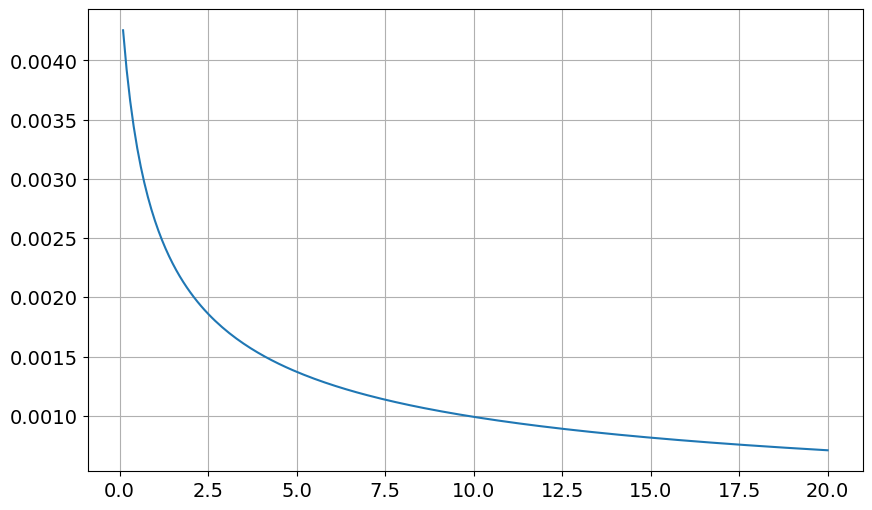

In [7]:
klim= 2*np.pi/4000
Lbox = 75500
klim0 = 2*np.pi/Lbox
klimmin= 2*np.pi/calc_footprint_diam(0.1)
print(klim0-klim,', ',klim0-klimmin)
Hss = np.linspace(0.1,20,200)
plt.plot(Hss,2*np.pi/calc_footprint_diam(Hss))

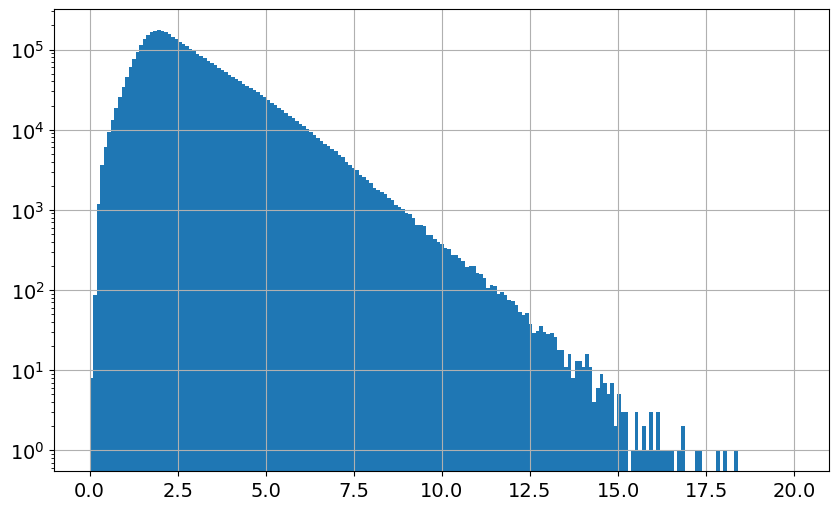

In [10]:
plt.hist(HSBoxB,bins=np.linspace(0,20,200));
plt.yscale('log')

In [48]:
# Esperance (env) = sigma(= Hs/4) * sqrt(np.pi/2) = Hs sqrt(np.pi/32)
# --> Hs = env *sqrt(32/np.pi)
# Var(env) = (4-np.pi)/2 *Hs**2/16

In [49]:
# print('sqrt(32/pi) : ',np.sqrt(32/np.pi),', 2*np.sqrt(2) : ',np.sqrt(8))

In [20]:
# np.save(PATH_BDD+"int_env2_klim0_kc",intB_kcnew)
# np.save(PATH_BDD+'sum_env2_tot',sumBs_totnew)

In [11]:
#### integral for env !
# intB_kcnew = int_-kc^kc B dknew
# sumB_tot : sum B * dknew
# where B = convolution output = S2 (spectrum env2)
#
# sumB = HsBox**4/(4**3) => HSBOX = 4**(3/4)*sumB**(1/4) = np.sqrt(8)*sumB**(1/4)
# int_env = int_env2 *2*(4-np.pi)/Hsbox**2 = int_env2 *2*(4-np.pi)/(8*sumB**(1/2))
# 
# int_env2 = intB_kcnew
# 
# Var(Hs) = <Hs**2> - <Hs>**2
# Var(Hs) = <8 * int_spec_env > # - <Hs>**2
# std(Hs) = np.sqrt(Var(Hs))
#
# /!\ WATCH OUT : integration should be from 0 to kc not from -kc to kc : => div by 2 !!!!!
# A second div by 2 comes from the - <Hs>**2 = 1/2 *int qui va bien

LC = 4000
# -- Babord ---
# -- normalize intto have it only to footprint size
L_footprintB = calc_footprint_diam(HSBoxB)
int_env2_foot_B = intB_kc_B * LC /L_footprintB

sum_env_tot_B = (sumBs_tot_B*2*(4-np.pi)/HSBoxB**2)
int_env_kc_B = (int_env2_foot_B*2*(4-np.pi)/HSBoxB**2)
equiv_std_kc_B = np.sqrt(8*int_env_kc_B)# - HSBoxB**2)
equiv_std_kc_div_Hs_B = equiv_std_kc_B/HSBoxB

int_Env_kc_wihtnoHs_B = intB_kc_B *(4-np.pi)/(4*sumBs_tot_B**(1/2))
equiv_std_kc_wihtnoHs_B = np.sqrt(8*int_Env_kc_wihtnoHs_B)# - 8*sumBs_tot_B**(1/2))
equiv_std_kc_div_Hs_wihtnoHs_B = equiv_std_kc_wihtnoHs_B/ (8**(1/2)*sumBs_tot_B**(1/4))

# -- Tribord ---
L_footprintT = calc_footprint_diam(HSBoxT)
int_env2_foot_T = intB_kc_T * LC /L_footprintT

sum_env_tot_T = (sumBs_tot_T*2*(4-np.pi)/HSBoxT**2)
int_env_kc_T = (int_env2_foot_T*2*(4-np.pi)/HSBoxT**2)
equiv_std_kc_T = np.sqrt(8*int_env_kc_T)# - HSBoxT**2)
equiv_std_kc_div_Hs_T = equiv_std_kc_T/HSBoxT

int_Env_kc_wihtnoHs_T = intB_kc_T *(4-np.pi)/(4*sumBs_tot_T**(1/2))
equiv_std_kc_wihtnoHs_T = np.sqrt(8*int_Env_kc_wihtnoHs_T)# - 8*sumBs_tot_T**(1/2))
equiv_std_kc_div_Hs_wihtnoHs_T = equiv_std_kc_wihtnoHs_T/ (8**(1/2)*sumBs_tot_T**(1/4))


# -- new calculus --------------------- 
# Var(Hs) = Var(env)*32/(4-np.pi) - (32/np.pi)*mean(env)**2
# std(Hs) = np.sqrt(Var(Hs))


# equiv_std_T = np.sqrt(int_env_kc_T*32/(4-np.pi) -  (32/np.pi)

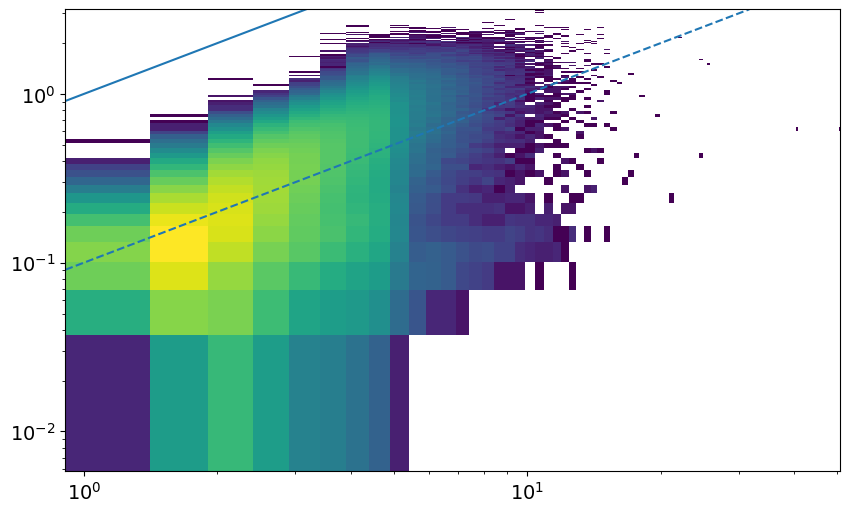

In [21]:
# His,x,y = np.histogram2d(std_Hs_box,std_Hs_nb_used_box,bins=100)
# plt.pcolormesh(x,y,np.log10(His).T)
# std_Hs_box_unnorm = std_Hs_box*np.sqrt(std_Hs_nb_used_box)
His,x,y = np.histogram2d(std_Hs_box_unnorm,equiv_std_kc_wihtnoHs_T,bins=100)
plt.pcolormesh(x,y,np.log10(His).T)
plt.axline((1,1),slope=1)
plt.axline((1,0.1),slope=1,linestyle='--')
plt.xscale('log')
plt.yscale('log')
# plt.plot(std_Hs_box,std_Hs_nb_used_box,'.')

In [10]:
print(4**2/np.pi)

5.092958178940651


In [11]:
# Hrms = Hs/sqrt(2) = sigrms * sqrt(pi/2) => sigrms = Hs /sqrt(2) * sqrt(2/pi) = Hs /sqrt(pi) = sig*4/sqrt(pi)


# distri Hrms = rayleigh(sigrms) 
# var(hrms)= (4-np.pi)/2*sigrms**2=(4-np.pi)*sig**2*4**2/(2*np.pi) = var(env)*4**2/np.pi



# Plots

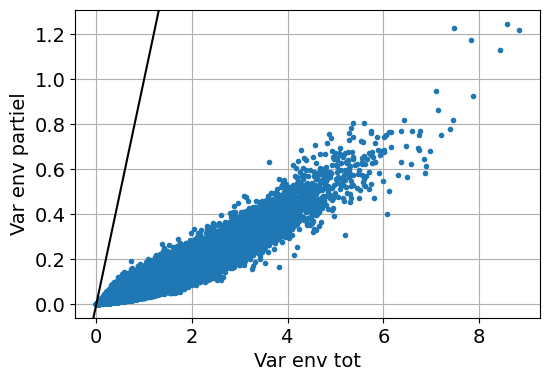

In [9]:
plt.figure(figsize=(6,4))
# plt.plot(sumBs_tot_B,intB_kc_T,'.')
plt.plot(sum_env_tot_T,int_env_kc_T,'.')
plt.axline([1,1],slope=1,color='k');
plt.xlabel('Var env tot');
plt.ylabel('Var env partiel');
# plt.plot(HSBoxT,std_Hs_box/HSBoxT,'.');

coeff =  0.46325137517610426


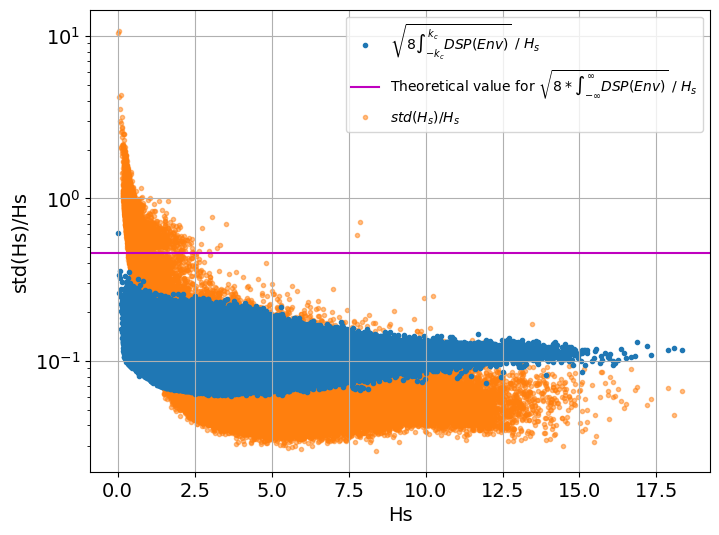

In [9]:
plt.figure(figsize=(8,6))
# plt.plot(HSBoxT,np.sqrt(8*sum_env_tot_T)/HSBoxT,'o')
plt.plot(HSBoxT,equiv_std_kc_T/HSBoxT,'.',label='$\sqrt{8 \int_{-k_c}^{k_c} DSP(Env)}$ / $H_s$',zorder=1)
plt.axhline(np.sqrt(8*(4-np.pi)/32),color='m',
            label='Theoretical value for $\sqrt{8*\int_{-\infty}^{\infty} DSP(Env)}$ / $H_s$')
plt.plot(HSBoxT,std_Hs_box/HSBoxT,'.',label='$std(H_s) / H_s$',alpha=0.5,zorder=0)
# A = HSBoxT**2*(4-np.pi)/32
# plt.plot(std_Hs_box,np.sqrt(A),'.')
# plt.axline([1,1],slope=1,color='k');
plt.yscale('log')
plt.xlabel('Hs');
plt.ylabel('std(Hs)/Hs');
plt.legend(loc=1,fontsize=10)
print('coeff = ',np.sqrt(8*(4-np.pi)/32))

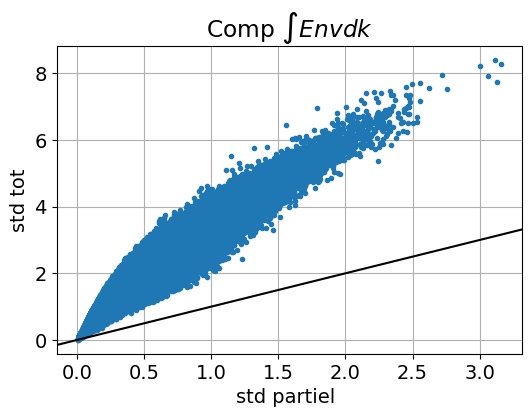

In [66]:
plt.figure(figsize=(6,4))
plt.plot(equiv_std_kc_T,np.sqrt(8*sum_env_tot_T),'.');
# plt.plot(np.logspace(-4,np.log10(200)),np.logspace(-4,np.log10(200)),'-k')
plt.axline([1,1],slope=1,color='k');
plt.xlabel('std partiel ');
plt.ylabel('std tot');
plt.title('Comp $\int Env dk$');

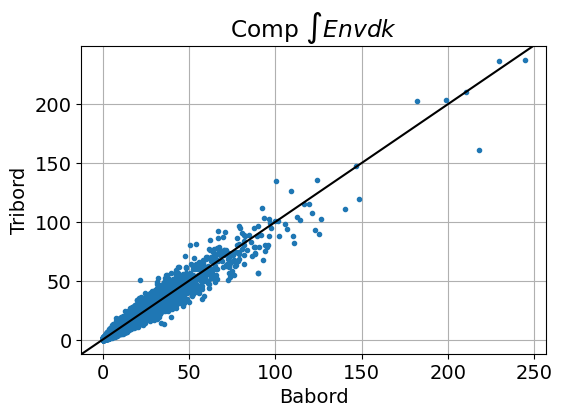

In [8]:
plt.figure(figsize=(6,4))
plt.plot(intB_kc_B,intB_kc_T,'.');
# plt.plot(np.logspace(-4,np.log10(200)),np.logspace(-4,np.log10(200)),'-k')
plt.axline([1,1],slope=1,color='k');
plt.xlabel('Babord');
plt.ylabel('Tribord');
plt.title('Comp $\int Env dk$');

In [5]:
# for val in ALLVARS:
#     exec(val+' = np.array('+val+')')
#     exec('np.save(PATH_save+"'+val+'",'+val+')')

In [10]:
# ---- save time ---------------------
# time_l20 = np.load(os.path.join(PATH_BDD,'time_l2.npy'),allow_pickle=True)
# sh1 = np.array([np.shape(time_l20[k].T[0].flatten()) for k in range(21206)])
# ind_time_l2_not = np.where(sh1==1)[0]
# T1L2P = pd.Timestamp('2000-01-01')
# T1L2 = pd.Timestamp('2009-01-01')

# offset_sec = (T1L2-T1L2P)/pd.Timedelta(seconds=1)

# time_l2 = np.concatenate([np.array(time_l20[k]) if k in ind_time_l2_not 
#            else (offset_sec + np.array(time_l20[k].T[0])) for k in range(21206)])

# print(np.shape(time_l2))
# np.save(os.path.join(PATH_BDD,'time_l2_from_20000101'),time_l2)

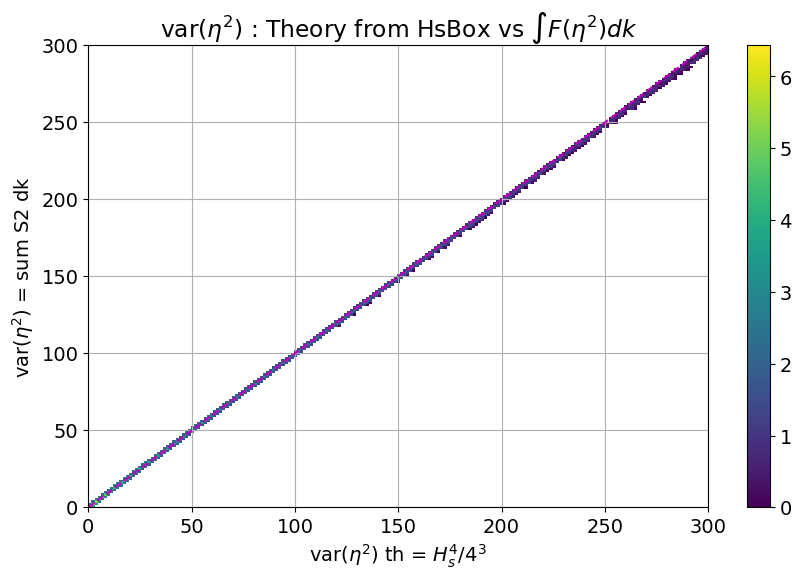

In [21]:
equiv_vareta2_Hs = (HSBoxT**4)/(4**3)
islog = 0 
if islog:
    bins = [np.logspace(-4,np.log10(300),200),np.logspace(-4,np.log10(300),201)]
else:
    bins = [np.linspace(0,300,200),np.linspace(0,300,201)]
    
His,x,y = np.histogram2d(equiv_vareta2_Hs,sumBs_tot_T,bins=bins)
plt.pcolormesh(x,y,np.log10(His).T)
# plt.plot(equiv_vareta2_Hs,sumBs_totnew,'.')
if islog:
    plt.xscale('log')
    plt.yscale('log')
plt.xlabel('var($\eta^2$) th = $H_s^4 / 4^3 $')
plt.ylabel('var($\eta^2$) = sum S2 dk')
plt.title('var($\eta^2$) : Theory from HsBox vs $\int F(\eta^2) dk$')
plt.grid(True)
plt.colorbar()
plt.plot(np.logspace(-4,np.log10(300)),np.logspace(-4,np.log10(300)),'--m')

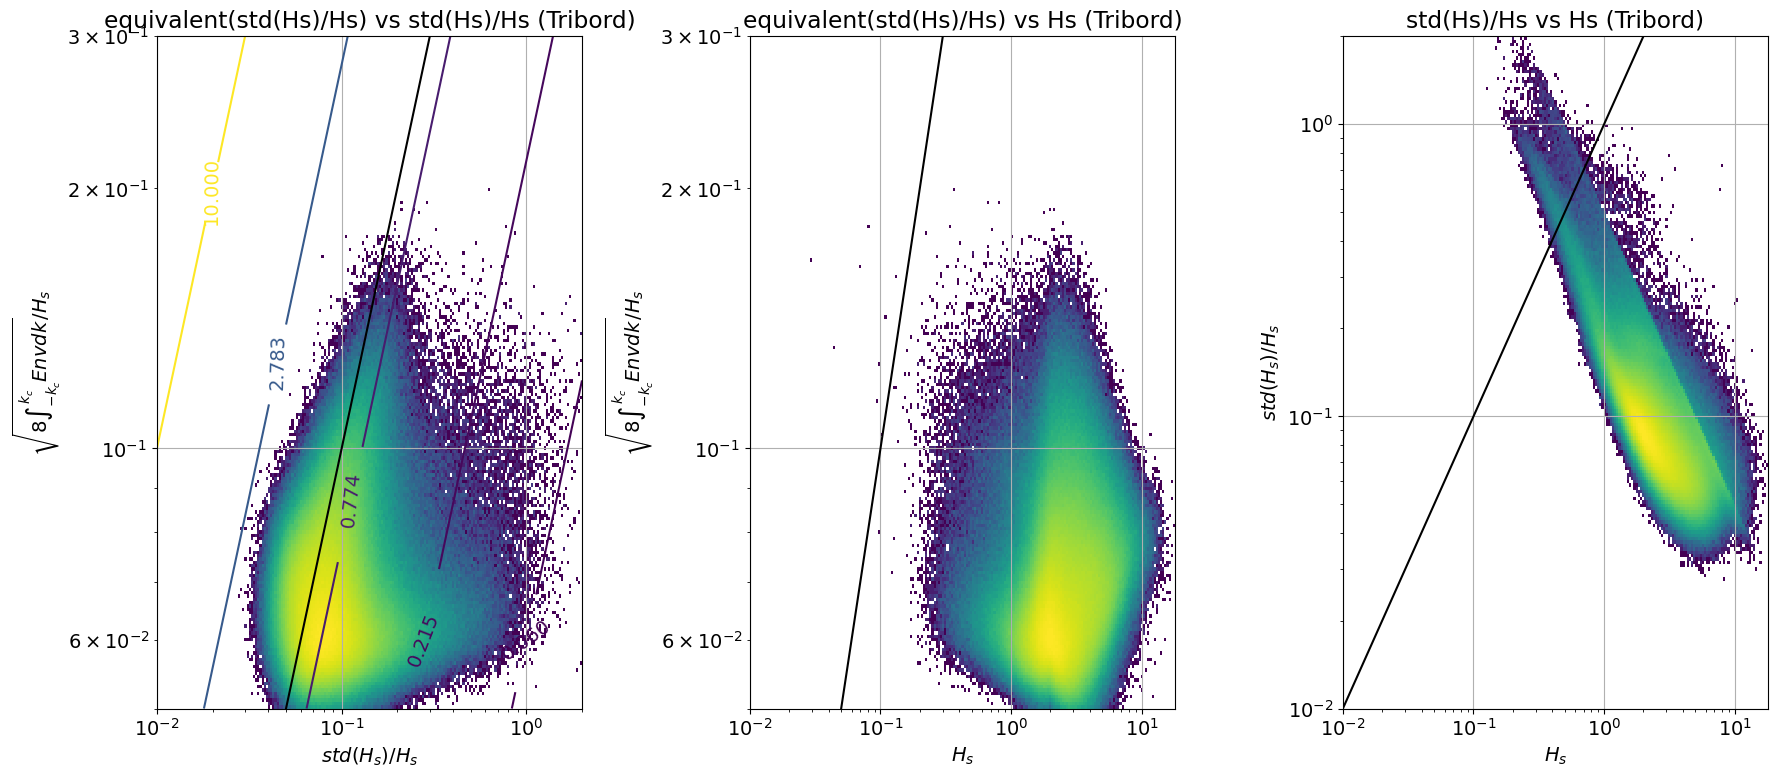

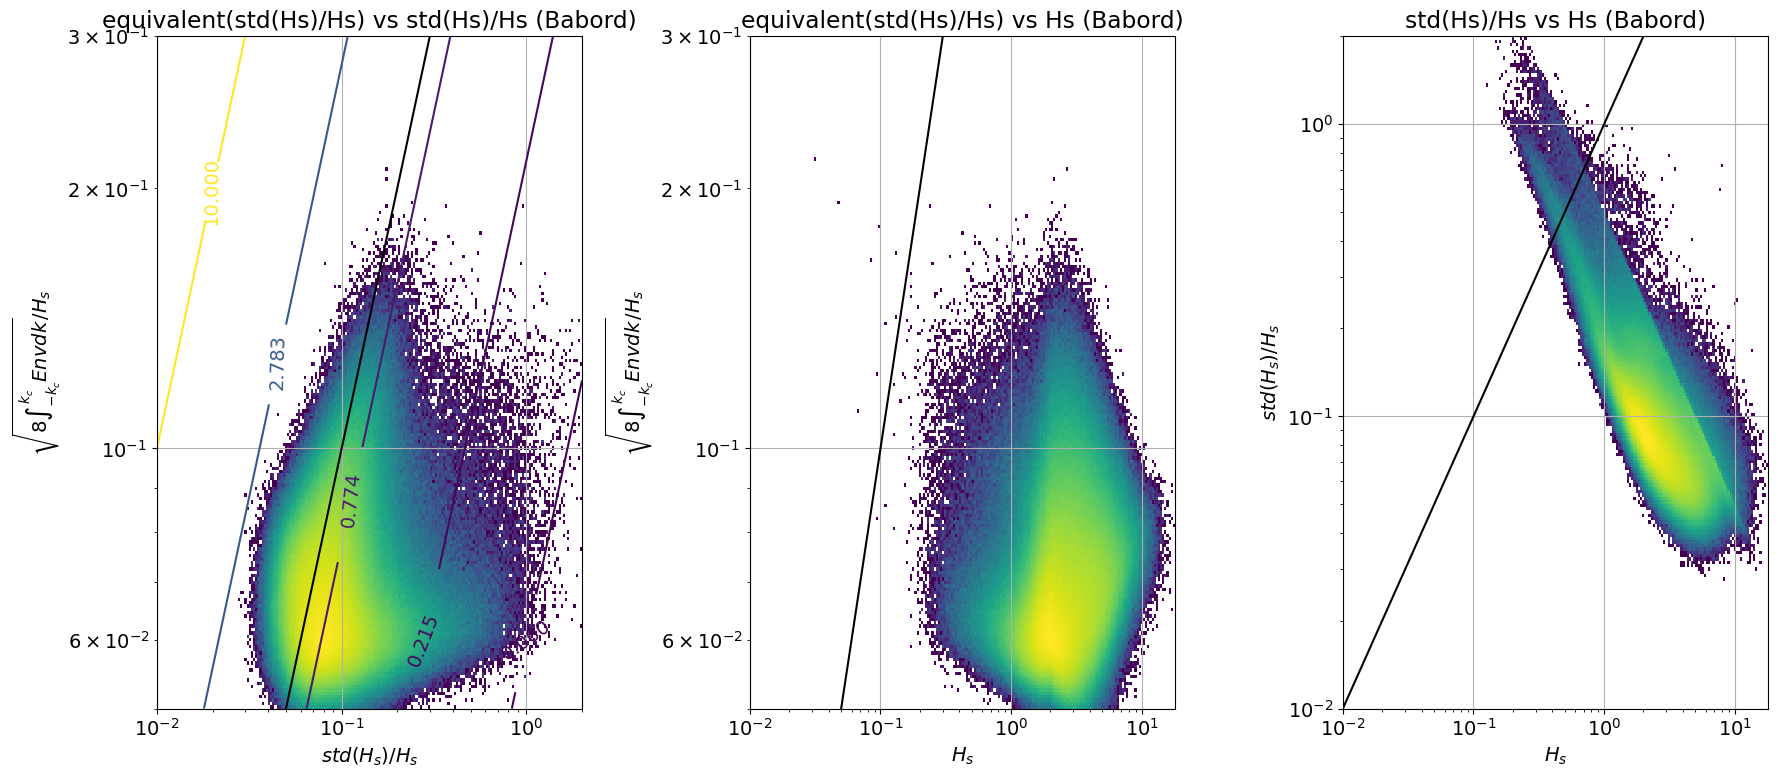

In [25]:
#### ------------ std/Hs fonction equivalent TRIBORD -------------------
fig,axs = plt.subplots(1,3,figsize=(18,8))

His,x,y = np.histogram2d(std_Hs_box/HSBoxT,equiv_std_kc_div_Hs_T,#_wihtnoHs,
                         bins=[np.logspace(-2,np.log10(2),200),np.logspace(np.log10(5e-2),np.log10(3e-1),201)])

x2,y2 = np.meshgrid(x,y)
ratio_explained_byWG = y2/x2
axs[0].pcolormesh(x,y,np.log10(His).T)
CS=axs[0].contour(x2,y2,ratio_explained_byWG,color='w',levels=np.logspace(-4,1,10))
_=CS.clabel()#fmt=fmt)
axs[0].plot(y,y,'-k')
axs[0].set_xscale('log')
axs[0].set_yscale('log')
axs[0].set_xlabel('$std(H_s) / H_s $')
axs[0].set_ylabel('$\sqrt{8 \int_{-k_c}^{k_c} Env dk}/ H_s$')
# axs[0].set_xlim((8e-3,3))
# axs[0].set_ylim((5e-2,3e-1))
axs[0].grid(True)
axs[0].set_title('equivalent(std(Hs)/Hs) vs std(Hs)/Hs (Tribord)')

His,x,y = np.histogram2d(HSBoxT,equiv_std_kc_div_Hs_T,
                         bins=[np.logspace(-2,np.log10(18),200),np.logspace(np.log10(5e-2),np.log10(3e-1),201)])

axs[1].pcolormesh(x,y,np.log10(His).T)
# axs[0].plot(std_Hs_box,equiv_std_kc,'.')
axs[1].plot(y,y,'-k')
axs[1].set_xscale('log')
axs[1].set_yscale('log')
axs[1].set_xlabel('$ H_s $')
axs[1].set_ylabel('$\sqrt{8 \int_{-k_c}^{k_c} Env dk}/ H_s$')
# axs[1].set_xlim((8e-3,18))
# axs[1].set_ylim((5e-2,3e-1))
axs[1].set_title('equivalent(std(Hs)/Hs) vs Hs (Tribord)')
axs[1].grid(True)

His,x,y = np.histogram2d(HSBoxT,std_Hs_box/HSBoxT,
                         bins=[np.logspace(-2,np.log10(18),200),np.logspace(-2,np.log10(2),201)])

axs[2].pcolormesh(x,y,np.log10(His).T)
# axs[0].plot(std_Hs_box,equiv_std_kc,'.')
axs[2].plot(y,y,'-k')
# axs[0].plot(xtot,(xtot/15)**3,'-*r',label='reg tot')
# axs[0].plot(xtot,(xtot/35)**2,'-*m',label='reg tot')
axs[2].set_xscale('log')
axs[2].set_yscale('log')
axs[2].set_xlabel('$ H_s $')
axs[2].set_ylabel('$std( H_s ) / H_s$')
axs[2].set_title('std(Hs)/Hs vs Hs (Tribord)')
# axs[2].set_xlim((8e-3,18))
# axs[2].set_ylim((5e-2,3e-1))
axs[2].grid(True)

plt.tight_layout()

#### ------------ std/Hs fonction equivalent BABORD -------------------
fig,axs = plt.subplots(1,3,figsize=(18,8))

His,x,y = np.histogram2d(std_Hs_box/HSBoxB,equiv_std_kc_div_Hs_B,#_wihtnoHs,
                         bins=[np.logspace(-2,np.log10(2),200),np.logspace(np.log10(5e-2),np.log10(3e-1),201)])

x2,y2 = np.meshgrid(x,y)
ratio_explained_byWG = y2/x2
axs[0].pcolormesh(x,y,np.log10(His).T)
CS=axs[0].contour(x2,y2,ratio_explained_byWG,color='w',levels=np.logspace(-4,1,10))
_=CS.clabel()#fmt=fmt)
axs[0].plot(y,y,'-k')
axs[0].set_xscale('log')
axs[0].set_yscale('log')
axs[0].set_xlabel('$std(H_s) / H_s $')
axs[0].set_ylabel('$\sqrt{8 \int_{-k_c}^{k_c} Env dk}/ H_s$')
# axs[0].set_xlim((8e-3,3))
# axs[0].set_ylim((5e-2,3e-1))
axs[0].grid(True)
axs[0].set_title('equivalent(std(Hs)/Hs) vs std(Hs)/Hs (Babord)')

His,x,y = np.histogram2d(HSBoxB,equiv_std_kc_div_Hs_B,
                         bins=[np.logspace(-2,np.log10(18),200),np.logspace(np.log10(5e-2),np.log10(3e-1),201)])

axs[1].pcolormesh(x,y,np.log10(His).T)
# axs[0].plot(std_Hs_box,equiv_std_kc,'.')
axs[1].plot(y,y,'-k')
axs[1].set_xscale('log')
axs[1].set_yscale('log')
axs[1].set_xlabel('$ H_s $')
axs[1].set_ylabel('$\sqrt{8 \int_{-k_c}^{k_c} Env dk}/ H_s$')
# axs[1].set_xlim((8e-3,18))
# axs[1].set_ylim((5e-2,3e-1))
axs[1].set_title('equivalent(std(Hs)/Hs) vs Hs (Babord)')
axs[1].grid(True)

His,x,y = np.histogram2d(HSBoxB,std_Hs_box/HSBoxB,
                         bins=[np.logspace(-2,np.log10(18),200),np.logspace(-2,np.log10(2),201)])

axs[2].pcolormesh(x,y,np.log10(His).T)
# axs[0].plot(std_Hs_box,equiv_std_kc,'.')
axs[2].plot(y,y,'-k')
# axs[0].plot(xtot,(xtot/15)**3,'-*r',label='reg tot')
# axs[0].plot(xtot,(xtot/35)**2,'-*m',label='reg tot')
axs[2].set_xscale('log')
axs[2].set_yscale('log')
axs[2].set_xlabel('$ H_s $')
axs[2].set_ylabel('$std( H_s ) / H_s$')
axs[2].set_title('std(Hs)/Hs vs Hs (Babord)')
# axs[2].set_xlim((8e-3,18))
# axs[2].set_ylim((5e-2,3e-1))
axs[2].grid(True)

plt.tight_layout()

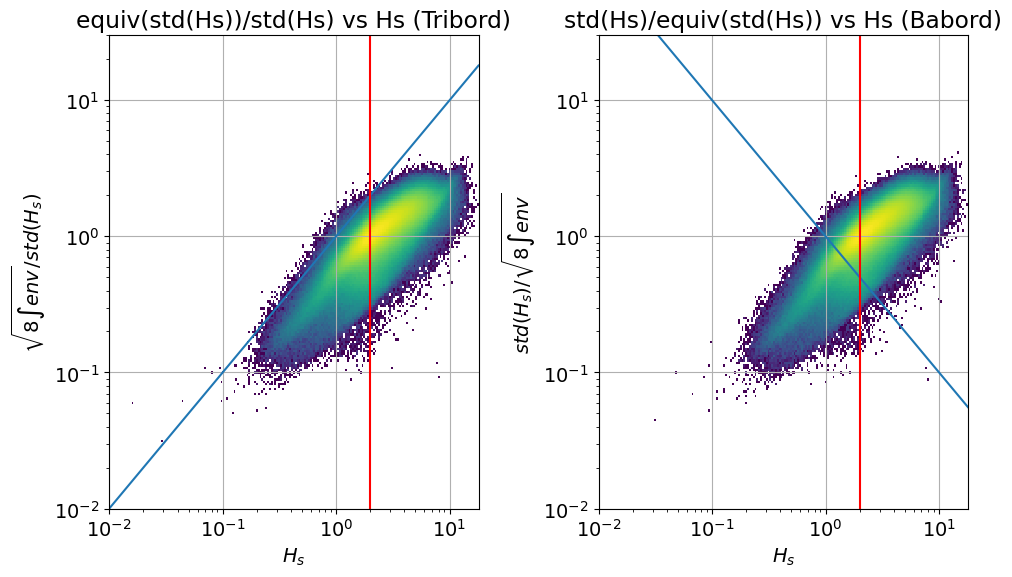

In [10]:
fig,axs = plt.subplots(1,2)
His,x,y = np.histogram2d(HSBoxT,equiv_std_kc_T/std_Hs_box,
                         bins=[np.logspace(-2,np.log10(18),200),np.logspace(-2,np.log10(30),201)])
axs[0].pcolormesh(x,y,np.log10(His).T)
axs[0].axline([1,1],slope=1) 
axs[0].axvline(2,color='r') 
axs[0].set_xscale('log')
axs[0].set_yscale('log')
axs[0].set_xlabel('$ H_s $')
axs[0].set_ylabel('$\sqrt{ 8 \int env} / std( H_s )$')
axs[0].set_title('equiv(std(Hs))/std(Hs) vs Hs (Tribord)')
# axs[0].set_xlim((8e-3,18))
# axs[0].set_ylim((5e-2,3e-1))
axs[0].grid(True)

His,x,y = np.histogram2d(HSBoxB,equiv_std_kc_B/std_Hs_box,
                         bins=[np.logspace(-2,np.log10(18),200),np.logspace(-2,np.log10(30),201)])
axs[1].pcolormesh(x,y,np.log10(His).T)
axs[1].axline([1,1],slope=-1) 
axs[1].axvline(2,color='r') 
axs[1].set_xscale('log')
axs[1].set_yscale('log')
axs[1].set_xlabel('$ H_s $')
axs[1].set_ylabel('$std( H_s ) / \sqrt{ 8 \int env}$')
axs[1].set_title('std(Hs)/equiv(std(Hs)) vs Hs (Babord)')
# axs[1].set_xlim((8e-3,18))
# axs[1].set_ylim((5e-2,3e-1))
axs[1].grid(True)

plt.tight_layout()

(30,) (32,) (29, 31)
30
3934979


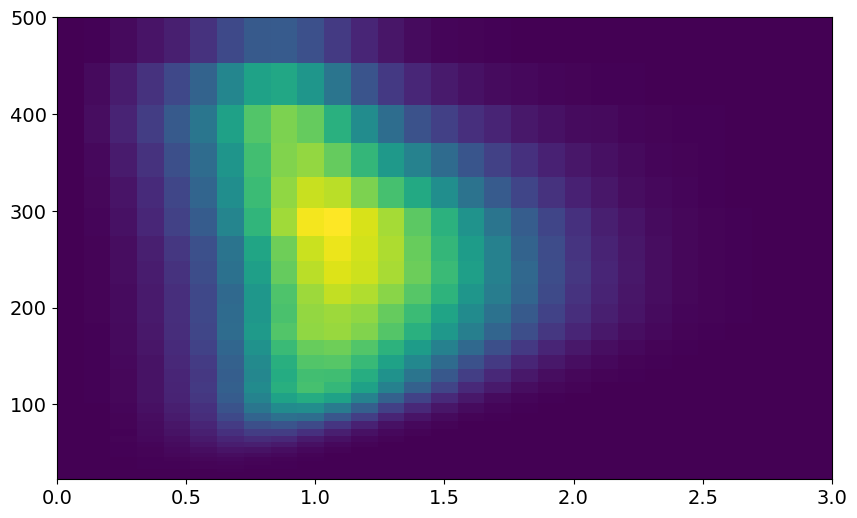

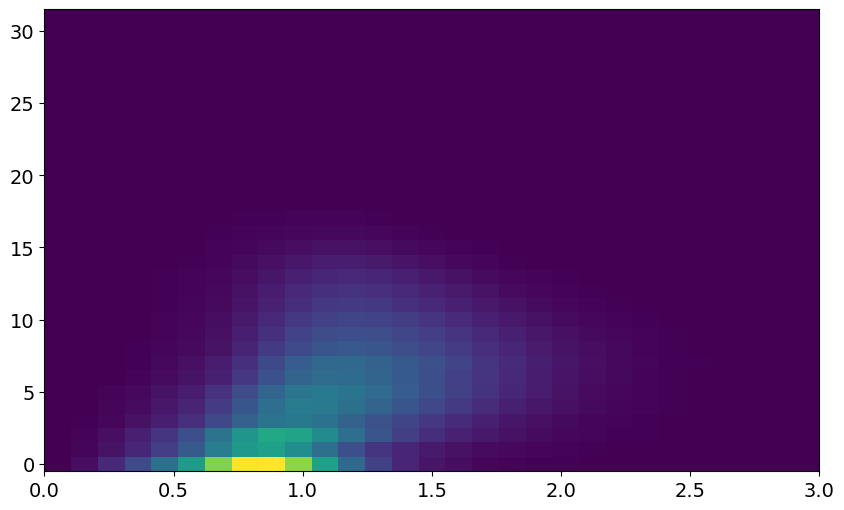

In [16]:
ratioT = equiv_std_kc_T/std_Hs_box
ratioB = equiv_std_kc_B/std_Hs_box

# x,b,_=plt.hist(ratioT,bins=100)
# plt.hist(ratioB,bins=b,alpha=0.5)

ratts = np.linspace(0,3,30)#[0, 0.5,0.7,0.8,0.9,1,1.5,2,3])
WVLs = np.flip(twopi/k_vec)

ratios2D,WVL2D = np.meshgrid(ratts,WVLs)
His,x,y=np.histogram2d(ratioT,WVLT,bins=[ratts,WVLs])

print(np.shape(x),np.shape(y),np.shape(His))
plt.pcolormesh(x,y,His.T)

print(len(ratts))
argfmax= np.argmax(SpecT,axis=1)
print(len(argfmax))
argsf = np.arange(33)-0.5
plt.figure()
His,x,y=np.histogram2d(ratioT,argfmax,bins=[ratts,argsf])
plt.pcolormesh(x,y,His.T)

# fig,axs=plt.subplots(4,2,figsize=(18,28))

# for ir, ratio0 in enumerate(ratts[:-1]):
#     indratio_T =np.where((ratioT>ratio0)&(ratioT<=ratts[ir+1]))[0]
#     indratio_B =np.where((ratioB>ratio0)&(ratioB<=ratts[ir+1]))[0]
#     specmeanT = np.mean(SpecT[indratio_T,:].T/HSBoxT[indratio_T]**2,axis=1)
#     specstdT = np.std(SpecT[indratio_T,:].T/HSBoxT[indratio_T]**2,axis=1)
#     specmeanB = np.mean(SpecB[indratio_B,:].T/HSBoxB[indratio_B]**2,axis=1)
#     specstdB = np.std(SpecB[indratio_B,:].T/HSBoxB[indratio_B]**2,axis=1)
    
#     axs[ir//2,ir%2].plot(k_vec,specmeanT,'-k',lw=3)
#     axs[ir//2,ir%2].plot(k_vec,specmeanT+specstdT,'--k',alpha=0.8,lw=1)
#     axs[ir//2,ir%2].plot(k_vec,specmeanT-specstdT,'--k',alpha=0.8,lw=1)
#     axs[ir//2,ir%2].plot(k_vec,specmeanB,'-b',lw=3)
#     axs[ir//2,ir%2].plot(k_vec,specmeanB+specstdB,'--b',alpha=0.8,lw=1)
#     axs[ir//2,ir%2].plot(k_vec,specmeanB-specstdB,'--b',alpha=0.8,lw=1)


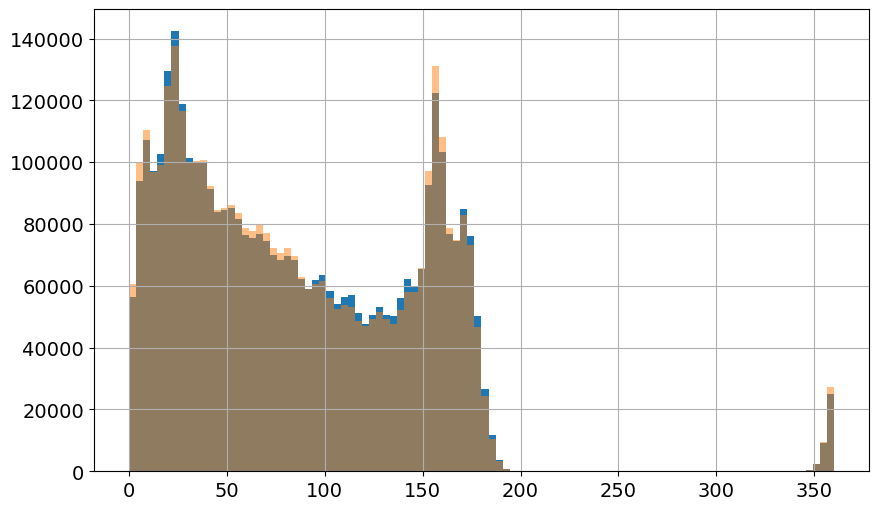

In [25]:
plt.hist(DIRB,bins=100);
plt.hist(DIRT,bins=100,alpha=0.5);

(199, 200) (199,)


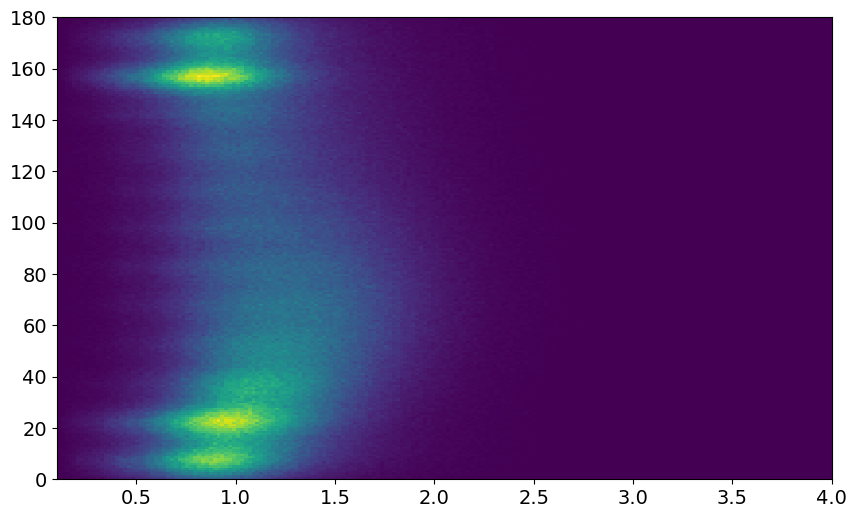

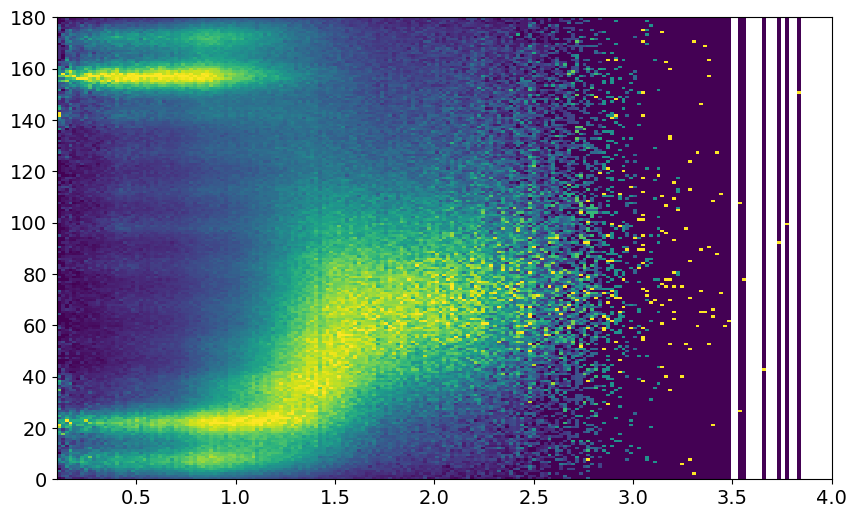

In [45]:
DIRT[DIRT>200] = DIRT[DIRT>200] -360

His,x,y = np.histogram2d(ratioT,DIRT,bins=[np.linspace(0.1,4,200),np.linspace(0,180,201)])
# plt.plot(ratioT,DIRT,'.')
print(np.shape(His),np.shape(np.max(His,axis=1)))
plt.pcolormesh(x,y,(His.T))#/np.max(His,axis=1)))
plt.figure()
DIRB[DIRB>200] = DIRB[DIRB>200] -360

His,x,y = np.histogram2d(ratioB,DIRB,bins=[np.linspace(0.1,4,200),np.linspace(0,180,201)])
# plt.plot(ratioT,DIRT,'.')
plt.pcolormesh(x,y,(His.T/np.max(His,axis=1)))


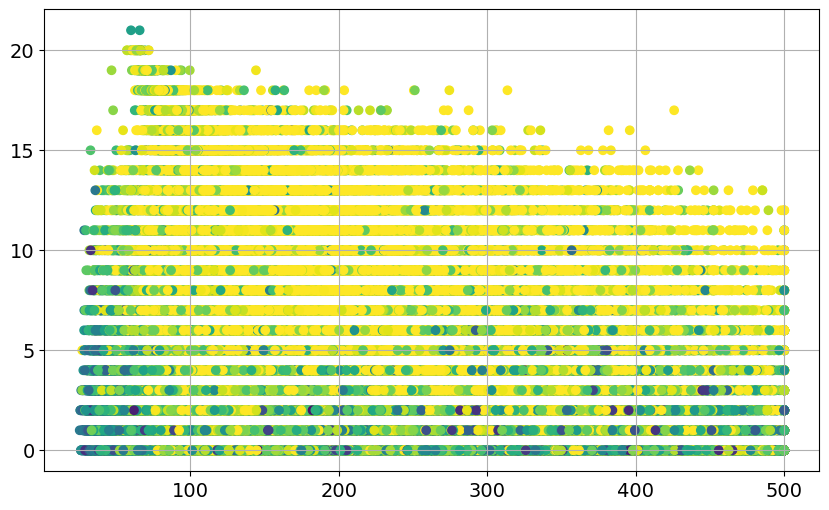

In [41]:
plt.scatter(WVLT,argfmax,c=ratioT,vmax=1)

In [21]:
twopi/k_vec

array([500.01474 , 452.45087 , 409.38138 , 370.4272  , 335.17474 ,
       303.2718  , 274.41086 , 248.29819 , 224.6723  , 203.28671 ,
       183.94478 , 166.43759 , 150.60007 , 136.2681  , 123.29884 ,
       111.56621 , 100.9493  ,  91.34263 ,  82.64957 ,  74.78469 ,
        67.66809 ,  61.228287,  55.401905,  50.12953 ,  45.35908 ,
        41.042698,  37.13686 ,  33.6028  ,  30.40511 ,  27.511616,
        24.893564,  22.524658], dtype=float32)

In [8]:
# plt.plot(time_l2_pd[indflag],time_l2p_pd[indflag],'.')

var env2 pos vs neg (B) =  156.2498221447264 , var env2 pos & neg (A) =  156.24982214472658
var eta2 from Hs (int spec) =  156.2500000000001 , from Hs box =  0.4222253600517004
if the 2 previous lines are equal => good normalization !!! 


(156.2498221447264,
 156.24982214472658,
 33.87228248864735,
 33.872282488647336,
 156.2500000000001,
 0.4222253600517004)

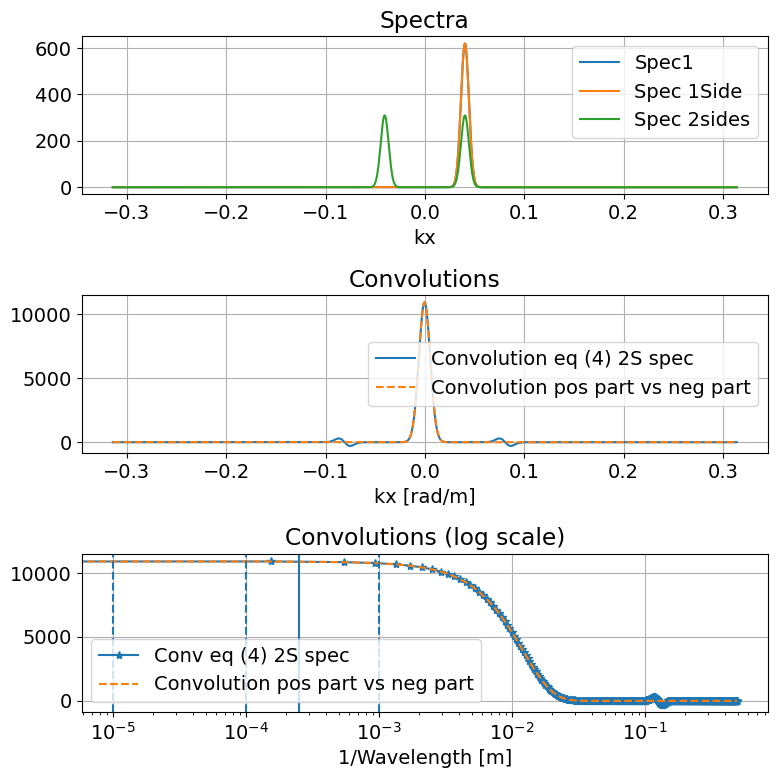

In [8]:
# --------- Plot comparison 2 convolution methods --------------------
istheoreticalSpec= 1
Nresampling = 2501
inds=np.where(HSBoxT>2)[0][0]
LC = 4000
klim = 2*np.pi/LC

if istheoreticalSpec:
    x,kvec2,c = def_spectrumG_for_surface_1D(nx=2048,T0=10,Hs=10)

else:
    kvec2 = np.concatenate([-k_vec[::-1],np.zeros(1),k_vec])#,np.zeros(1),k_vec])
    x = np.concatenate([np.zeros(33),SpecT[inds]])
    Hs_x = HSBoxT[inds]
    print('Hs box = ',Hs_x)
    
plot_spec_convol(x,kvec2,Nresampling,klim=2*np.pi/4000,Hsth=HSBoxT[inds])
# axs[3].legend()

# raisonnement : |F(zeta)| = |F(zeta)|_- + |F(zeta)|+
# 2*|F(zeta)|_+ = |F(zeta)|obs
# |F(zeta)|_+ = |F(zeta)|_- = 0.5*|F(zeta)|_obs

# |F(zeta)|*|F(zeta)| - remove(F(zeta)) = 2*(|F(zeta)|_+ * |F(zeta)|_-) perché ?

In [10]:
# kvec2=np.concatenate([-k_vec[::-1],np.zeros(1),k_vec])
# NbSpec_per_loop = 5000
# sumB2 = np.zeros(NbSpec_per_loop)
# sumA = np.zeros(NbSpec_per_loop)
# intB = np.zeros(NbSpec_per_loop)
# intA = np.zeros(NbSpec_per_loop)
# var_eta2_Hs_spec = np.zeros(NbSpec_per_loop)
# var_eta2_Hs_box = np.zeros(NbSpec_per_loop)
# for indk in range(NbSpec_per_loop):
#     if indk%100 ==0:
#         print('k = ',indk,' over ',NbSpec_per_loop/100)
#     x = np.concatenate([np.zeros(33),SpecT[indk]])
#     sumB2[indk],sumA[indk],intB[indk],intA[indk],var_eta2_Hs_spec[indk],var_eta2_Hs_box[indk] = plot_spec_convol(x,kvec2,2501,klim=2*np.pi/4000,
#                                                                              Hsth=HSBoxT[indk],isplot=0)

In [11]:
def calculate_moments(spec,f_vec,mom):
    df_vec = np.gradient(f_vec)
    moment = np.sum(spec*(f_vec**mom)*df_vec,axis=1)
    moment2 = np.sum(spec**2*(f_vec**mom)*df_vec,axis=1)
    
    return moment,moment2

issave = 0
suff='T'

Spec_f,f_vec = spectrum_k_to_f(SpecT,k_vec)

m0,m02 = calculate_moments(Spec_f,f_vec,0)
m1,m12 = calculate_moments(Spec_f,f_vec,1)
m2,m22 = calculate_moments(Spec_f,f_vec,2)
m3,m32 = calculate_moments(Spec_f,f_vec,3)

mm1,mm12 = calculate_moments(Spec_f,f_vec,-1)
mm2,mm22 = calculate_moments(Spec_f,f_vec,-2)

# spread and Goda ##################################

spread_f = m0**2/m02
Goda_param = (2*m12)/(m0**2)
# spread_f = np.zeros(np.size(Spec_f,0))
# spread_f[Specflag==False] = spread_f0
# Goda_param = np.zeros(np.size(Spec_f,0))
# Goda_param[Specflag==False] = Goda_param0

if issave:
    np.save(PATH_save+"spread_f_"+suff,spread_f)
    np.save(PATH_save+"Goda_param_"+suff,Goda_param)


In [40]:
def cal_plateau(Hs,sk0,k):
    return 8*Hs**2*(4-np.pi)*1e-3*np.sqrt(2*np.pi)/(32*np.sqrt(2)*(sk0*k))

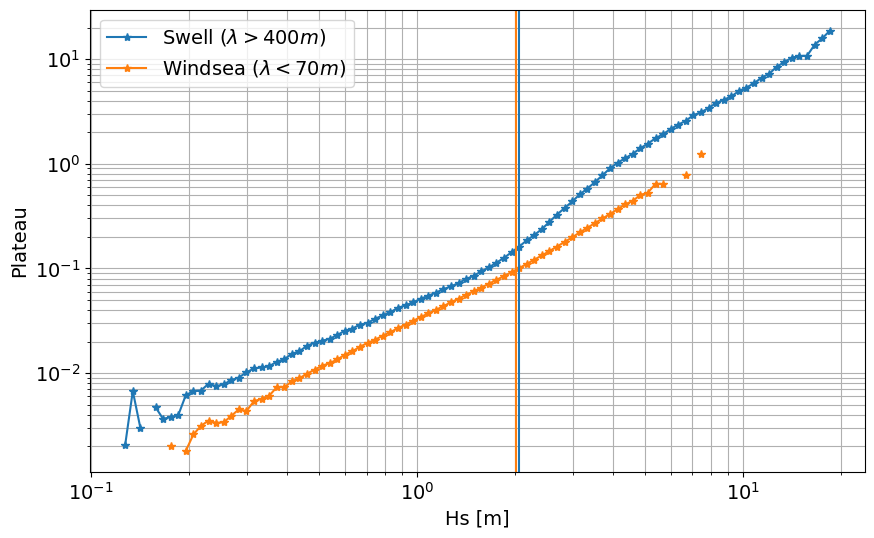

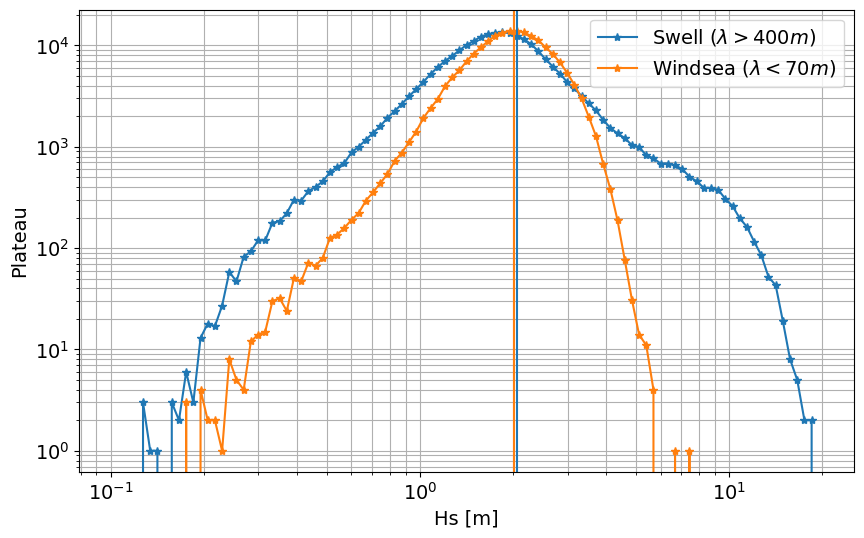

In [11]:
val_plato_env_T = int_env_kc_T/(2*twopi/(LC))
val_plato_Hs_T = (8*val_plato_env_T)#

equiv_sk0 = (HSBoxT*2*(4-np.pi))/(32*np.sqrt(twopi*2)*(twopi/WVLT)*val_plato_Hs_T)

Hss = np.logspace(-1,np.log10(20),100)

ind_wind_sea = np.where((WVLT<90))[0]#&(time_l2_pd>pd.Timestamp('2020-01-01'))&(time_l2_pd<=pd.Timestamp('2020-03-01')))[0]
ind_swell = np.where((WVLT>400))[0]#&(time_l2_pd>pd.Timestamp('2020-01-01'))&(time_l2_pd<=pd.Timestamp('2020-03-01')))[0]

val_plato_env_T = int_env_kc_T[ind_wind_sea]/(1/(LC*1e-3))
val_plato_Hs_T = (8*val_plato_env_T)# - HSBoxT**2)

val_plato_env_T = int_env_kc_T[ind_swell]/(1/(LC*1e-3))
val_plato_Swell_Hs_T = (8*val_plato_env_T)# - HSBoxT**2)

bin_windsea_val,_ = np.histogram(HSBoxT[ind_wind_sea],bins=Hss,weights=val_plato_Hs_T)
bin_windsea,_ = np.histogram(HSBoxT[ind_wind_sea],bins=Hss)
Hsmeanwindsea = np.mean(HSBoxT[ind_wind_sea])
bin_swell_val,_ = np.histogram(HSBoxT[ind_swell],bins=Hss,weights=val_plato_Swell_Hs_T)
bin_swell,_ = np.histogram(HSBoxT[ind_swell],bins=Hss)
Hsmeanswell = np.mean(HSBoxT[ind_swell])

plt.plot(0.5*(Hss[0:-1]+Hss[1:]),bin_swell_val/bin_swell,'-*',label='Swell ($\lambda > 400 m$)')
plt.plot(0.5*(Hss[0:-1]+Hss[1:]),bin_windsea_val/bin_windsea,'-*',label='Windsea ($\lambda < 70 m$)')
plt.axvline(Hsmeanswell,color=colors[0])
plt.axvline(Hsmeanwindsea,color=colors[1])
plt.legend()
plt.xlabel('Hs [m]')
plt.ylabel('Plateau')
plt.xscale('log')
plt.yscale('log')
plt.grid(True,which='both')

plt.figure()
plt.plot(0.5*(Hss[0:-1]+Hss[1:]),bin_swell,'-*',label='Swell ($\lambda > 400 m$)')
plt.plot(0.5*(Hss[0:-1]+Hss[1:]),bin_windsea,'-*',label='Windsea ($\lambda < 70 m$)')
plt.axvline(Hsmeanswell,color=colors[0])
plt.axvline(Hsmeanwindsea,color=colors[1])
plt.legend()
plt.xlabel('Hs [m]')
plt.ylabel('Plateau')
plt.xscale('log')
plt.yscale('log')
plt.grid(True,which='both')

# equiv_sk0

# plt.plot(HSBoxT[ind_swell],val_plato_Swell_Hs_T,'.')
# plt.plot(HSBoxT[ind_wind_sea],val_plato_Hs_T,'.')


# print('Wind sea = ',np.mean(val_plato_Hs_T),', Swell = ',np.mean(val_plato_Swell_Hs_T))
# print('From calc :')
# print('Wind sea = ',cal_plateau(HS_windsea,sk0_windsea,k_windsea),', Swell = ',cal_plateau(HS_swell,sk0_swell,k_swell))

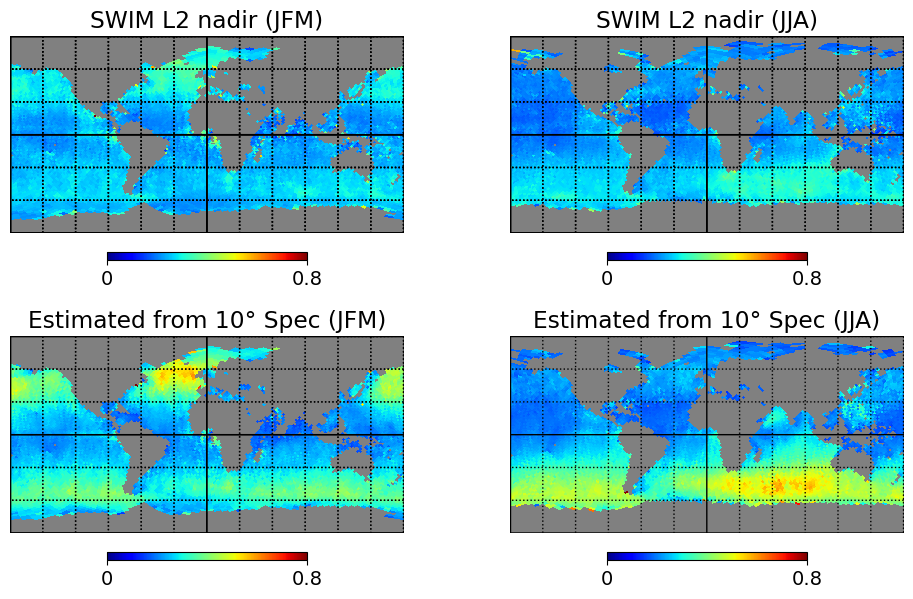

In [50]:
### case : std_HS / hs and intEnv_kc_withnoHs
Timemonth = np.array(Timemonth)#[indflag]
indfmax = np.argmax(SpecT,axis=-1)


NSIDE = 32
NPIX = hp.nside2npix(NSIDE)
m = np.random.uniform(size=NPIX)
pidx = hp.ang2pix(NSIDE,(90-LAT)*np.pi/180,-LOT*np.pi/180)
Hslim = 2
Hslimmax = 10
isint=0
conditions_stay = ((HSBoxT>Hslim)&((DIRT<20)|(DIRT>140))&(std_Hs_box>0))#&(WVLT>400))
conditions_stay = ((HSBoxT>Hslim)&(std_Hs_box>0))#&(WVLT>400))


X1 = std_Hs_box#/HSBoxT#np.sqrt(int_env_kc)/HSBoxT
X2 = equiv_std_kc_T#/HSBoxT#np.sqrt(int_env_kc)/HSBoxT#std_Hs_box/HSBoxB#np.sqrt(int_Env_kc_wihtnoHs)/HSBoxT
cmax1 = 0.8#0.22
cmax2 = 0.8#None

# --- JFM ----
ind = np.where((Timemonth>=1)&(Timemonth<=3)&(conditions_stay))[0]
res= np.bincount(pidx[ind],weights=X1[ind],minlength=12*NSIDE**2)
nres = np.bincount(pidx[ind],minlength=12*NSIDE**2)
moy = res/nres
moy[nres==0]=hp.UNSEEN
# --- JJA ----
ind = np.where((Timemonth>=6)&(Timemonth<9)&(conditions_stay))[0]
res = np.bincount(pidx[ind],weights=X1[ind],minlength=12*NSIDE**2)
nres = np.bincount(pidx[ind],minlength=12*NSIDE**2)
moy2 = res/nres
moy2[nres==0]=hp.UNSEEN

# --- JFM ----
ind = np.where((Timemonth>=1)&(Timemonth<=3)&(conditions_stay))[0]
res= np.bincount(pidx[ind],weights=X2[ind],minlength=12*NSIDE**2)
nres = np.bincount(pidx[ind],minlength=12*NSIDE**2)
moy3 = res/nres
moy3[nres==0]=hp.UNSEEN
# --- JJA ----
ind = np.where((Timemonth>=6)&(Timemonth<9)&(conditions_stay))[0]
res = np.bincount(pidx[ind],weights=X2[ind],minlength=12*NSIDE**2)
nres = np.bincount(pidx[ind],minlength=12*NSIDE**2)
moy4 = res/nres
moy4[nres==0]=hp.UNSEEN

fig = plt.figure()
plt.tight_layout()
hp.cartview(moy,cmap='jet',fig=fig,sub=221,title='SWIM L2 nadir (JFM)',max=cmax1,min=0,margins=[0.05,0.05,0.05,0.05])#,max=0.15)#,max=0.004)
hp.graticule()

hp.cartview(moy2,cmap='jet',fig=fig,sub=222,title='SWIM L2 nadir (JJA)',max=cmax1,min=0,margins=[0.05,0.05,0.05,0.05])#,max=0.15)#,max=0.06)
hp.graticule()

hp.cartview(moy3,cmap='jet',fig=fig,sub=223,title='Estimated from 10° Spec (JFM)',max=cmax2,min=0,margins=[0.05,0.05,0.05,0.05])#,max=0.15)#,max=0.004)
hp.graticule()

hp.cartview(moy4,cmap='jet',fig=fig,sub=224,title='Estimated from 10° Spec (JJA)',max=cmax2,min=0,margins=[0.05,0.05,0.05,0.05])#,max=0.06)
hp.graticule()
# plt.title('std(Hs)/Hs (Hs > '+str(Hslim)+'m)')
# plt.savefig('carto_stdHs_divHs_Hsabove2_obs_vs_estimated.png')

In [52]:
ind = np.where((conditions_stay)&(np.isfinite(std_Hs_box)))[0]
print(time_l2_pd[ind[0]],time_l2_pd[ind[-1]])

2019-09-04T18:43:19.000000000 2022-05-29T20:41:10.000000000


mean wvl (<90) :  73.55781  , mean wvl (>400) :  434.34274
median wvl (<90) :  76.619995  , median wvl (>400) :  427.58307
mean Hs wvl (<90) :  2.0127256  , mean Hs wvl (>400) :  2.0599663
median Hs wvl (<90) :  1.9581041  , median Hs wvl (>400) :  1.7864099
25.384266 ,  500.01477


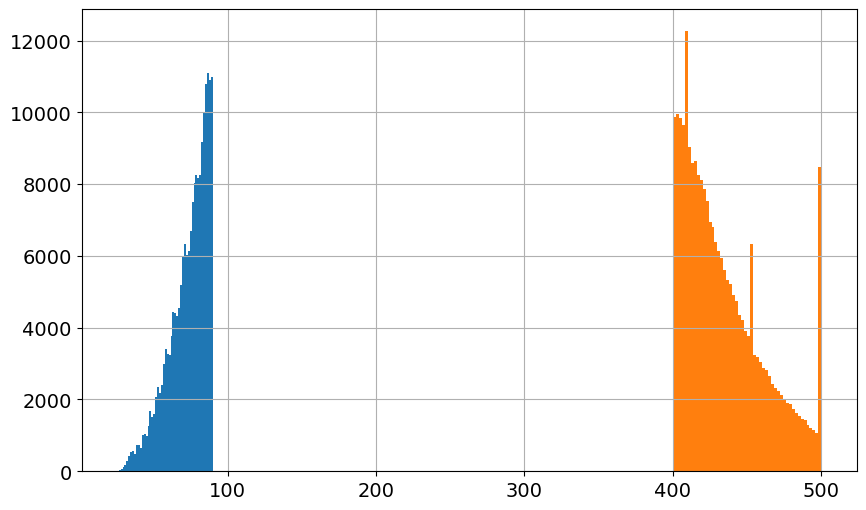

In [80]:
plt.hist(WVLT[WVLT<90],bins=50)
plt.hist(WVLT[WVLT>400],bins=50)
print('mean wvl (<90) : ',np.mean(WVLT[WVLT<90]),' , mean wvl (>400) : ',np.mean(WVLT[WVLT>400]))
print('median wvl (<90) : ',np.median(WVLT[WVLT<90]),' , median wvl (>400) : ',np.median(WVLT[WVLT>400]))

print('mean Hs wvl (<90) : ',np.mean(HSBoxT[WVLT<90]),' , mean Hs wvl (>400) : ',np.mean(HSBoxT[WVLT>400]))
print('median Hs wvl (<90) : ',np.median(HSBoxT[WVLT<90]),' , median Hs wvl (>400) : ',np.median(HSBoxT[WVLT>400]))
print(WVLT.min(),', ', WVLT.max())

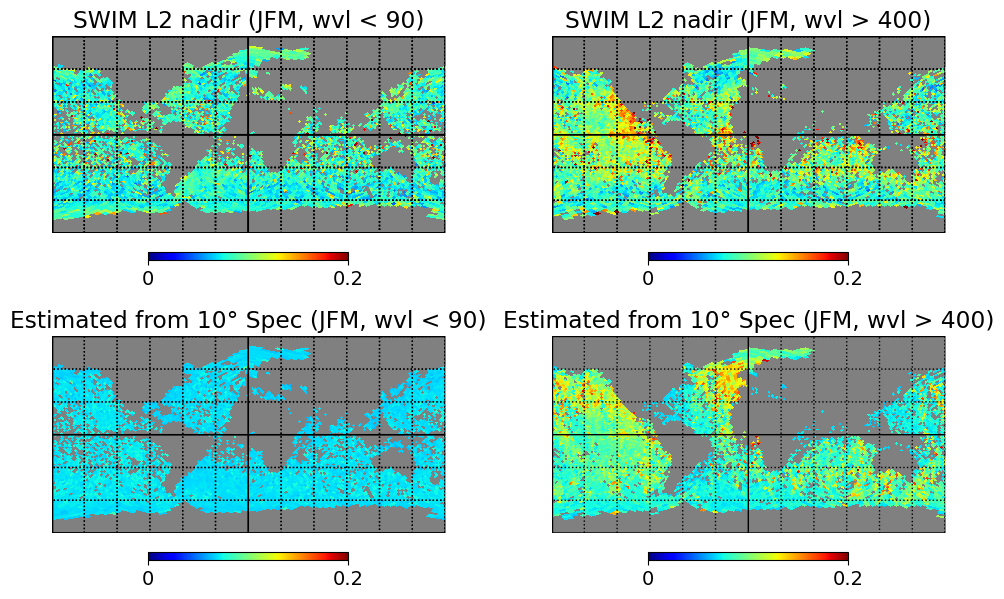

In [46]:
### case : std_HS / hs and intEnv_kc_withnoHs
Timemonth = np.array(Timemonth)#[indflag]
indfmax = np.argmax(SpecT,axis=-1)
NSIDE = 32
NPIX = hp.nside2npix(NSIDE)
m = np.random.uniform(size=NPIX)
pidx = hp.ang2pix(NSIDE,(90-LAT)*np.pi/180,-LOT*np.pi/180)
Hslim = 2
isint=0

conditions_stay = ((HSBoxT>Hslim)&(std_Hs_box>0))#&(WVLT>400))

X1 = std_Hs_box/HSBoxT#np.sqrt(int_env_kc)/HSBoxT
X2 = equiv_std_kc_T/HSBoxT#np.sqrt(int_env_kc)/HSBoxT#std_Hs_box/HSBoxB#np.sqrt(int_Env_kc_wihtnoHs)/HSBoxT
cmax1 = 0.2#None#0.22
cmax2 = 0.2

# --- JFM ----
ind = np.where((Timemonth>=1)&(Timemonth<=3)&conditions_stay&(WVLT<90))[0]
res= np.bincount(pidx[ind],weights=X1[ind],minlength=12*NSIDE**2)
nres = np.bincount(pidx[ind],minlength=12*NSIDE**2)
moy = res/nres
moy[nres==0]=hp.UNSEEN
# --- JJA ----
ind = np.where((Timemonth>=1)&(Timemonth<=3)&conditions_stay&(WVLT>400))[0]
res = np.bincount(pidx[ind],weights=X1[ind],minlength=12*NSIDE**2)
nres = np.bincount(pidx[ind],minlength=12*NSIDE**2)
moy2 = res/nres
moy2[nres==0]=hp.UNSEEN

# --- JFM ----
ind = np.where((Timemonth>=1)&(Timemonth<=3)&conditions_stay&(WVLT<90))[0]
res= np.bincount(pidx[ind],weights=X2[ind],minlength=12*NSIDE**2)
nres = np.bincount(pidx[ind],minlength=12*NSIDE**2)
moy3 = res/nres
moy3[nres==0]=hp.UNSEEN
# --- JJA ----
ind = np.where((Timemonth>=1)&(Timemonth<=3)&conditions_stay&(WVLT>400))[0]
res = np.bincount(pidx[ind],weights=X2[ind],minlength=12*NSIDE**2)
nres = np.bincount(pidx[ind],minlength=12*NSIDE**2)
moy4 = res/nres
moy4[nres==0]=hp.UNSEEN

fig = plt.figure()
plt.tight_layout()
hp.cartview(moy,cmap='jet',fig=fig,sub=221,title='SWIM L2 nadir (JFM, wvl < 90)',max=cmax1,min=0,margins=[0.05,0.05,0.05,0.05])#,max=0.15)#,max=0.004)
hp.graticule()

hp.cartview(moy2,cmap='jet',fig=fig,sub=222,title='SWIM L2 nadir (JFM, wvl > 400)',max=cmax1,min=0,margins=[0.05,0.05,0.05,0.05])#,max=0.15)#,max=0.06)
hp.graticule()

hp.cartview(moy3,cmap='jet',fig=fig,sub=223,title='Estimated from 10° Spec (JFM, wvl < 90)',max=cmax2,min=0,margins=[0.05,0.05,0.05,0.05])#,max=0.15)#,max=0.004)
hp.graticule()

hp.cartview(moy4,cmap='jet',fig=fig,sub=224,title='Estimated from 10° Spec (JFM, wvl > 400)',max=cmax2,min=0,margins=[0.05,0.05,0.05,0.05])#,max=0.06)
hp.graticule()
plt.savefig('carto_stdHs_divHs_Hsabove2_obs_vs_estimated_perwvl.png')

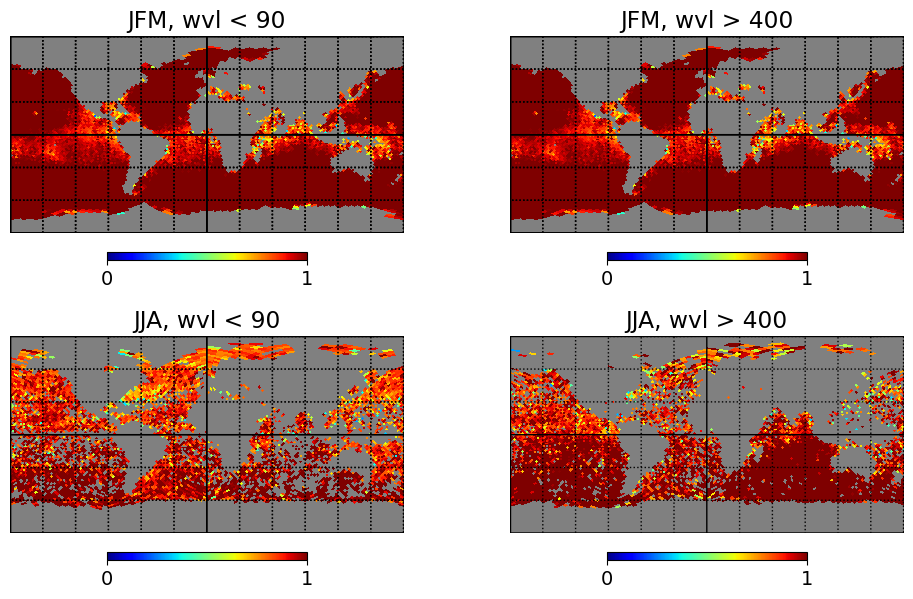

In [45]:
### case : estimated(std)/std_HS 
Timemonth = np.array(Timemonth)#[indflag]
indfmax = np.argmax(SpecT,axis=-1)
NSIDE = 32
NPIX = hp.nside2npix(NSIDE)
m = np.random.uniform(size=NPIX)
pidx = hp.ang2pix(NSIDE,(90-LAT)*np.pi/180,-LOT*np.pi/180)
Hslim = 2
isint = 0

conditions_stay = ((HSBoxT>Hslim)&(std_Hs_box>0))#&(WVLT>400))

X1 = equiv_std_kc_T/std_Hs_box#np.sqrt(int_env_kc)/HSBoxT
X2 = equiv_std_kc_T/std_Hs_box#np.sqrt(int_env_kc)/HSBoxT#std_Hs_box/HSBoxB#np.sqrt(int_Env_kc_wihtnoHs)/HSBoxT
cmax1 = 1#0.2#None#0.22
cmax2 = 1#.2#3.5#0.1#N

# --- JFM ----
ind = np.where((Timemonth>=1)&(Timemonth<=3)&(conditions_stay))[0]#&(WVLT<90))[0]
res= np.bincount(pidx[ind],weights=X1[ind],minlength=12*NSIDE**2)
nres = np.bincount(pidx[ind],minlength=12*NSIDE**2)
moy = res/nres
moy[nres==0]=hp.UNSEEN
# --- JJA ----
ind = np.where((Timemonth>=1)&(Timemonth<=3)&conditions_stay)[0]#&(WVLT>400))[0]
res = np.bincount(pidx[ind],weights=X1[ind],minlength=12*NSIDE**2)
nres = np.bincount(pidx[ind],minlength=12*NSIDE**2)
moy2 = res/nres
moy2[nres==0]=hp.UNSEEN

# --- JFM ----
ind = np.where((Timemonth>=6)&(Timemonth<9)&conditions_stay&(WVLT<90))[0]
res= np.bincount(pidx[ind],weights=X2[ind],minlength=12*NSIDE**2)
nres = np.bincount(pidx[ind],minlength=12*NSIDE**2)
moy3 = res/nres
moy3[nres==0]=hp.UNSEEN
# --- JJA ----
ind = np.where((Timemonth>=6)&(Timemonth<9)&(conditions_stay)&(WVLT>400))[0]
res = np.bincount(pidx[ind],weights=X2[ind],minlength=12*NSIDE**2)
nres = np.bincount(pidx[ind],minlength=12*NSIDE**2)
moy4 = res/nres
moy4[nres==0]=hp.UNSEEN

fig = plt.figure()
plt.tight_layout()
hp.cartview(moy,cmap='jet',fig=fig,sub=221,title='JFM, wvl < 90',max=cmax1,min=0,margins=[0.05,0.05,0.05,0.05])#,max=0.15)#,max=0.004)
hp.graticule()

hp.cartview(moy2,cmap='jet',fig=fig,sub=222,title='JFM, wvl > 400',max=cmax2,min=0,margins=[0.05,0.05,0.05,0.05])#,max=0.15)#,max=0.06)
hp.graticule()

hp.cartview(moy3,cmap='jet',fig=fig,sub=223,title='JJA, wvl < 90',max=cmax1,min=0,margins=[0.05,0.05,0.05,0.05])#,max=0.15)#,max=0.004)
hp.graticule()

hp.cartview(moy4,cmap='jet',fig=fig,sub=224,title='JJA, wvl > 400',max=cmax2,min=0,margins=[0.05,0.05,0.05,0.05])#,max=0.06)
hp.graticule()
plt.savefig('ratio_estimated_over_measured.png')

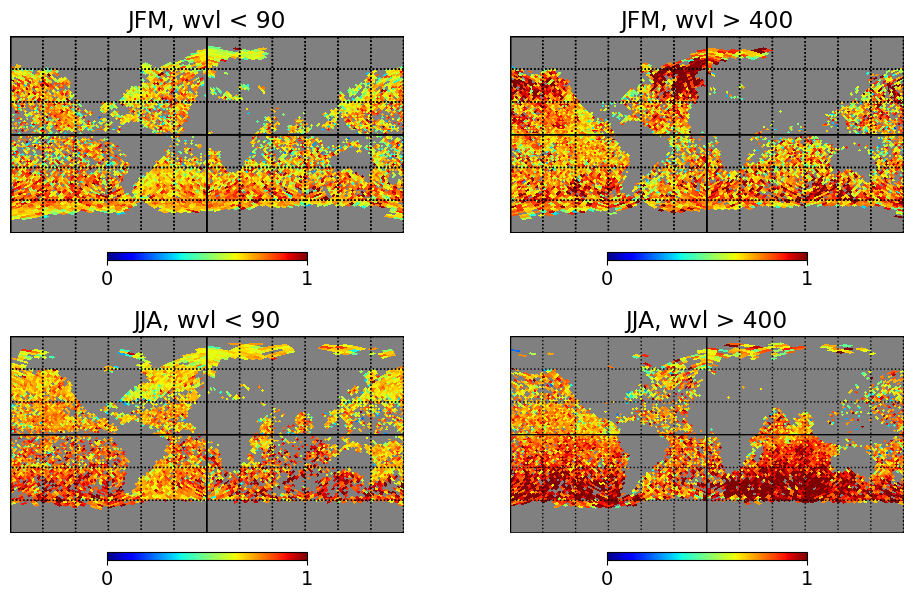

In [36]:
### case : estimated(std)/std_HS 
Timemonth = np.array(Timemonth)#[indflag]
indfmax = np.argmax(SpecT,axis=-1)
NSIDE = 32
NPIX = hp.nside2npix(NSIDE)
m = np.random.uniform(size=NPIX)
pidx = hp.ang2pix(NSIDE,(90-LAT)*np.pi/180,-LOT*np.pi/180)
Hslim = 2
isint = 0

conditions_stay = ((HSBoxT>Hslim)&(std_Hs_box>0))#&(WVLT>400))

X1 = equiv_std_kc_T/std_Hs_box#np.sqrt(int_env_kc)/HSBoxT
X2 = equiv_std_kc_T/std_Hs_box#np.sqrt(int_env_kc)/HSBoxT#std_Hs_box/HSBoxB#np.sqrt(int_Env_kc_wihtnoHs)/HSBoxT
cmax1 = 1#1.8#0.2#None#0.22
cmax2 = 1#3.5#0.1#N

# --- JFM ----
ind = np.where((Timemonth>=1)&(Timemonth<=3)&(conditions_stay)&(WVLT<90))[0]
arr = xr.Dataset(data_vars=dict(X=(["ind1"],X1[ind]),
            idx=(["ind1"],pidx[ind]),
            ),
        coords=dict(coord1=(["ind1"],ind),
            ),
        )
arrmed = arr.groupby('idx').median(skipna=False)

moy = np.zeros(NPIX)
moy[arrmed.idx] = arrmed.X
moy[moy==0]=hp.UNSEEN
# res= np.bincount(pidx[ind],weights=X1[ind],minlength=12*NSIDE**2)
# nres = np.bincount(pidx[ind],minlength=12*NSIDE**2)
# moy = res/nres
# moy[nres==0]=hp.UNSEEN
# --- JJA ----
ind = np.where((Timemonth>=1)&(Timemonth<=3)&conditions_stay&(WVLT>400))[0]
arr = xr.Dataset(data_vars=dict(X=(["ind1"],X1[ind]),
            idx=(["ind1"],pidx[ind]),
            ),
        coords=dict(coord1=(["ind1"],ind),
            ),
        )
arrmed = arr.groupby('idx').median(skipna=False)

moy2 = np.zeros(NPIX)
moy2[arrmed.idx] = arrmed.X
moy2[moy2==0]=hp.UNSEEN
# res = np.bincount(pidx[ind],weights=X1[ind],minlength=12*NSIDE**2)
# nres = np.bincount(pidx[ind],minlength=12*NSIDE**2)
# moy2 = res/nres
# moy2[nres==0]=hp.UNSEEN

# --- JFM ----
ind = np.where((Timemonth>=6)&(Timemonth<9)&conditions_stay&(WVLT<90))[0]
arr = xr.Dataset(data_vars=dict(X=(["ind1"],X2[ind]),
            idx=(["ind1"],pidx[ind]),
            ),
        coords=dict(coord1=(["ind1"],ind),
            ),
        )
arrmed = arr.groupby('idx').median(skipna=False)

moy3 = np.zeros(NPIX)
moy3[arrmed.idx] = arrmed.X
moy3[moy3==0]=hp.UNSEEN

# res = np.bincount(pidx[ind],weights=X2[ind],minlength=12*NSIDE**2)
# nres = np.bincount(pidx[ind],minlength=12*NSIDE**2)
# moy3 = res/nres
# moy3[nres==0]=hp.UNSEEN
# print(np.shape(moy3),NPIX)
# print(np.shape(moy),np.shape(pidx),np.amax(pidx))

# --- JJA ----
ind = np.where((Timemonth>=6)&(Timemonth<9)&(conditions_stay)&(WVLT>400))[0]
arr = xr.Dataset(data_vars=dict(X=(["ind1"],X2[ind]),
            idx=(["ind1"],pidx[ind]),
            ),
        coords=dict(coord1=(["ind1"],ind),
            ),
        )
arrmed = arr.groupby('idx').median(skipna=False)

moy4 = np.zeros(NPIX)
moy4[arrmed.idx] = arrmed.X
moy4[moy4==0]=hp.UNSEEN

# res = np.bincount(pidx[ind],weights=X2[ind],minlength=12*NSIDE**2)
# nres = np.bincount(pidx[ind],minlength=12*NSIDE**2)
# moy4 = res/nres
# moy4[nres==0]=hp.UNSEEN

fig = plt.figure()
plt.tight_layout()
hp.cartview(moy,cmap='jet',fig=fig,sub=221,title='JFM, wvl < 90',max=cmax1,min=0,margins=[0.05,0.05,0.05,0.05])#,max=0.15)#,max=0.004)
hp.graticule()

hp.cartview(moy2,cmap='jet',fig=fig,sub=222,title='JFM, wvl > 400',max=cmax2,min=0,margins=[0.05,0.05,0.05,0.05])#,max=0.15)#,max=0.06)
hp.graticule()

hp.cartview(moy3,cmap='jet',fig=fig,sub=223,title='JJA, wvl < 90',max=cmax1,min=0,margins=[0.05,0.05,0.05,0.05])#,max=0.15)#,max=0.004)
hp.graticule()

hp.cartview(moy4,cmap='jet',fig=fig,sub=224,title='JJA, wvl > 400',max=cmax2,min=0,margins=[0.05,0.05,0.05,0.05])#,max=0.06)
hp.graticule()
plt.savefig('ratio_estimated_over_measured_median_newLCs.png')

15 [2409. 2409. 2409. 2409. 2409. 2409. 2409. 2409. 2409. 2409. 2409. 2409.
 2409. 3874. 3874.]


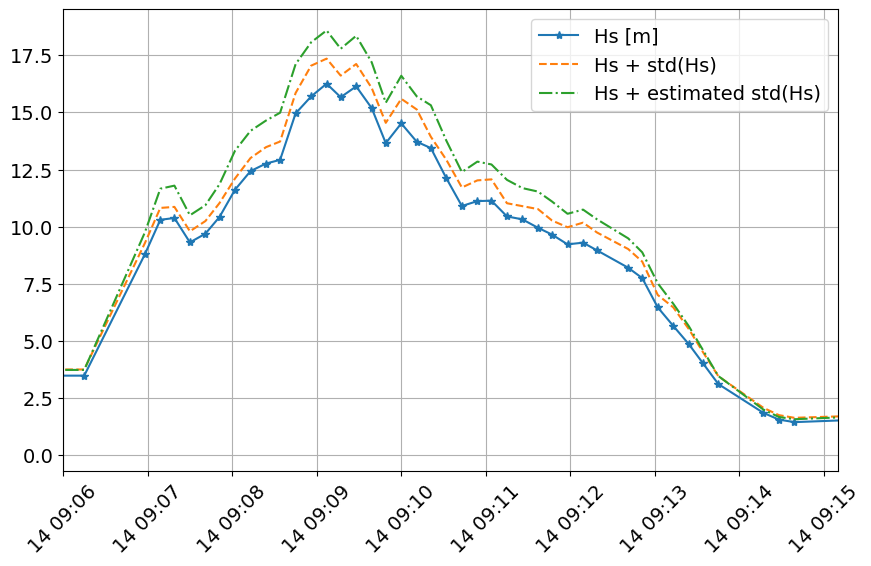

In [54]:
ind = np.where((time_l2_pd>pd.Timestamp('2020-02-14T09:05'))&(time_l2_pd<pd.Timestamp('2020-02-14T09:09')))[0]
print(len(ind),ind_track[ind])

ind= np.where(ind_track==2409)[0]
plt.plot(time_l2_pd[ind],HSBoxT[ind],'-*',label='Hs [m]')
plt.plot(time_l2_pd[ind],HSBoxT[ind]+std_Hs_box[ind],'--',label='Hs + std(Hs)')
plt.plot(time_l2_pd[ind],HSBoxT[ind]+equiv_std_kc_T[ind],'-.',label='Hs + estimated std(Hs)')

plt.xlim((np.datetime64('2020-02-14 09:06:00'),np.datetime64('2020-02-14 09:15:10')))
plt.xticks(rotation=45)
plt.legend()
plt.savefig('Case_study_withestimated_std_tobedividedby4.png')

In [36]:
arrmed.median(skipna=False)

<xarray.Dataset>
Dimensions:  (idx: 5654)
Coordinates:
  * idx      (idx) int64 57 58 75 76 79 81 ... 11759 11761 11762 11765 11824
Data variables:
    X        (idx) float64 0.9181 0.9349 0.765 0.8192 ... 0.8901 1.092 0.9729

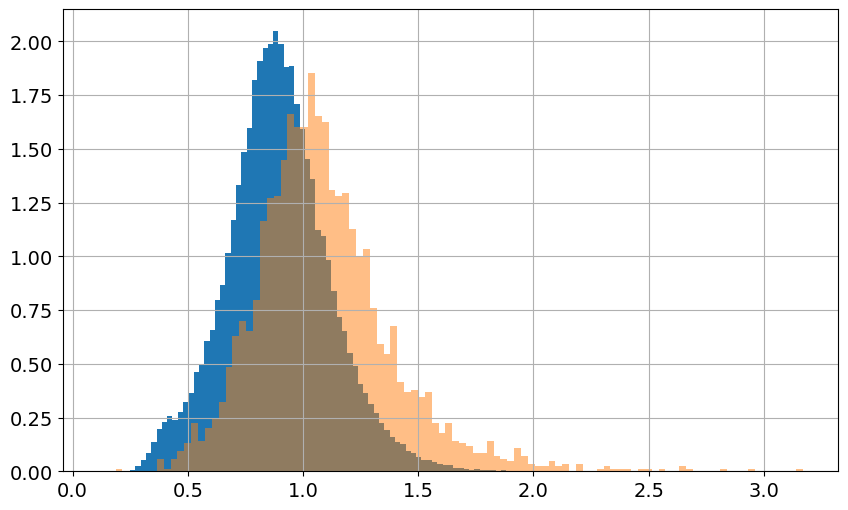

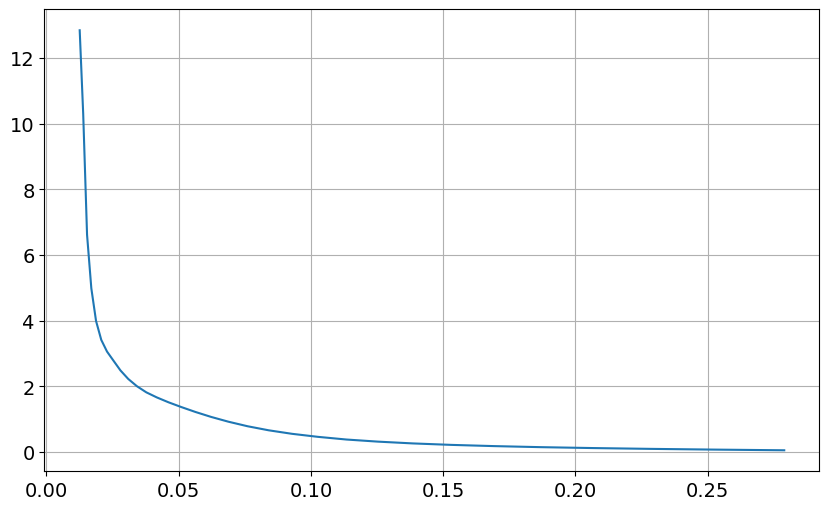

In [55]:
conditions_stay = ((HSBoxT>Hslim)&(std_Hs_box>0))#&(WVLT>400))
ratioT = equiv_std_kc_T/std_Hs_box#np.sqrt(int_env_kc)/HSBoxT
ind_short=np.where(conditions_stay&(WVLT<90))[0]
ind_long = np.where(conditions_stay&(WVLT>400)&(indfmax>2))[0]
ind_long_bad = np.where(conditions_stay&(WVLT>400)&(indfmax<=1))[0]
plt.hist(ratioT[ind_short],bins=100,density=True);
plt.hist(ratioT[ind_long],bins=100,density=True,alpha=0.5);

plt.figure()
plt.plot(k_vec,np.mean(SpecT[ind_long_bad,:].T/HSBoxT[ind_long_bad],axis=1));

In [88]:
print(len(ind_long_bad))

81526


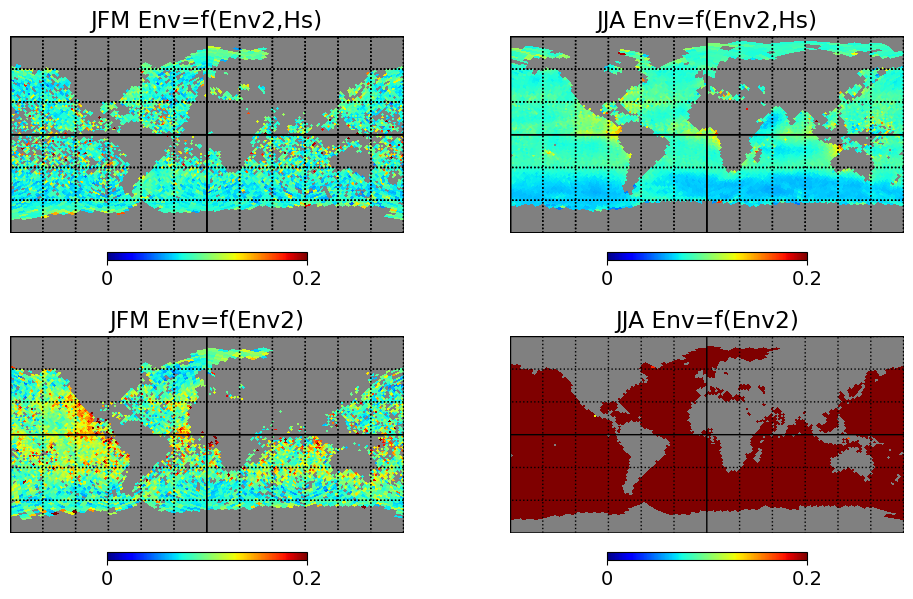

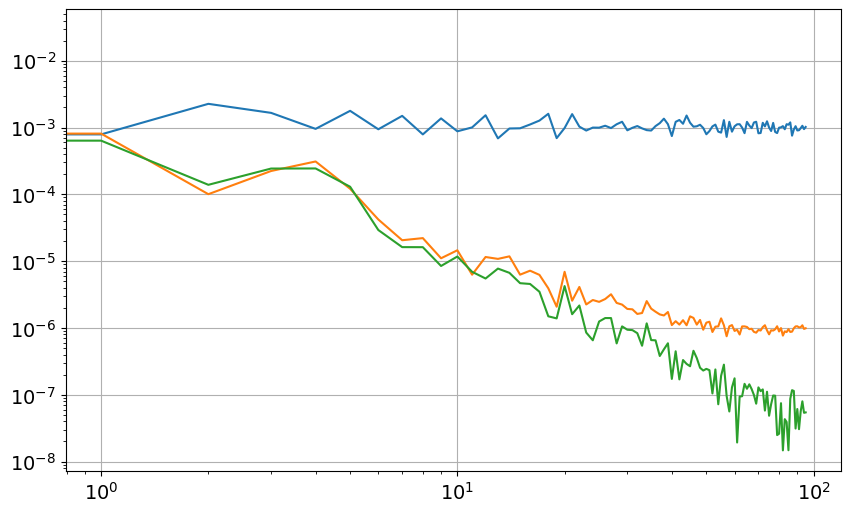

In [163]:
### case : std_HS / hs and intEnv_kc_withnoHs

indfmax = np.argmax(SpecT,axis=-1)
NSIDE = 32
NPIX = hp.nside2npix(NSIDE)
m = np.random.uniform(size=NPIX)
pidx = hp.ang2pix(NSIDE,(90-LAT)*np.pi/180,-LOT*np.pi/180)
Hslim = 2
isint=0

X1 = std_Hs_box/HSBoxT#np.sqrt(int_env_kc)/HSBoxT
X2 = int_Env_kc_wihtnoHs_div_HS#np.sqrt(int_env_kc)/HSBoxT#std_Hs_box/HSBoxB#np.sqrt(int_Env_kc_wihtnoHs)/HSBoxT
cmax1 = 0.2#None#0.22
cmax2 = 0.2#N


if isint:
    X1 = int_env_kc
    X2 = int_Env_kc_wihtnoHs
    cmax1 = 0.05
    cmax2 = 0.025
else:
    X1 = std_Hs_box/HSBoxT#np.sqrt(int_env_kc)/HSBoxT
    X2 = int_Env_kc_wihtnoHs_div_HS/(std_Hs_box/HSBoxT)#np.sqrt(int_env_kc)/HSBoxT#std_Hs_box/HSBoxB#np.sqrt(int_Env_kc_wihtnoHs)/HSBoxT
    cmax1 = 0.2#None#0.22
    cmax2 = 0.2#None#0.1#None#
#Timemonth = np.array(Timemonth)[indflag]
# Time2 = np.array(Time2)[indflag]

# --- JFM ----
ind = np.where((Timemonth>=1)&(Timemonth<=3)&(HSBoxT>Hslim)&(std_Hs_box>0))[0]#&(indfmax>=1))[0]#
ind = np.where((Timemonth>=1)&(Timemonth<=3)&(HSBoxT>Hslim)&(std_Hs_box>0)&(WVLT<90))[0]
# ind = np.where((Time2>=pd.Timestamp('2021-01-01'))&(Time2<=pd.Timestamp('2021-01-15')))[0]
res= np.bincount(pidx[ind],weights=X1[ind],minlength=12*NSIDE**2)
nres = np.bincount(pidx[ind],minlength=12*NSIDE**2)
moy = res/nres
moy[nres==0]=hp.UNSEEN
# --- JJA ----
ind = np.where((Timemonth>=6)&(Timemonth<=9)&(HSBoxT>Hslim)&(std_Hs_box>0))[0]
res = np.bincount(pidx[ind],weights=X1[ind],minlength=12*NSIDE**2)
nres = np.bincount(pidx[ind],minlength=12*NSIDE**2)
moy2 = res/nres
moy2[nres==0]=hp.UNSEEN

# --- JFM ----
ind = np.where((Timemonth>=1)&(Timemonth<=3)&(HSBoxT>Hslim)&(std_Hs_box>0)&(indfmax>=2))[0]
ind = np.where((Timemonth>=1)&(Timemonth<=3)&(HSBoxT>Hslim)&(std_Hs_box>0)&(WVLT>400))[0]
res= np.bincount(pidx[ind],weights=X1[ind],minlength=12*NSIDE**2)
nres = np.bincount(pidx[ind],minlength=12*NSIDE**2)
moy3 = res/nres
moy3[nres==0]=hp.UNSEEN
# --- JJA ----
ind = np.where((Timemonth>=1)&(Timemonth<=3)&(HSBoxT>Hslim)&(std_Hs_box>0))[0]
res = np.bincount(pidx[ind],weights=X2[ind],minlength=12*NSIDE**2)
nres = np.bincount(pidx[ind],minlength=12*NSIDE**2)
moy4 = res/nres
moy4[nres==0]=hp.UNSEEN

fig = plt.figure()
plt.tight_layout()
hp.cartview(moy,cmap='jet',fig=fig,sub=221,title='JFM Env=f(Env2,Hs)',max=cmax1,min=0,margins=[0.05,0.05,0.05,0.05])#,max=0.15)#,max=0.004)
hp.graticule()

hp.cartview(moy2,cmap='jet',fig=fig,sub=222,title='JJA Env=f(Env2,Hs)',max=cmax1,min=0,margins=[0.05,0.05,0.05,0.05])#,max=0.15)#,max=0.06)
hp.graticule()

hp.cartview(moy3,cmap='jet',fig=fig,sub=223,title='JFM Env=f(Env2)',max=cmax2,min=0,margins=[0.05,0.05,0.05,0.05])#,max=0.15)#,max=0.004)
hp.graticule()

hp.cartview(moy4,cmap='jet',fig=fig,sub=224,title='JJA Env=f(Env2)',max=cmax2,min=0,margins=[0.05,0.05,0.05,0.05])#,max=0.06)
hp.graticule()



plt.figure()
cl= hp.anafast(moy)
cl0 = hp.anafast(np.random.randn(12*NSIDE**2))
cl2= hp.anafast(moy,map2=moy2)

plt.plot(cl0)
plt.plot(cl)
plt.plot(cl2)
plt.xscale('log')
plt.yscale('log')

In [6]:
# Spectral manipulation Normalized and go to f 
dkvec_2D = np.broadcast_to(dk_vec,(SpecT.shape))

SpecSum = np.nansum(SpecT*dkvec_2D,axis=1)

SpecSum2D = np.broadcast_to(SpecSum,(SpecT.T.shape)).T
SpecN = SpecT/SpecSum2D
print(SpecN.shape)
SpecN[np.isnan(SpecN)]=0

Spec_f,f_vec = spectrum_k_to_f(SpecT,k_vec)
SpecN_f,f_vec = spectrum_k_to_f(SpecN,k_vec)
df_vec =np.gradient(f_vec)

(4292293, 32)


In [216]:
Hslims = np.linspace(0.5,10,15)
rvals= np.zeros((len(Hslims),2))
slops = np.zeros((len(Hslims),2))
for ih, Hslim in enumerate(Hslims):
    reslow = stats.linregress(x[HSBoxT<Hslim],y[HSBoxT<Hslim])
    reshigh = stats.linregress(x[HSBoxT>Hslim],y[HSBoxT>Hslim])
    rvals[ih,0]=reslow.rvalue
    rvals[ih,1]=reshigh.rvalue
    slops[ih,1]=reshigh.slope
    slops[ih,0]=reslow.slope
print(np.shape(rvals[:,1]))
print(Hslims)

(15,)
[ 0.5         1.17857143  1.85714286  2.53571429  3.21428571  3.89285714
  4.57142857  5.25        5.92857143  6.60714286  7.28571429  7.96428571
  8.64285714  9.32142857 10.        ]


In [181]:
T = 10
k = 4* np.pi**2 * (1/T)**2 /9.81

wvl = 2*np.pi/k
print(wvl)

156.1309991731493


2.799271 2.4397085


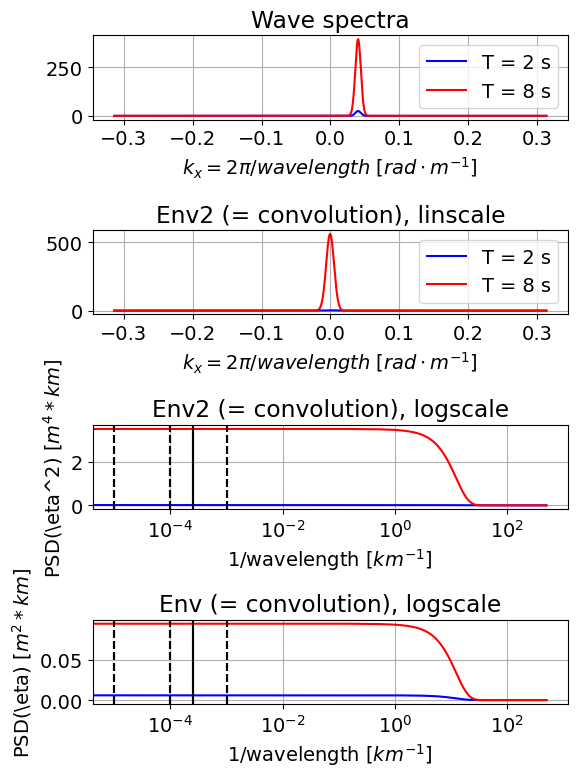

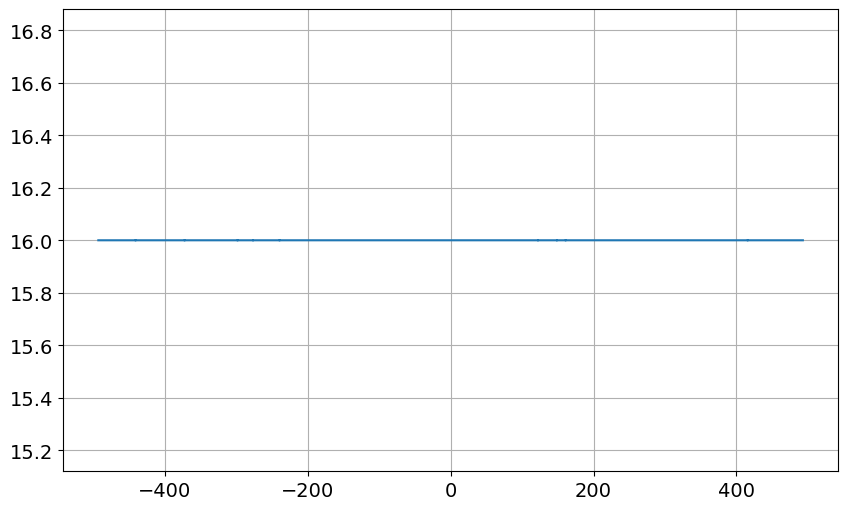

In [50]:
# ---- theoretical example -------------
fig,axs=plt.subplots(4,1,figsize=(6,8))
LC = 4000
klim = 2*np.pi/LC
cols=['b','r']
Envs = np.zeros((2501,2))
for it1, T1 in enumerate([2, 8]):
    specex,kvec2,c = def_spectrumG_for_surface_1D(nx=2048,Hs=T1)

    kvecnew = np.linspace(kvec2[0],kvec2[-1],2501)

    x = specex
    f = spi.interp1d(kvec2,x)
    xnew = f(kvecnew)

    B2 = 2*np.fft.fftshift(myconv(0.5*xnew,0.5*np.flip(xnew)))*np.gradient(kvecnew)
    sumB2 = np.sum(B2*np.gradient(kvecnew))

    convol_B_func = spi.interp1d(kvecnew,B2)
    intB = spint.quad_vec(convol_B_func,-klim,klim)[0]
    
    axs[0].plot(kvec2,x,color=cols[it1],label='T = '+str(T1)+' s')
    axs[0].set_title('Wave spectra')
    axs[0].set_xlabel('$k_x = 2 \pi/wavelength$ [$rad \cdot m^{-1}$]')
    axs[0].legend()
#     axs[0].set_yscale('log')
#     axs[0].set
    axs[1].plot(kvecnew,B2,color=cols[it1],label='T = '+str(T1)+' s')
    axs[1].legend()
#     axs[1].set_yscale('log')
    axs[1].set_xlabel('$k_x = 2 \pi/wavelength$ [$rad \cdot m^{-1}$]')
    axs[1].set_title('Env2 (= convolution), linscale')
#     axs[2].plot(kvecnew/2*np.pi,A-A2,'-*',label='Conv tot Spec2')
    # axs[3].plot(kvec2[len(x)//2-len(x)//4:len(x)//2+len(x)//4],B,'--',label='B')
    # axs[3].plot(kvec2,B,'--',label='B')
    axs[2].plot(kvecnew*1000/2*np.pi,B2*np.pi/500,'-',color=cols[it1],label='T = '+str(T1)+' s')
#     axs[2].set_yscale('log')
    axs[2].set_xscale('log')
    axs[2].axvline(1/4000,color='k')
    axs[2].axvline(1/1000,linestyle='--',color='k')
    axs[2].axvline(1/10000,linestyle='--',color='k')
    axs[2].axvline(1/100000,linestyle='--',color='k')
    axs[2].set_xlabel('1/wavelength [$km^{-1}$]')
    axs[2].set_ylabel('PSD(\eta^2) [$m^4 * km$]')
    axs[2].set_title('Env2 (= convolution), logscale')
    
    axs[3].plot(kvecnew*1000/2*np.pi,((B2*2*(4-np.pi)/T1**2))*np.pi/500,'-',color=cols[it1],label='T = '+str(T1)+' s')
#     axs[2].set_yscale('log')
    axs[3].set_xscale('log')
    axs[3].axvline(1/4000,color='k')
    axs[3].axvline(1/1000,linestyle='--',color='k')
    axs[3].axvline(1/10000,linestyle='--',color='k')
    axs[3].axvline(1/100000,linestyle='--',color='k')
    axs[3].set_xlabel('1/wavelength [$km^{-1}$]')
    axs[3].set_ylabel('PSD(\eta) [$m^2 * km$]')
    axs[3].set_title('Env (= convolution), logscale')
    Envs[:,it1]= ((B2*2*(4-np.pi)/T1**2))*np.pi/500
# axs[3].axvline(2*np.pi/4000)
# axs[3].axvline(2*np.pi/1000,linestyle='--')
# axs[3].axvline(2*np.pi/10000,linestyle='--')
# axs[3].axvline(2*np.pi/100000,linestyle='--')

plt.tight_layout()
plt.figure()

plt.plot(kvecnew*1000/2*np.pi,Envs[:,1]/Envs[:,0])
print(np.mean(HSBoxT),np.median(HSBoxT))
# axs[3].legend()
# raisonnement : |F(zeta)| = |F(zeta)|_- + |F(zeta)|+
# 2*|F(zeta)|_+ = |F(zeta)|obs
# |F(zeta)|_+ = |F(zeta)|_- = 0.5*|F(zeta)|_obs

# |F(zeta)|*|F(zeta)| - remove(F(zeta)) = 2*(|F(zeta)|_+ * |F(zeta)|_-) perché ?

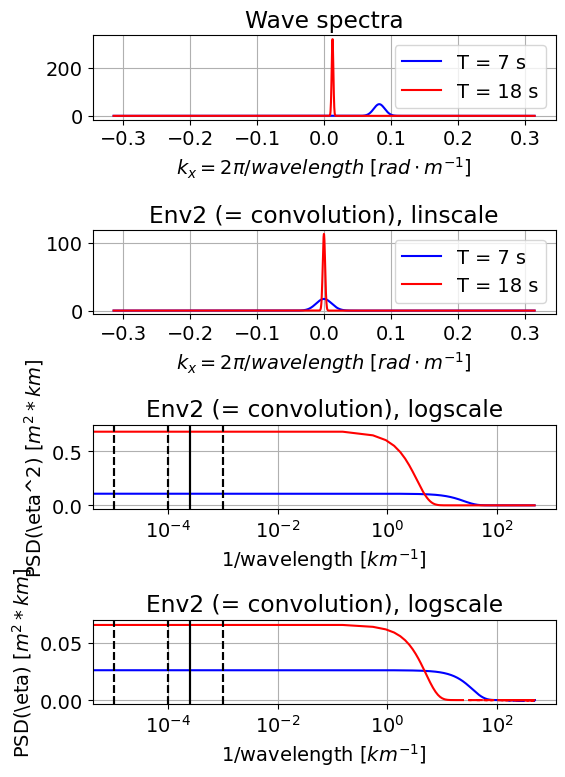

In [51]:
fig,axs=plt.subplots(4,1,figsize=(6,8))
LC = 4000
klim = 2*np.pi/LC
cols=['b','r']
for it1, T1 in enumerate([7, 18]):
    specex,kvec2,c = def_spectrumG_for_surface_1D(nx=2048,T0=T1)

    kvecnew = np.linspace(kvec2[0],kvec2[-1],2501)

    x = specex
    f = spi.interp1d(kvec2,x)
    xnew = f(kvecnew)

    B2 = 2*np.fft.fftshift(myconv(0.5*xnew,0.5*np.flip(xnew)))*np.gradient(kvecnew)
    sumB2 = np.sum(B2*np.gradient(kvecnew))

    convol_B_func = spi.interp1d(kvecnew,B2)
    intB = spint.quad_vec(convol_B_func,-klim,klim)[0]
    
    axs[0].plot(kvec2,x,color=cols[it1],label='T = '+str(T1)+' s')
    axs[0].set_title('Wave spectra')
    axs[0].set_xlabel('$k_x = 2 \pi/wavelength$ [$rad \cdot m^{-1}$]')
    axs[0].legend()
#     axs[0].set_yscale('log')
#     axs[0].set
    axs[1].plot(kvecnew,B2,color=cols[it1],label='T = '+str(T1)+' s')
    axs[1].legend()
#     axs[1].set_yscale('log')
    axs[1].set_xlabel('$k_x = 2 \pi/wavelength$ [$rad \cdot m^{-1}$]')
    axs[1].set_title('Env2 (= convolution), linscale')
#     axs[2].plot(kvecnew/2*np.pi,A-A2,'-*',label='Conv tot Spec2')
    # axs[3].plot(kvec2[len(x)//2-len(x)//4:len(x)//2+len(x)//4],B,'--',label='B')
    # axs[3].plot(kvec2,B,'--',label='B')
    axs[2].plot(kvecnew*1000/2*np.pi,B2*np.pi/500,'-',color=cols[it1],label='T = '+str(T1)+' s')
#     axs[2].set_yscale('log')
    axs[2].set_xscale('log')
    axs[2].axvline(1/4000,color='k')
    axs[2].axvline(1/1000,linestyle='--',color='k')
    axs[2].axvline(1/10000,linestyle='--',color='k')
    axs[2].axvline(1/100000,linestyle='--',color='k')
    axs[2].set_xlabel('1/wavelength [$km^{-1}$]')
    axs[2].set_ylabel('PSD(\eta^2) [$m^2 * km$]')
    axs[2].set_title('Env2 (= convolution), logscale')
    
    axs[3].plot(kvecnew*1000/2*np.pi,np.sqrt(B2)*np.pi/500,'-',color=cols[it1],label='T = '+str(T1)+' s')
#     axs[2].set_yscale('log')
    axs[3].set_xscale('log')
    axs[3].axvline(1/4000,color='k')
    axs[3].axvline(1/1000,linestyle='--',color='k')
    axs[3].axvline(1/10000,linestyle='--',color='k')
    axs[3].axvline(1/100000,linestyle='--',color='k')
    axs[3].set_xlabel('1/wavelength [$km^{-1}$]')
    axs[3].set_ylabel('PSD(\eta) [$m^2 * km$]')
    axs[3].set_title('Env2 (= convolution), logscale')
    
# axs[3].axvline(2*np.pi/4000)
# axs[3].axvline(2*np.pi/1000,linestyle='--')
# axs[3].axvline(2*np.pi/10000,linestyle='--')
# axs[3].axvline(2*np.pi/100000,linestyle='--')

plt.tight_layout()
# axs[3].legend()
# raisonnement : |F(zeta)| = |F(zeta)|_- + |F(zeta)|+
# 2*|F(zeta)|_+ = |F(zeta)|obs
# |F(zeta)|_+ = |F(zeta)|_- = 0.5*|F(zeta)|_obs

# |F(zeta)|*|F(zeta)| - remove(F(zeta)) = 2*(|F(zeta)|_+ * |F(zeta)|_-) perché ?

Hs =  8.328012


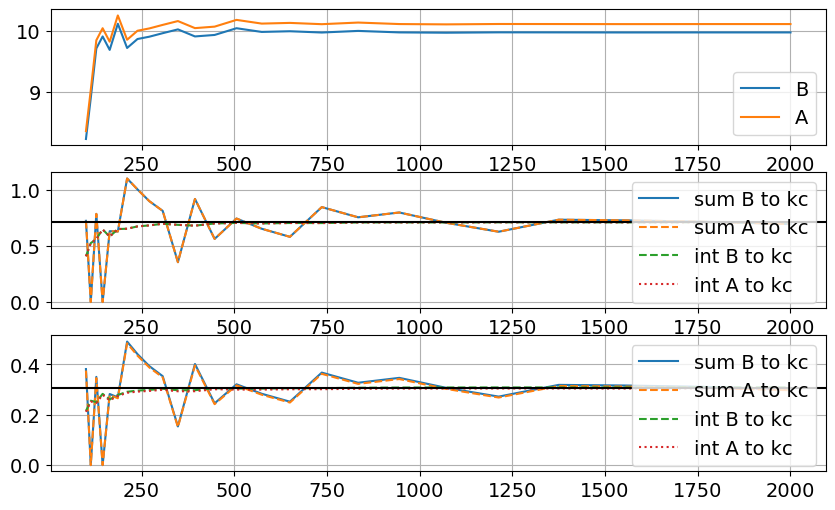

In [52]:
# specex,kvec2,c = def_spectrumG_for_surface_1D(nx=2048,T0=10,sk_k0=0.65)
kvec2=np.concatenate([-k_vec[::-1],np.zeros(1),k_vec])#,np.zeros(1),k_vec])
k2 = np.logspace(-5,np.log10(k_vec[-1]),100)
inds=np.where(HSBoxT>8)[0][0]
print('Hs = ',HSBoxT[inds])
x = np.concatenate([np.zeros(33),SpecT[inds]])
f = spi.interp1d(kvec2,x)

Ns = np.floor(np.logspace(2,np.log10(2000),25)).astype(int)#[100,200,300,500,1000,2000]
LC = 4000
klim= 2*np.pi/LC

sumBs = np.zeros(len(Ns))
sumAs = np.zeros(len(Ns))
sumBparts = np.zeros(len(Ns))
sumAparts = np.zeros(len(Ns))
intAfrom_funcs = np.zeros(len(Ns))
intBfrom_funcs = np.zeros(len(Ns))

for iin,N in enumerate(Ns):
    # kvecnew= np.concatenate([-k2[::-1],np.zeros(1),k2])
    kvecnew = np.linspace(kvec2[0],kvec2[-1],N+1)
    xnew = f(kvecnew)

    lbd = 0.5
    x2 = lbd*xnew+(1-lbd)*xnew[::-1]
    A = np.fft.fftshift(myconv(x2,x2))*np.gradient(kvecnew)
    A2 = remove_part(x2,x2,np.gradient(kvecnew))
    A3 = (A-A2)*np.gradient(kvecnew)
    B = 2*np.fft.fftshift(myconv(0.5*xnew,0.5*np.flip(xnew)))*np.gradient(kvecnew)
    B2 = B*np.gradient(kvecnew)

    sumBs[iin] = np.sum(B2)
    sumAs[iin] = np.sum(A3)

    sumBparts[iin] = np.sum(B2[np.abs(kvecnew)<=klim])
    sumAparts[iin] = np.sum(A3[np.abs(kvecnew)<=klim])

    convol_A_func = spi.interp1d(kvecnew,(A-A2))
    convol_B_func = spi.interp1d(kvecnew,B)

    intAfrom_funcs[iin] = spint.quad(convol_A_func,-klim,klim)[0]
    intBfrom_funcs[iin] = spint.quad(convol_B_func,-klim,klim)[0]

#     print('var env2 B = ',sumB,'var env2 B2 = ',sumB2,', var env2 A = ',sumA)
#     print('var eta = ',HSBoxT[inds]**2/16)
#     print('ratio(var(env2)/var(eta)) B = ',sumB*16/HSBoxT[inds]**2)
#     print('ratio(var(env2)/var(eta)) A = ',sumA*16/HSBoxT[inds]**2)
#     print('ratio th = ', HSBoxT[inds]**2/4)

fig,axs = plt.subplots(3,1)
axs[0].plot(Ns,sumBs,label='B')
axs[0].plot(Ns,sumAs,label='A')
axs[0].legend()

axs[1].plot(Ns,sumBparts,label='sum B to kc')
axs[1].plot(Ns,sumAparts,'--',label='sum A to kc')
axs[1].plot(Ns,intBfrom_funcs,'--',label='int B to kc')
axs[1].plot(Ns,intAfrom_funcs,':',label='int A to kc')
axs[1].axhline(intAfrom_funcs[-1],color='k')
axs[1].legend()

axs[2].plot(Ns,sumBparts*HSBoxT[inds]**2/(16*sumBs),label='sum B to kc')
axs[2].plot(Ns,sumAparts*HSBoxT[inds]**2/(16*sumAs),'--',label='sum A to kc')
axs[2].plot(Ns,intBfrom_funcs*HSBoxT[inds]**2/(16*sumBs),'--',label='int B to kc')
axs[2].plot(Ns,intAfrom_funcs*HSBoxT[inds]**2/(16*sumAs),':',label='int A to kc')
axs[2].axhline(intAfrom_funcs[-1]*HSBoxT[inds]**2/(16*sumAs[-1]),color='k')
axs[2].legend()
# raisonnement : |F(zeta)| = |F(zeta)|_- + |F(zeta)|+
# 2*|F(zeta)|_+ = |F(zeta)|obs
# |F(zeta)|_+ = |F(zeta)|_- = 0.5*|F(zeta)|_obs

# |F(zeta)|*|F(zeta)| - remove(F(zeta)) = 2*(|F(zeta)|_+ * |F(zeta)|_-) perché ?

(64,)


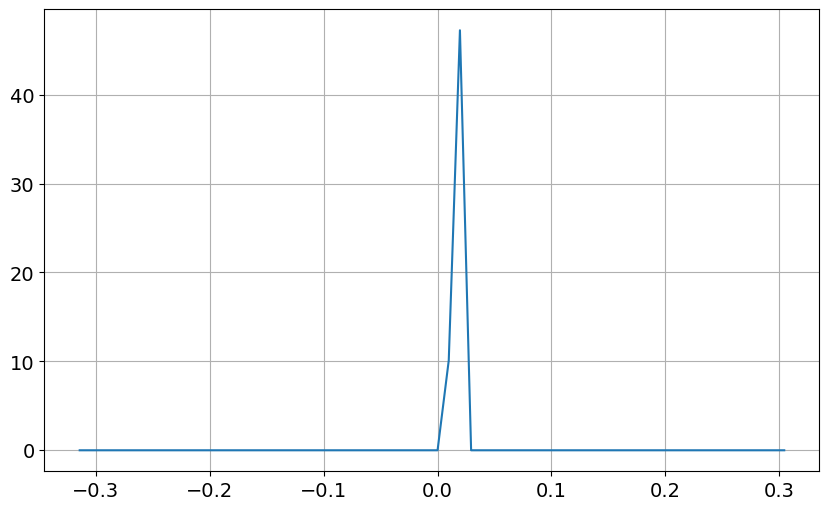

In [80]:
a,b,c = def_spectrumG_for_surface_1D(nx=64,T0=16,sk_k0=0.16);
plt.plot(b,a)
print(np.shape(a))

In [ ]:
SpecT
dkx = xr.DataArray(np.gradient(Ekxky_da.kx), dims="kx")
    dky = xr.DataArray(np.gradient(Ekxky_da.ky), dims="ky")
    Ekx_order = (Ekxky_da*dky).sum(dim='ky')
    # ---- single-siding ------------
    Ekx_order2 = Ekx_order.copy(deep=True)
    Ekx_order2.values = np.flip(Ekx_order2,axis=np.where(np.array(Ekx_order2.dims)=='kx')[0])
    Ekx_order = (Ekx_order2+Ekx_order).where(Ekx_order.kx>=0,0) # half is taken by taking only kx>0
    
    Ekx_ishift = np.fft.ifftshift(Ekx_order)
    kX_ishift = np.fft.ifftshift(Ekx_order.kx)

    conv_1Da_ishift  = 4*myconv(Ekx_ishift ,np.flip(Ekx_ishift,axis=np.where(np.array(Ekx_order.dims)=='kx')[0]) )*dkx
    conv_1Da_order = np.fft.fftshift(conv_1Da_ishift)
    
    convol_order = xr.DataArray(conv_1Da_order, dims="kx",coords={"kx":Ekx_order.kx})

    return convol_order,Ekx_order,dkx

In [129]:
print(Time1)

['2077-01-19T03:14:07.000000000' '2022-03-31T08:22:44.000000000'
 '2022-03-31T08:22:55.000000000' ... '2021-05-11T12:52:48.000000000'
 '2021-05-11T12:52:58.000000000' '2021-05-11T12:53:05.000000000']


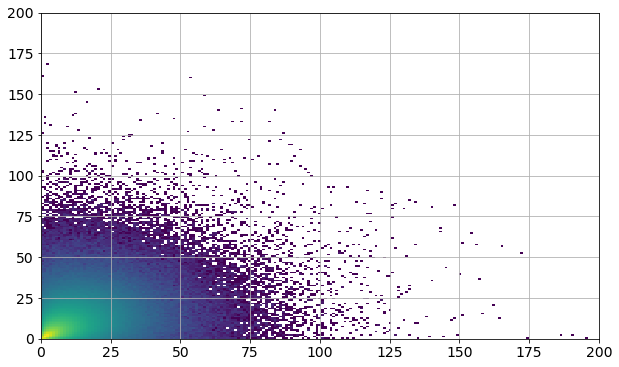

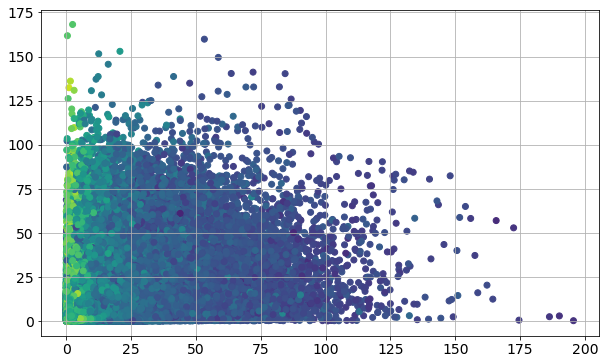

In [8]:
# plot var(env^2)/var(env)
His,x,y = np.histogram2d(HSBoxT**2/(2*(4-np.pi)),(MRV_T),bins=np.linspace(0,200,200))
plt.pcolormesh(x,y,np.log10(His).T)
plt.grid(True)
diff_theory = np.abs((HSBoxT**2/(2*(4-np.pi)))-(MRV_T))/(0.5*((HSBoxT**2/(2*(4-np.pi)))+(MRV_T)))
orderdiff = 
plt.figure()
plt.scatter(HSBoxT**2/(2*(4-np.pi)),MRV_T,c=spread_f_T)

In [8]:
k_vec2D=np.broadcast_to(k_vec,(Spec.shape))
# df_vec = np.gradient(f_vec)
# dfvec_2D=np.broadcast_to(df_vec,(Spec.shape))
print(Spec.shape)
SpecSum = np.nansum(Spec*dkvec_2D,axis=1)

cumSum = np.cumsum(k_vec2D*Spec *dkvec_2D,axis=1)
kappa3 = 12*np.nansum(cumSum*Spec *dkvec_2D,axis=1)

kappa4 = 48*2*2*np.nansum(cumSum*cumSum*Spec *dkvec_2D,axis=1)

lambda3 = kappa3/SpecSum**(3/2)
lambda4 = kappa4/SpecSum**2

varenv2 = 2*SpecSum**2*(2+lambda4)
varenv = (SpecSum*(4-np.pi)/2)-(SpecSum*np.pi*5*lambda3**2/192)+(SpecSum*np.pi*lambda4/(32))

(4292293, 32)


In [6]:
# --- variables from datarmor  -------------------
files_compute = list(py_files(PATH_BDD+'datarmor/',suffix='.npy'))
for f in files_compute:
    exec(f.split('/')[-1][:-4]+' = np.load("'+f+'",allow_pickle=True)')

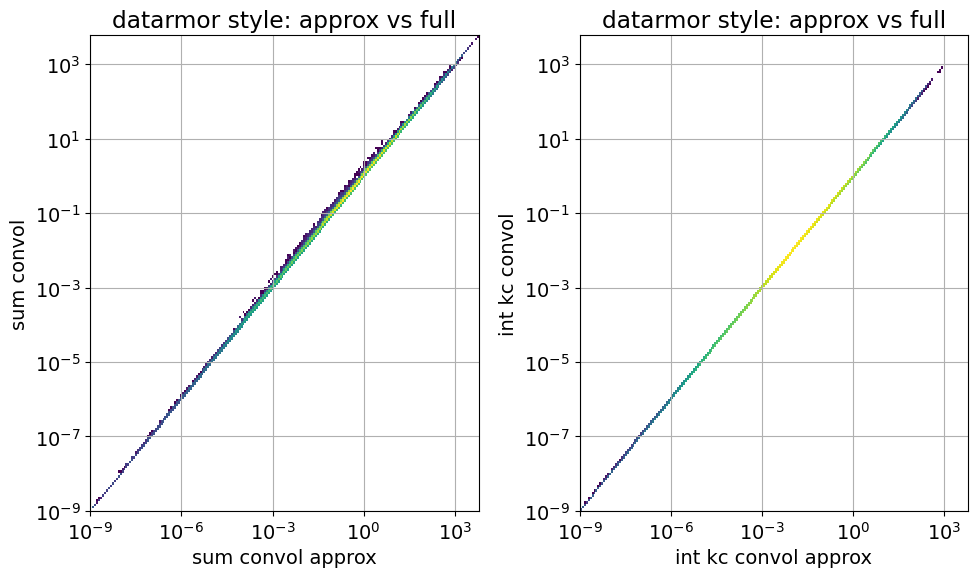

In [75]:
# --- Comparison for-loop datarmor vs matrix-style
fig,axs = plt.subplots(1,2)
His,x,y = np.histogram2d(sum_tot_BT,sum_tot_AT,bins=[np.logspace(-9,np.log10(6000),200),
                                                             np.logspace(-9,np.log10(6000),201)])
axs[0].pcolormesh(x,y,np.log10(His).T)
axs[0].set_xscale('log')
axs[0].set_yscale('log')
axs[0].set_xlabel('sum convol approx')
axs[0].set_ylabel('sum convol')
axs[0].set_title('datarmor style: approx vs full')
axs[0].grid(True)
His,x,y = np.histogram2d(int_klim_BT,int_klim_AT,bins=[np.logspace(-9,np.log10(6000),200),
                                                             np.logspace(-9,np.log10(6000),201)])
axs[1].pcolormesh(x,y,np.log10(His).T)
# axs[0,1].plot(int_klim_BT,int_klim_AT,'.')
axs[1].set_xscale('log')
axs[1].set_yscale('log')
axs[1].set_xlabel('int kc convol approx')
axs[1].set_ylabel('int kc convol')
axs[1].set_title('datarmor style: approx vs full')
axs[1].grid(True)


plt.tight_layout()

In [9]:
k_vec2D=np.broadcast_to(k_vec,(Spec.shape))
df_vec = np.gradient(f_vec)
dfvec_2D=np.broadcast_to(df_vec,(Spec.shape))
print(Spec.shape)
SpecSum = np.nansum(Spec_f*dfvec_2D,axis=1)

cumSum = np.cumsum(k_vec2D*Spec_f *dfvec_2D,axis=1)
cumSumR = k_vec2D*np.cumsum(Spec_f[:,::-1] *dfvec_2D[:,::-1],axis=1)


# kappa3 = 12*np.nansum(cumSum*Spec_f *dfvec_2D,axis=1)
kappa3 = 6*np.nansum((cumSum+cumSumR)*Spec_f *dfvec_2D,axis=1)

# kappa4 = 48*2*2*np.nansum(cumSum*cumSum*Spec_f *dfvec_2D,axis=1)
kappa4 = 48*np.nansum((cumSum+cumSumR)*(cumSum+cumSumR)*Spec_f *dfvec_2D,axis=1)


lambda3 = kappa3/(SpecSum**(3/2))
lambda4 = kappa4/(SpecSum**2)

varenv2_f = 2*SpecSum**2*(2+lambda4)
varenv_f = (SpecSum*(4-np.pi)/2)-(SpecSum*np.pi*5*(lambda3**2)/192)+(SpecSum*np.pi*lambda4/(32))

(4292293, 32)


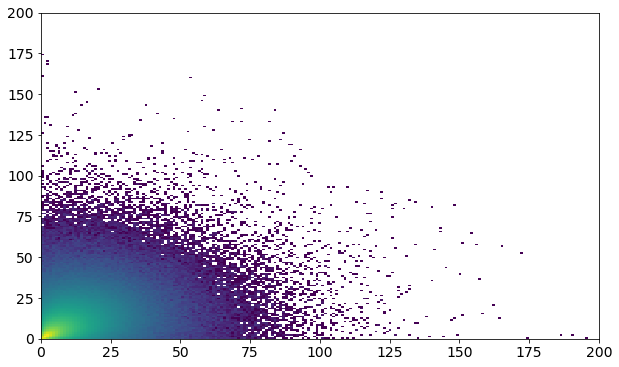

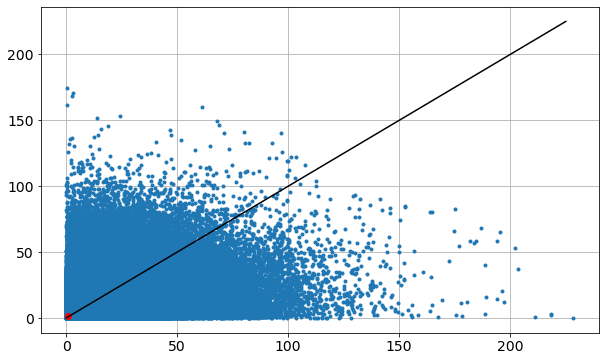

In [29]:
His,x,y = np.histogram2d(HSBoxT**2/(2*(4-np.pi)),(MRV_T[indflagT]),bins=np.linspace(0,200,200))
plt.pcolormesh(x,y,np.log10(His).T)#(HSBoxT**2/(2*(4-np.pi)),MRV_T[indflagT],'*')
His,x,y = np.histogram2d(varenv2_f/varenv_f,(MRV_T[indflagT]),bins=np.linspace(0,200,200))
plt.figure()
# plt.pcolormesh(x,y,np.log10(His).T)
plt.plot(varenv2_f/varenv_f,MRV_T[indflagT],'.')
ind1=100000
plt.plot(varenv2_f[ind1]/varenv_f[ind1],MRV_T[indflagT[ind1]],'or')
plt.plot([0,225],[0,225],'-k')

Mean size box along track =  75.5728565863596  km
Equivalent klim0 =  8.314076761144502e-05  m-1


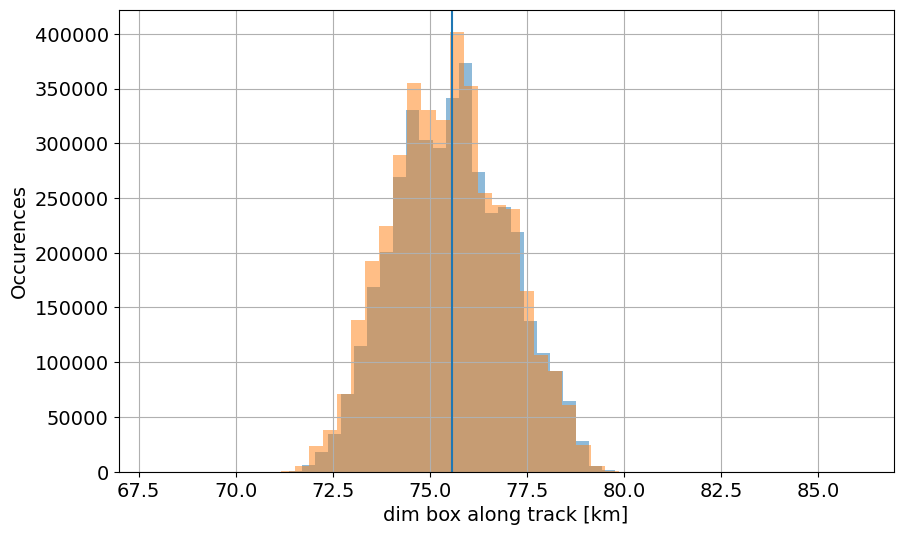

In [5]:
pl=plt.hist(wave_sp_alongT[wave_sp_alongT>0],bins=50,alpha=0.5)
pl=plt.hist(wave_sp_alongB[wave_sp_alongB>0],bins=50,alpha=0.5)
meansizebox = np.mean(wave_sp_alongT[wave_sp_alongT>0])
plt.axvline(meansizebox)
plt.xlabel('dim box along track [km]')
plt.ylabel('Occurences')
print('Mean size box along track = ',meansizebox,' km')
print('Equivalent klim0 = ',2*np.pi/(1000*meansizebox),' m-1')

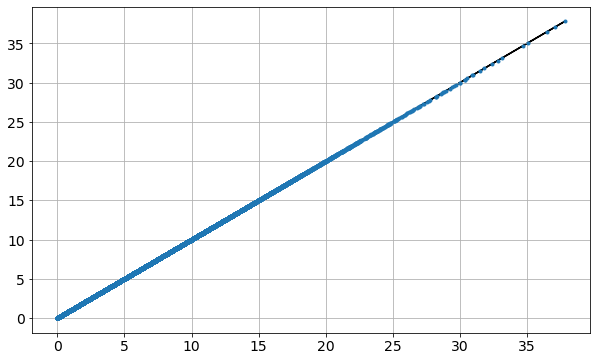

In [32]:
plt.plot(MMenv2T,MVenvT+(MMenvT)**2,'.');
plt.plot(MMenv2T,MMenv2T,'-k',zorder=0);


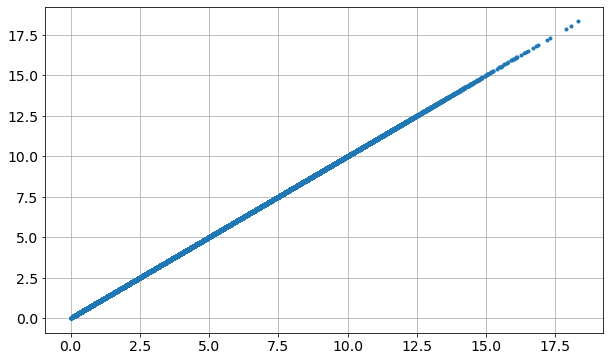

In [10]:
plt.plot(4*np.sqrt(SpecSum),HSBoxT,'.')

In [40]:
nx=2048
kx_resample = np.linspace(-k_vec.max(),k_vec.max(),nx)
dkx = kx_resample[1]-kx_resample[0]
print(2*np.pi/(dkx*nx))

11.256829149660787


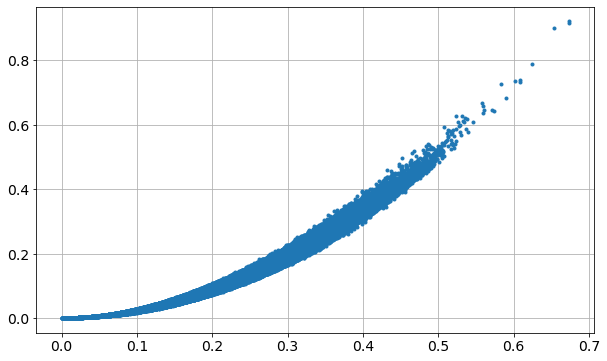

In [12]:
# plt.plot(kappa3,kappa4,'.')
plt.plot(lambda3,lambda4,'.')

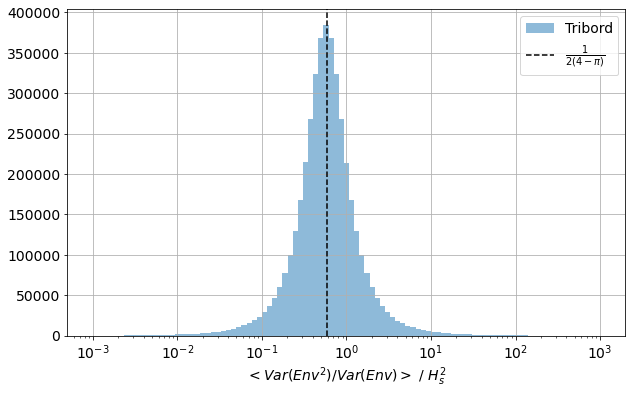

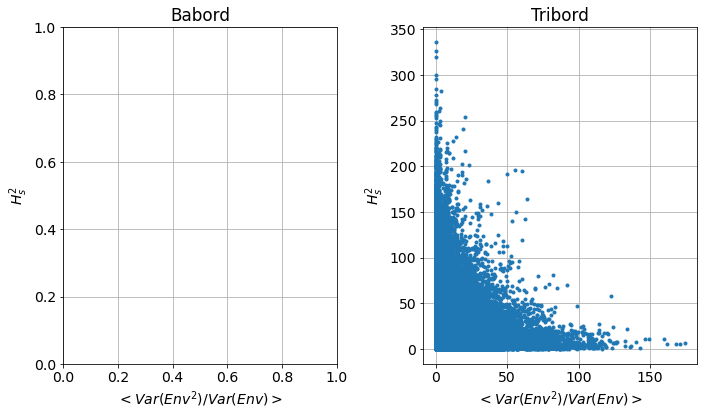

In [12]:
# indHSsup1B = np.where(HSBoxB>=1)[0]
indHSsup1T = np.where(HSBoxT>=0)[0]

# coeff_for_ratio0B = MRV_B/ HSBoxB**2
coeff_for_ratio0T = MRV_T[indflagT] / HSBoxT**(2)

# coeff_for_ratio0T = MRV_T[indflagT] / (MHsSurfT[indflagT] **2/4)**(3/2)
# plt.hist(coeff_for_ratio0B[indHSsup1B],bins=np.logspace(-3,3,100),histtype='step',lw=2,label='Babord');
plt.hist(coeff_for_ratio0T[indHSsup1T],bins=np.logspace(-3,3,100),alpha=0.5,label='Tribord');
plt.xscale('log')
plt.axvline(1/(2*(4-np.pi)),linestyle='--',color='k',label = r'$ \frac{1}{2 (4 - \pi)}$')
# plt.yscale('log')
plt.xlabel('$<Var(Env^2)/Var(Env)>$ / $H_s^2$');
plt.legend();

fig,axs=plt.subplots(1,2)
# axs[0].plot(MRV_B[indHSsup1B],HSBoxB[indHSsup1B]**2,'.');
axs[0].set_title('Babord');
axs[0].set_xlabel('$<Var(Env^2)/Var(Env)>$');
axs[0].set_ylabel('$H_s^2$');
axs[1].plot(MRV_T[indHSsup1T],HSBoxT[indHSsup1T]**2,'.');
axs[1].set_title('Tribord');
axs[1].set_xlabel('$<Var(Env^2)/Var(Env)>$');
axs[1].set_ylabel('$H_s^2$');

plt.tight_layout()

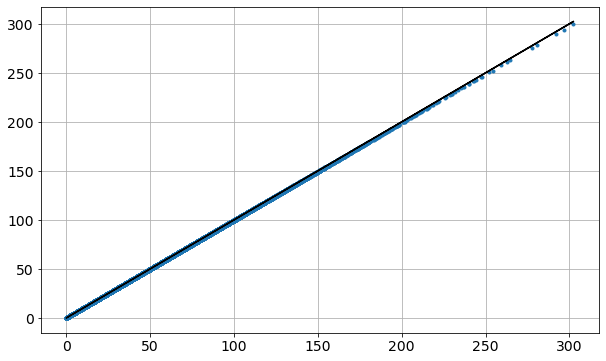

In [67]:
x = ((MHsSurfT[indflagT]**2)/4)**2
# x = HSBoxT**(2)
y = MVenv2T[indflagT]/MVenvT[indflagT]
plt.plot(x,2*(4-np.pi)*y,'.')
plt.plot(x,x,'-k')

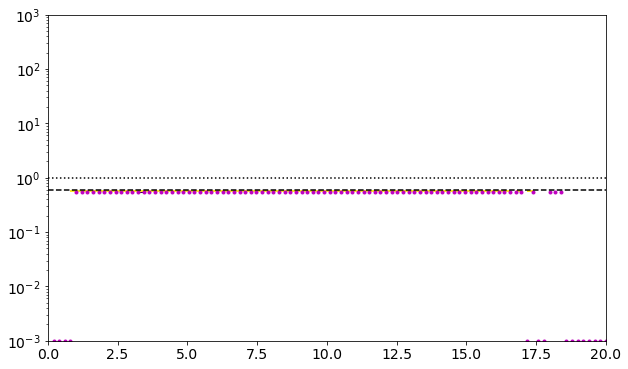

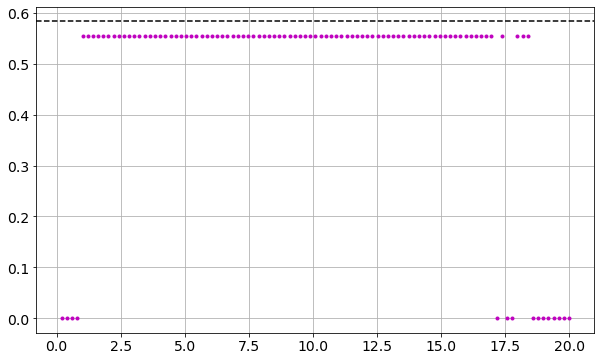

In [58]:
plt.figure()

coeff_for_ratio0T = MRV_T[indflagT] / HSBoxT**(3/2)
coeff_for_ratio0T = MRV_T[indflagT] / ((MHsSurfT[indflagT]**2)/4)**2#(3/2)
hs = (MHsSurfT[indflagT]**2)/4
indHSsup1T = np.where(HSBoxT>=1)[0]
His,x,y = np.histogram2d(HSBoxT[indHSsup1T],coeff_for_ratio0T[indHSsup1T],
                         bins=[np.linspace(0,20,100),np.logspace(-3,3,200)])

# plt.scatter(HSBoxB[indHSsup1B],coeff_for_ratio0B[indHSsup1B],c=spread_f_B[indHSsup1B])#,alpha=0.2)
# plt.plot(HSBoxT[indHSsup1T],coeff_for_ratio0T[indHSsup1T],'.',alpha=0.2)
# plt.scatter(HSBoxT[indHSsup1T],coeff_for_ratio0T[indHSsup1T]*HSBoxT[indHSsup1T],c=indfmax[indHSsup1T])
plt.pcolormesh(x,y,np.log10(His).T/np.max(np.log10(His),axis=1))
# plt.plot(HSBoxT,((varenv2/(varenv*HSBoxT**(1/2)))),'.m')
plt.plot(x[1:],y[np.argmax(np.log10(His),axis=1).astype(int)],'.m')
# plt.plot(HSBoxT,HSBoxT**-(1/2),'*c')
plt.yscale('log');
plt.axhline(1/(2*(4-np.pi)),linestyle='--',color='k',label = r'$ \frac{1}{2 (4 - \pi)}$');
plt.axhline(1,linestyle=':',color='k',label = r'$ \frac{1}{2 (4 - \pi)}$');

plt.figure()
plt.plot(x[1:],y[np.argmax(np.log10(His),axis=1).astype(int)],'.m')
plt.axhline(1/(2*(4-np.pi)),linestyle='--',color='k',label = r'$ \frac{1}{2 (4 - \pi)}$');

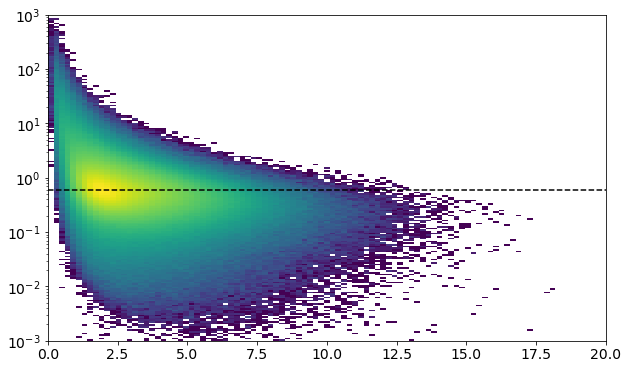

In [15]:
plt.figure()

His,x,y = np.histogram2d(HSBoxT[indHSsup1T],coeff_for_ratio0T[indHSsup1T],
                         bins=[np.linspace(0,20,100),np.logspace(-3,3,200)])

# plt.scatter(HSBoxB[indHSsup1B],coeff_for_ratio0B[indHSsup1B],c=spread_f_B[indHSsup1B])#,alpha=0.2)
# plt.plot(HSBoxT[indHSsup1T],coeff_for_ratio0T[indHSsup1T],'.',alpha=0.2)
# plt.plot(HSBoxT[indHSsup1T],coeff_for_ratio0T[indHSsup1T])#,c=width_param[indHSsup1T])
plt.pcolormesh(x,y,np.log10(His).T)
plt.yscale('log');
plt.axhline(1/(2*(4-np.pi)),linestyle='--',color='k',label = r'$ \frac{1}{2 (4 - \pi)}$');

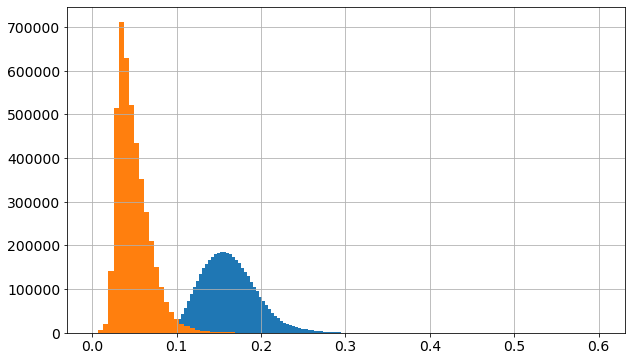

In [115]:
plt.hist(width_param,bins=100);
plt.hist(Bw,bins=100);


25


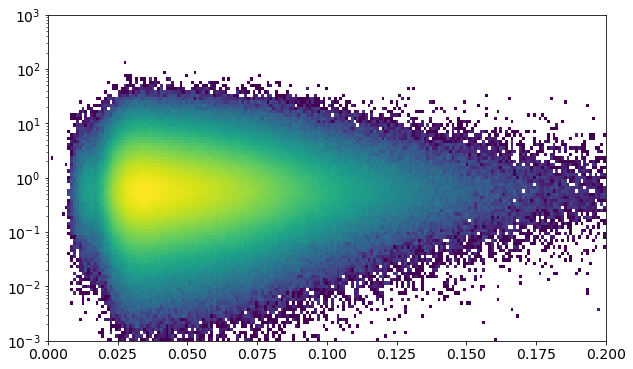

In [121]:
nb = 200
bins_by_var= {'Goda_param_T': np.linspace(0,12,nb),
             'width_param': np.linspace(0,0.35,nb),
             'spread_f_T':np.linspace(0,0.2,nb),
             'indfmax':np.arange(0,27)-0.5,
             'Bw':np.linspace(0,0.2,nb),
             'coeff_for_ratio0T':np.logspace(-3,3,100),}

# bins_by_var= {'Goda_param_T': (0,12),
#              'width_param': (0,0.35),
#              'spread_f_T':(0,0.2),
#              'indfmax':(-0.5,27),}

x00 = 'Bw'
y00 = 'coeff_for_ratio0T'
# exec('xlim0 = bins_by_var["'+x00+'"]')
# exec('ylim0 = bins_by_var["'+y00+'"]')
exec('xbins0 = bins_by_var["'+x00+'"]')
exec('ybins0 = bins_by_var["'+y00+'"]')
exec('x0 = '+x00)
exec('y0 = '+y00)
print(indfmax.max())
# His,x,y = np.histogram2d(x0[indHSsup1T],y0[indHSsup1T],
#                          bins=[np.linspace(xlim0[0],xlim0[1],200),
#                                np.linspace(ylim0[0],ylim0[1],200)])#,np.arange(0,27)-0.5])

His,x,y = np.histogram2d(x0[indHSsup1T],y0[indHSsup1T],
                         bins=[xbins0,ybins0])#,np.arange(0,27)-0.5])



plt.pcolormesh(x,y,np.log10(His).T);


# plt.xscale('log')
plt.yscale('log')

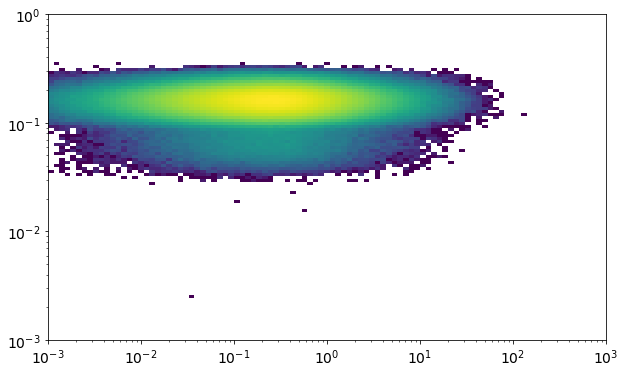

In [114]:
width_param= ((m2*m0)/(m1**2))-1
df_vec = np.gradient(f_vec)
Bw = ((4)/(m0**2))*np.sum(Spec_f**2*(f_vec-np.atleast_2d(m1/m0).T)**2*df_vec,axis=1)



His,x,y = np.histogram2d(coeff_for_ratio0T[indHSsup1T]/HSBoxT[indHSsup1T],width_param[indHSsup1T],
                         bins=[np.logspace(-3,3,100),np.logspace(-3,0,110)])#,np.arange(0,27)-0.5])


plt.pcolormesh(x,y,np.log10(His).T)
plt.xscale('log')
plt.yscale('log')
# coeff_for_ratio0T[indHSsup1T],indfmax[indHSsup1T],'.');



2000
0 0 300
200
0 1 300
20
1 0 300
2
1 1 300
0.2
2 0 300
0.02
2 1 300


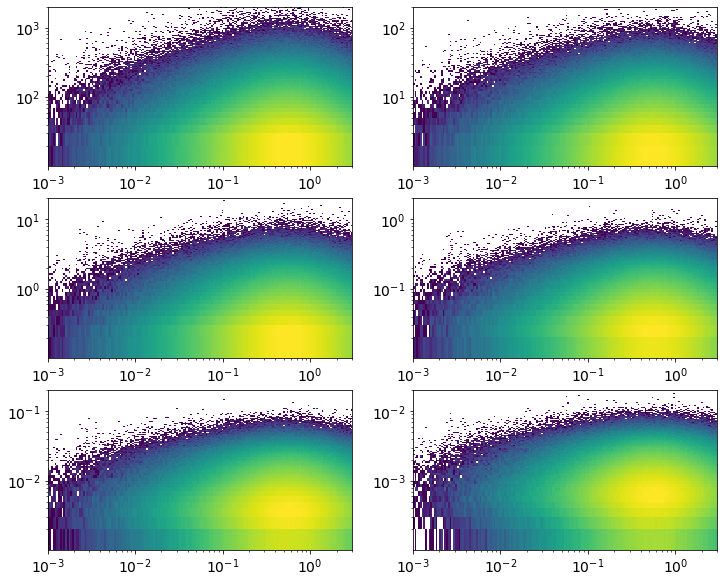

In [85]:
fig,axs=plt.subplots(3,2,figsize=(12,10))

moments_vec= ['mm2','mm1','m0','m1','m2','m3']
binsval = np.logspace(-3,3,300)
for ik,mom in enumerate(moments_vec):
    print(2*10**(3-ik))
    bin2 = np.linspace(0,2*10**(3-ik),200)
    
    exec("His,x,y = np.histogram2d(coeff_for_ratio0B[indHSsup1B],"+mom+"[indHSsup1B],bins=[binsval,bin2])")
    print(ik//2,ik%2,len(x))
    axs[ik//2,ik%2].pcolormesh(x,y,np.log10(His).T)#,coeff_for_ratio0B[indHSsup1B],'.')
    axs[ik//2,ik%2].set_xscale('log')
    axs[ik//2,ik%2].set_yscale('log')
    axs[ik//2,ik%2].set_ylim(((y[1]),(y[-1])))
    axs[ik//2,ik%2].set_xlim((-3,3))

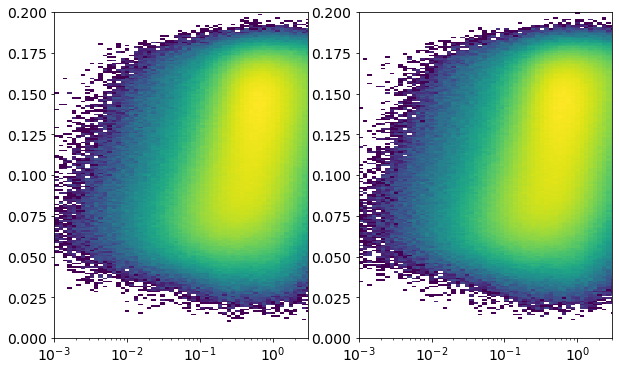

In [40]:
# ----- SPREAD vs coeff ----------------------

fig,axs=plt.subplots(1,2)
isscatter=0

if isscatter:
    axs[0].plot(coeff_for_ratio0B[indHSsup1B],spread_f_B[indHSsup1B],'.');
    axs[0].set_xlim((0,500))
else:
    His,x,y = np.histogram2d(coeff_for_ratio0B[indHSsup1B],spread_f_B[indHSsup1B],bins=[np.logspace(-3,3,100),np.linspace(0,0.2,200)])
    axs[0].pcolormesh(x,y,np.log10(His).T);
    axs[0].set_xscale('log')
    axs[0].set_xlim((-3,3))
if isscatter:
    axs[1].plot(coeff_for_ratio0T[indHSsup1T],spread_f_T[indHSsup1T],'.');
    axs[1].set_xlim((0,500))
else:
    His,x,y = np.histogram2d(coeff_for_ratio0T[indHSsup1T],spread_f_T[indHSsup1T],bins=[np.logspace(-3,3,100),np.linspace(0,0.2,200)])
    axs[1].pcolormesh(x,y,np.log10(His).T);
    axs[1].set_xscale('log')
    axs[1].set_xlim((-3,3))

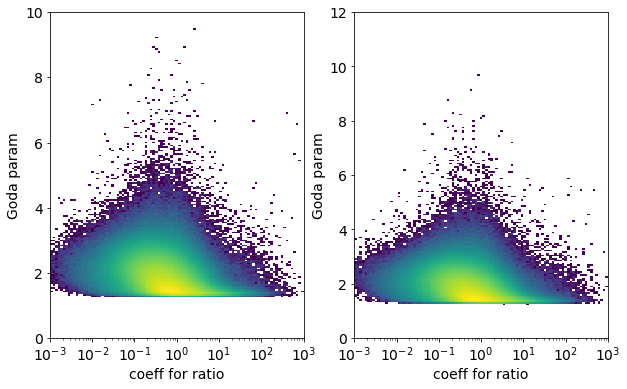

In [27]:
# ----- Goda vs coeff ----------------------

fig,axs=plt.subplots(1,2)
isscatter=0

if isscatter:
    axs[0].plot(coeff_for_ratio0B,Goda_param_B,'.');
    axs[0].set_xlim((0,500))
    axs[0].set_yscale('log')
    axs[0].set_xscale('log')
    axs[0].set_xlim((-3,3))
    axs[0].set_xlabel('coeff for ratio')
    axs[0].set_ylabel('Goda param')
else:
    His,x,y = np.histogram2d(coeff_for_ratio0B,Goda_param_B,bins=[np.logspace(-3,3,100),np.linspace(0,10,200)])
    axs[0].pcolormesh(x,y,np.log10(His).T);
    axs[0].set_xscale('log')
#     axs[0].set_yscale('log')
    axs[0].set_xlim((-3,None))
    axs[0].set_xlabel('coeff for ratio')
    axs[0].set_ylabel('Goda param')
#     axs[0].set_ylim((-3,0))
    
if isscatter:
    axs[1].plot(coeff_for_ratio0T,Goda_param_T,'.');
#     axs[1].set_xlim((0,500))
    axs[1].set_yscale('log')
    axs[1].set_xscale('log')
    axs[1].set_xlim((-3,3))
    axs[1].set_xlabel('coeff for ratio')
    axs[1].set_ylabel('Goda param')
else:
    His,x,y = np.histogram2d(coeff_for_ratio0T,Goda_param_T,bins=[np.logspace(-3,3,100),np.linspace(0,12,200)])
    axs[1].pcolormesh(x,y,np.log10(His).T);
    axs[1].set_xscale('log')
    axs[1].set_xlim((-3,None))
    axs[1].set_xlabel('coeff for ratio')
    axs[1].set_ylabel('Goda param')

0.9999883189305747
nan
0.9999866835808552
3616.22601347362
5.5118823652300515  ,  5.519142119768957  -  0.26671102885505327
ratio/hs**2 : mean :  1.3220822664537815  , median :  0.5716468573053665
Env2 ~ chi2 and Env ~ chi: ratio / Hs**2 = 1/(2*(4 - pi)) =  0.5824740457906858


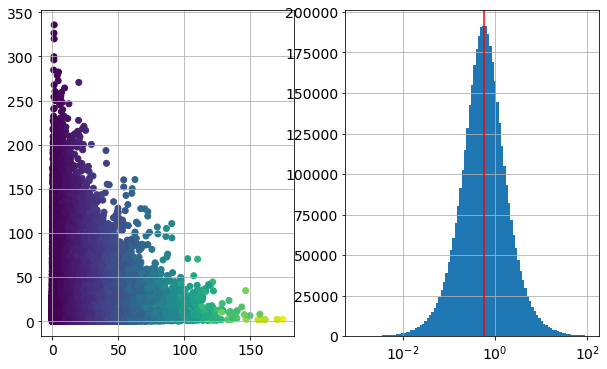

In [51]:
HSBoxB
coeff_for_ratio0B = MRVB[Hs0>0.1]/Hs0[Hs0>0.1]**2
print(len(coeff_for_ratio0)/len(Hs0))
print(coeff_for_ratio0.max())
coeff_for_ratio = coeff_for_ratio0[np.isfinite(coeff_for_ratio0)]
print(len(coeff_for_ratio)/len(Hs0))
print(coeff_for_ratio.max())
fig,axs=plt.subplots(1,2)
axs[0].scatter(MRV0,Hs0**2,c= SRV0) # => mean(ratio) = ratio(means)
axs[1].hist(coeff_for_ratio,bins=np.logspace(-3,2,100))
axs[1].axvline(1/(2*(4-np.pi)),color='r')
axs[1].set_xscale('log')
print(np.nanmean(MRV0),' , ', np.nanmean(RMV0),' - ',np.nanmean(SRV0))#,' , ',np.mean(coeff_for_ratio))
print('ratio/hs**2 : mean : ',np.mean(coeff_for_ratio),' , median : ',np.median(coeff_for_ratio))
print('Env2 ~ chi2 and Env ~ chi: ratio / Hs**2 = 1/(2*(4 - pi)) = ',(1/(2*(4-np.pi))))

0.9999883189305747
nan
0.9999866835808552
3616.22601347362
5.5118823652300515  ,  5.519142119768957  -  0.26671102885505327
ratio/hs**2 : mean :  1.3220822664537815  , median :  0.5716468573053665
Env2 ~ chi2 and Env ~ chi: ratio / Hs**2 = 1/(2*(4 - pi)) =  0.5824740457906858


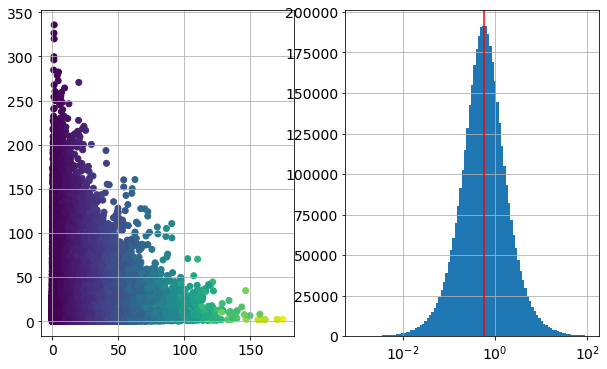

In [51]:
coeff_for_ratio0 = MRV0[Hs0>0.1]/Hs0[Hs0>0.1]**2
coeff_for_ratio = coeff_for_ratio0[np.isfinite(coeff_for_ratio0)]




fig,axs=plt.subplots(1,2)
axs[0].scatter(MRV0,Hs0**2,c= SRV0) # => mean(ratio) = ratio(means)
axs[1].hist(coeff_for_ratio,bins=np.logspace(-3,2,100))
axs[1].axvline(1/(2*(4-np.pi)),color='r')
axs[1].set_xscale('log')
print(np.nanmean(MRV0),' , ', np.nanmean(RMV0),' - ',np.nanmean(SRV0))#,' , ',np.mean(coeff_for_ratio))
print('ratio/hs**2 : mean : ',np.mean(coeff_for_ratio),' , median : ',np.median(coeff_for_ratio))
print('Env2 ~ chi2 and Env ~ chi: ratio / Hs**2 = 1/(2*(4 - pi)) = ',(1/(2*(4-np.pi))))

(4019055,)


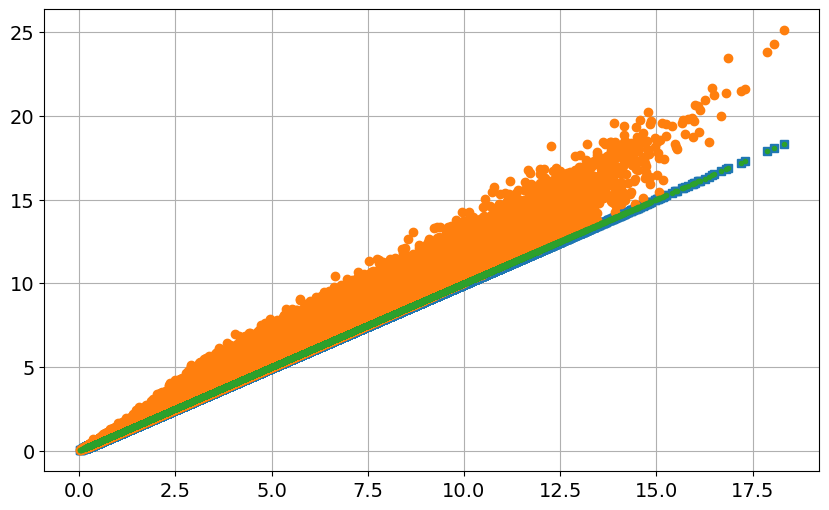

In [76]:
# ---- We had spectral problems .... ------------------
Hs_spec_1S = 4*np.sqrt(np.sum(SpecT*dk_vec,axis=1))

kvec2 = np.concatenate([-k_vec[::-1],np.zeros(1),k_vec])#,np.zeros(1),k_vec])
dk_vec2 = np.gradient(kvec2)

SpecT2 = np.concatenate([np.zeros((33,len(Hs_spec_1S))),SpecT.T]).T

Hs_spec_2S = 4*np.sqrt(np.sum(SpecT2*dk_vec2,axis=1))

kvec3= np.concatenate([-k_vec[::-1],(k_vec[0] - dk_vec[0])*np.array([-1,1]),k_vec])#,np.zeros(1),k_vec])
dk_vec3 = np.gradient(kvec3)

SpecT3 = np.concatenate([np.zeros((34,len(Hs_spec_1S))),SpecT.T]).T

Hs_spec_2S_m0 = 4*np.sqrt(np.sum(SpecT3*dk_vec3,axis=1))
print(np.shape(Hs_spec_1S))

plt.plot(HSBoxT,Hs_spec_1S,'s',label='$H_s$ from Spec CFOSAT (32 freqs)')
plt.plot(HSBoxT,Hs_spec_2S,'o',label='$H_s$ from Spec CFOSAT (64 freqs)')
plt.plot(HSBoxT,Hs_spec_2S_m0,'.',label='$H_s$ from Spec CFOSAT (66 freqs -> keeping dkvec)')

(0.1, 200.0)

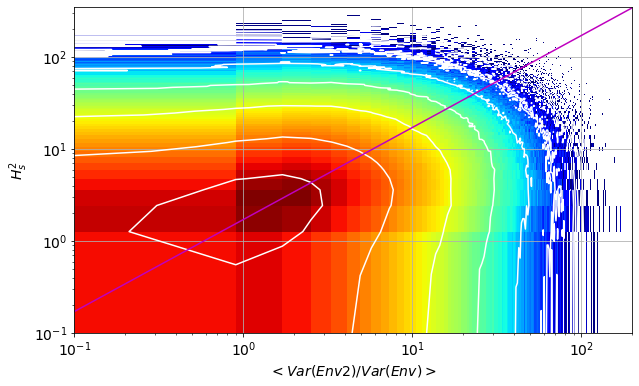

In [76]:
hist_RMVHs2,x,y = np.histogram2d(MRV0,Hs0**2,bins=[np.linspace(0.1,200,250),np.linspace(0.1,350,300)])
hist_RMVHs2[hist_RMVHs2==0] = np.nan

plt.pcolormesh(x,y,np.log10(hist_RMVHs2).T,cmap=plt.cm.jet)#,c=Goda_param0)
plt.contour(x[:-1],y[:-1],np.log10(hist_RMVHs2).T,colors='w')
plt.plot(x,x*(2*(4-np.pi)),'-m')
plt.xlabel('$< Var(Env2) / Var(Env)>$')
plt.ylabel('$H_s^2$')
plt.grid(True)
plt.xscale('log')
plt.yscale('log')
plt.xlim()

In [52]:
from sklearn.decomposition import PCA

def perform_PCA_reduction(data, nb_components, whiten=False):

    pca = PCA(n_components=nb_components, whiten=whiten)
    # data shape must me (n_samples, n_features)
    reduced_data = pca.fit_transform(data)
    txt = "PCA misses {:.2f}% of total variance.".format(
           100*(1-np.sum(pca.explained_variance_ratio_[:nb_components])))

    print("Previous data shape: {:}".format(data.shape))
    print("Reduced data shape: {:}".format(reduced_data.shape))
    print(txt)
    
    return reduced_data, pca.components_, pca.singular_values_, pca.mean_


def explained_variance(data):
    # explained variance analysis
    # data shape must be (n_samples, n_features)
    full_pca = PCA()
    full_pca.fit(data)  

    fig = plt.figure(figsize=(12,8))
    plt.plot(range(1,len(full_pca.explained_variance_ratio_)+1), np.cumsum(full_pca.explained_variance_ratio_),'k.-')
    #plt.yscale('log')
    plt.xscale('log')
    plt.xlabel("targetted dimension", fontsize=20)
    plt.ylabel("explained variance ratio", fontsize=20)
    plt.grid(True)
    
    return fig

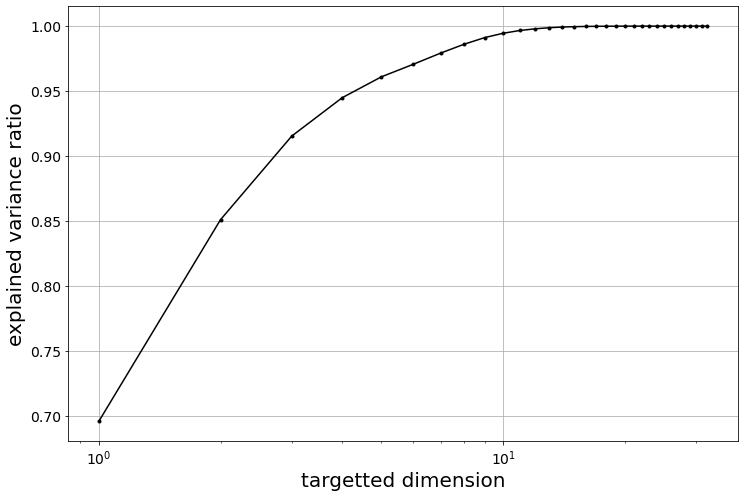

In [10]:
fig=explained_variance(Spec)

In [11]:
reduced_data, pcac, pcasv, pcam = perform_PCA_reduction(Spec, 2)

Previous data shape: (4280430, 32)
Reduced data shape: (4280430, 2)
PCA misses 14.89% of total variance.


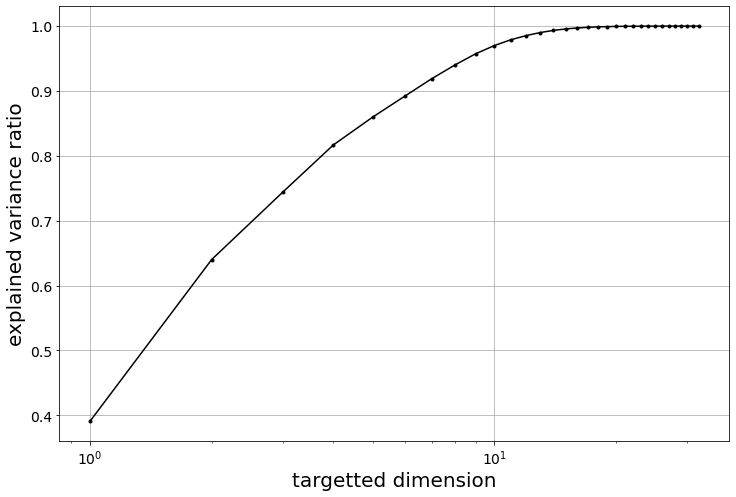

In [79]:
fig=explained_variance(SpecN)

In [80]:
reduced_dataN, pcacN, pcasvN, pcamN = perform_PCA_reduction(SpecN, 2)

Previous data shape: (4280430, 32)
Reduced data shape: (4280430, 2)
PCA misses 35.99% of total variance.


pca.components_ :  (2, 32)  , pca.singular_values_ :  (2,)  , pca.mean_ :  (32,)


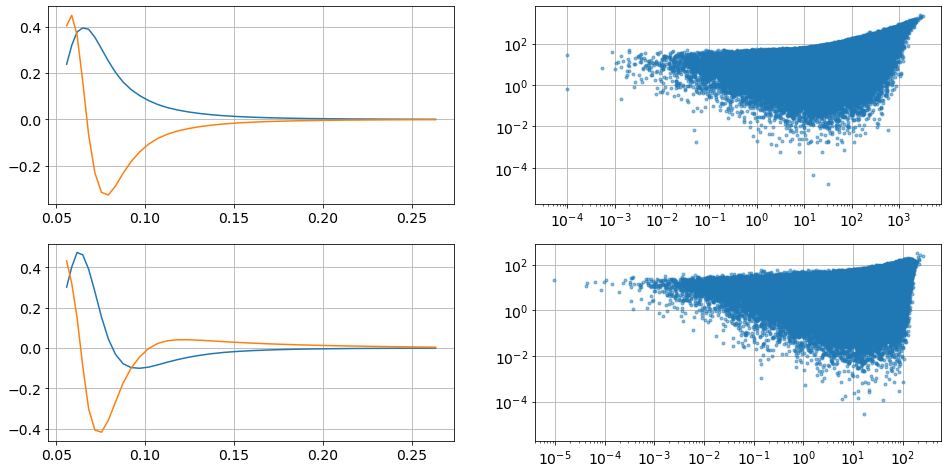

In [15]:
print('pca.components_ : ', np.shape(pcac),' , pca.singular_values_ : ',np.shape(pcasv),
      ' , pca.mean_ : ',np.shape(pcam))
f_vec = sig_from_k(k_vec)/(2*np.pi)
fig,axs = plt.subplots(2,2,figsize=(16,8))
_=axs[0,0].plot(f_vec,pcac.T)
_=axs[0,1].plot(reduced_data[:,0].flatten(),reduced_data[:,1].flatten(),'.',alpha=0.5)
_=axs[0,1].set_xscale('log')
_=axs[0,1].set_yscale('log')
_=axs[1,0].plot(f_vec,pcacN.T)
_=axs[1,1].plot(reduced_dataN[:,0].flatten(),reduced_dataN[:,1].flatten(),'.',alpha=0.5)
_=axs[1,1].set_xscale('log')
_=axs[1,1].set_yscale('log')

(32,)
(4280430,)


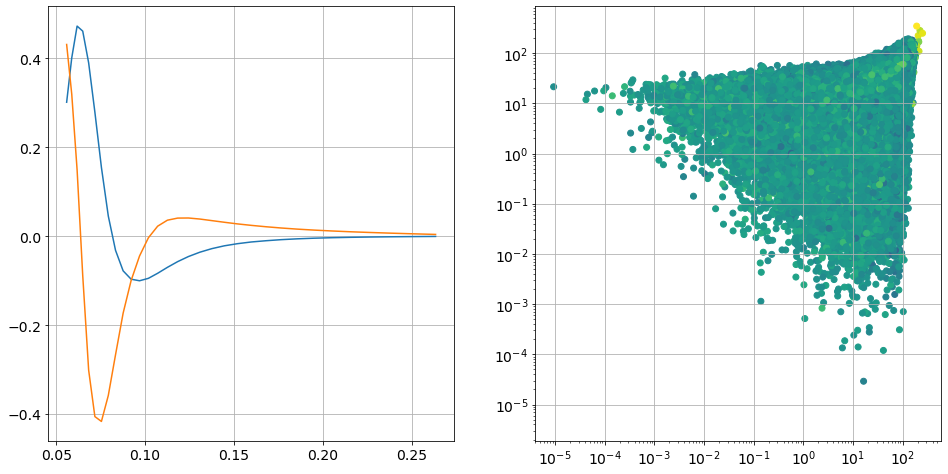

In [86]:
f_vec = sig_from_k(k_vec)/(2*np.pi)
print(f_vec.shape)
coeff_for_ratio0 = MRV0/Hs0**2
indnoinf = np.where(np.isfinite(coeff_for_ratio0))[0]
coeff_for_ratio=coeff_for_ratio0[indnoinf]
print(coeff_for_ratio0.shape)

fig,axs = plt.subplots(1,2,figsize=(16,8))
_=axs[0].plot(f_vec,pcacN.T)
_=axs[1].scatter(reduced_dataN[indnoinf,0].flatten(),reduced_dataN[indnoinf,1].flatten(),
                 c=np.log10(coeff_for_ratio))
#,'.',alpha=0.5)
_=axs[1].set_xscale('log')
_=axs[1].set_yscale('log')

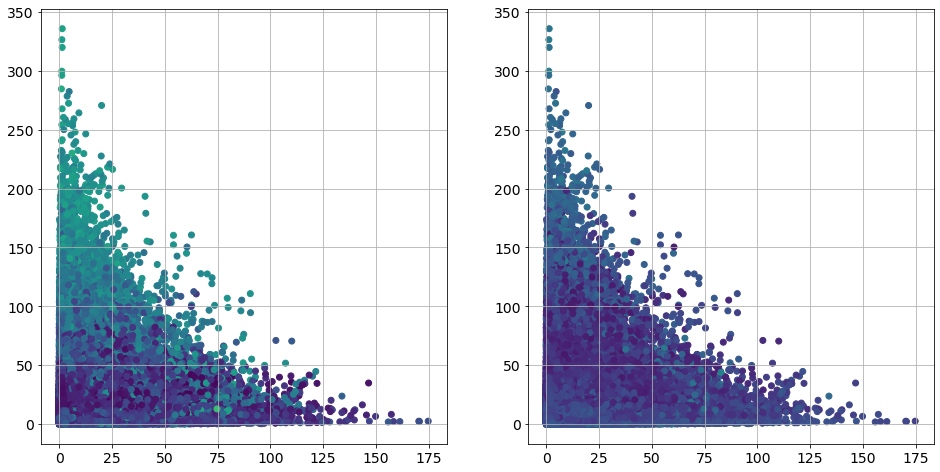

In [87]:
fig,axs = plt.subplots(1,2,figsize=(16,8))
_=axs[0].scatter(MRV0[indnoinf],Hs0[indnoinf]**2,c=reduced_dataN[indnoinf,0].flatten())

_=axs[1].scatter(MRV0[indnoinf],Hs0[indnoinf]**2,c=reduced_dataN[indnoinf,1].flatten())
#,'.',alpha=0.5)
# _=axs[1].set_xscale('log')
# _=axs[1].set_yscale('log')

In [82]:
f_vec = sig_from_k(k_vec)/(2*np.pi)
coeff_for_ratio0 = MRV0/Hs0**2
print(coeff_for_ratio0.shape,SpecN.shape)

(4280430,) (4280430, 32)


148765  specs between  0  and  1
1297913  specs between  1  and  2
1417160  specs between  2  and  3
714983  specs between  3  and  4
555435  specs between  4  and  6
120259  specs between  6  and  8
21309  specs between  8  and  10
3825  specs between  10  and  12
660  specs between  12  and  14
121  specs between  14  and  20


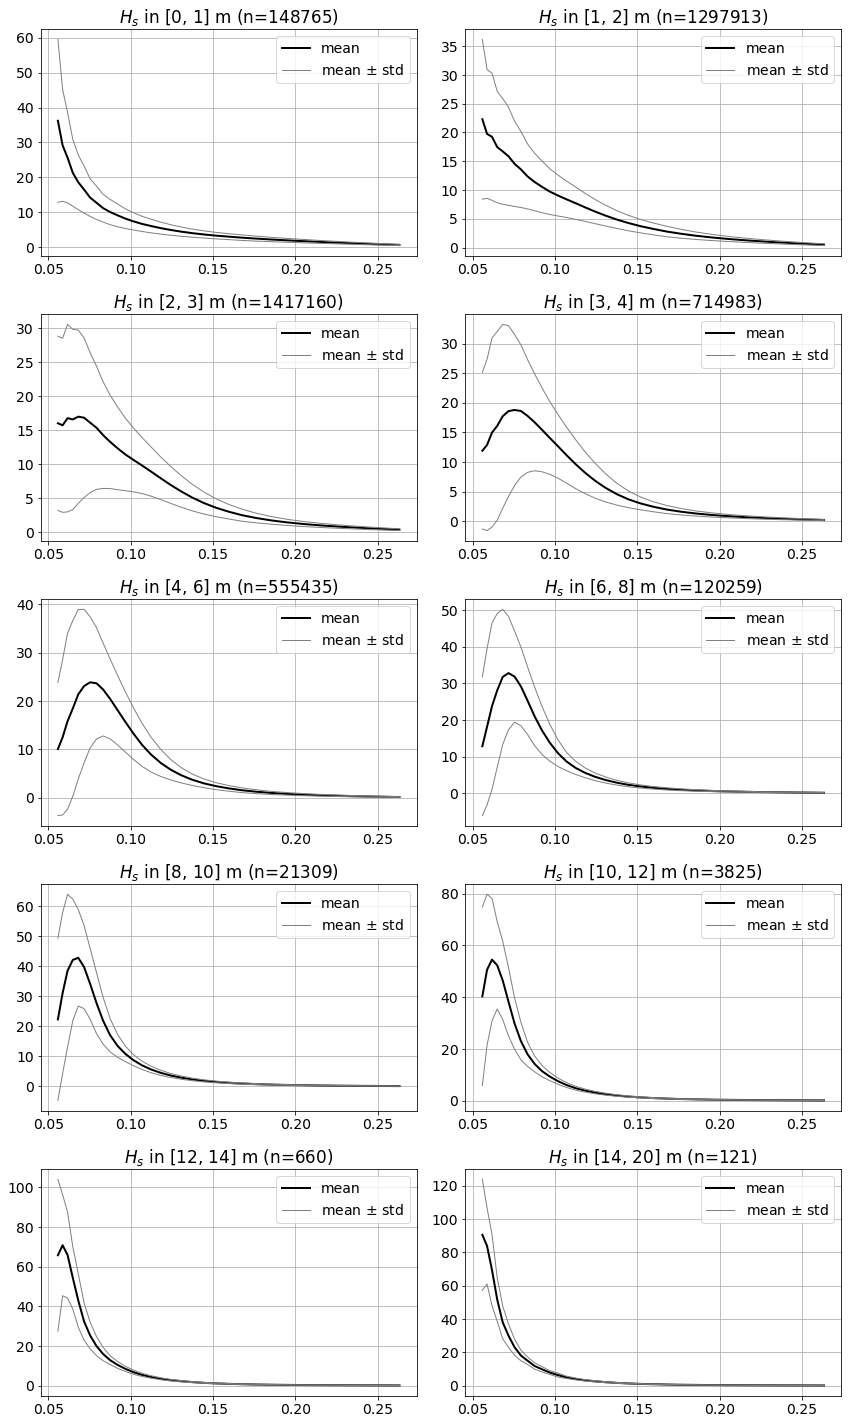

In [16]:
Hs_from_spec = 4*np.sqrt(SpecSum)

Hs_bins = [1,2,3,4,6,8,10,12,14,20]
hs_previous =0
fig,axs = plt.subplots(5,2,figsize=(12,20))
for hk,hs0 in enumerate(Hs_bins):
    ind = np.where((Hs_from_spec >= hs_previous) & (Hs_from_spec < hs0))[0]
    print(len(ind),' specs between ',hs_previous,' and ',hs0)
    meanS = np.mean(SpecN[ind,:],axis=0)
    stdS = np.std(SpecN[ind,:],axis=0)
#     axs[hk//2,hk%2].plot(f_vec,SpecN[ind,:].T,'-',color='grey',lw=0.5,alpha=0.5)
    pl1=axs[hk//2,hk%2].plot(f_vec,meanS,'-',color='k',lw=2,label='mean')
    pl2=axs[hk//2,hk%2].plot(f_vec,meanS+stdS,'-',color='grey',lw=1,label='mean $\pm$ std')
    axs[hk//2,hk%2].plot(f_vec,meanS-stdS,'-',color='grey',lw=1)
    axs[hk//2,hk%2].set_title('$H_s$ in ['+str(hs_previous)+', '+str(hs0)+'] m (n='+str(len(ind))+')')
    axs[hk//2,hk%2].legend()
    hs_previous= hs0
# plt.plot()
# plt.plot(f_vec,SpecN[:100,:].T);
# plt.plot(f_vec,np.mean(SpecN[:100,:],axis=0),'-w',lw=3)
# plt.plot(f_vec,np.mean(SpecN[:,:],axis=0),'-m',lw=3)
plt.tight_layout()
plt.savefig('Spectrum_normalized_mean_by_Hs_bins.png')

In [29]:
print('mean Goda param : ',np.nanmean(Goda_param0),' median : ',np.nanmedian(Goda_param0))


mean Goda param :  1.7864078477571426  median :  1.6799364083371


In [12]:
print('mean Goda param : ',np.nanmean(Goda_param0),' median : ',np.nanmedian(Goda_param0))


mean Goda param :  1.7758755518270049  median :  1.6706486742353017


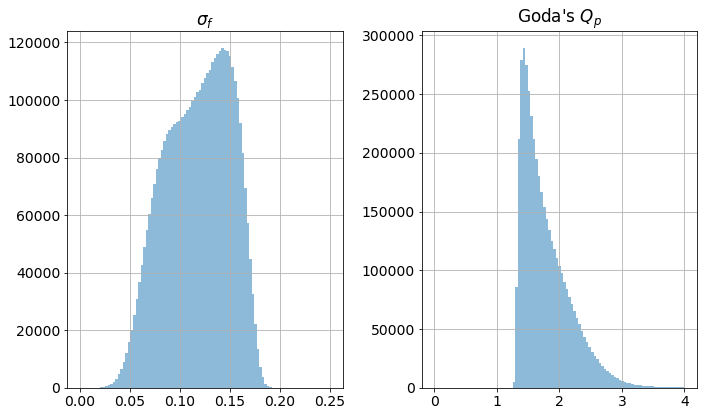

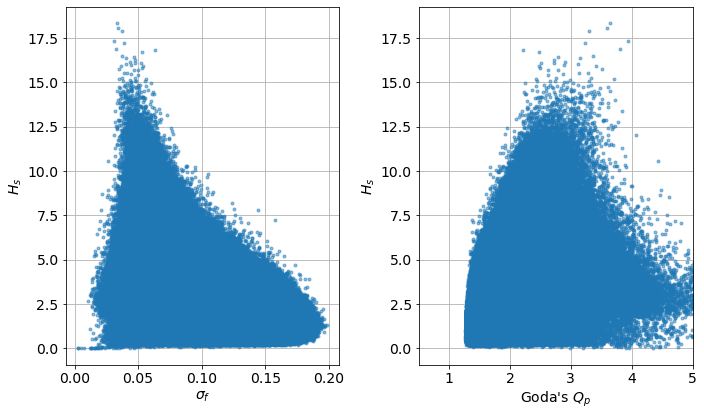

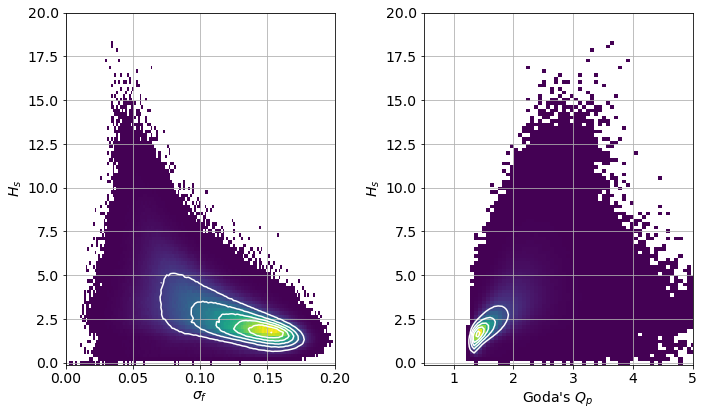

In [50]:
fig,axs=plt.subplots(1,2)
# axs[0].plot(spread_f0,Hs_from_spec,'.')#,c=Goda_param0)
axs[0].hist(spread_f0,bins=np.linspace(0,0.25,100),alpha=0.5)
axs[0].set_title('$\sigma_f$')
axs[1].hist(Goda_param0,bins=np.linspace(0,4,100),alpha=0.5)
axs[1].set_title("Goda's $Q_p$")
plt.tight_layout()
# axs[1].set_xscale('log')
plt.savefig('/home/mdecarlo/DATA/CFOSAT/L2P/BDD_boxes/Histo_spread_Goda.png')

hist_spreadHs,x,y = np.histogram2d(spread_f0,Hs_from_spec,bins=[np.linspace(0,0.20,150),np.linspace(-0.1,20,100)])
hist_godaHs,xi,yi = np.histogram2d(Goda_param0,Hs_from_spec,bins=[np.linspace(0,10,150),np.linspace(-0.1,20,100)])
hist_spreadHs[hist_spreadHs==0] = np.nan
hist_godaHs[hist_godaHs==0] = np.nan
fig,axs=plt.subplots(1,2)
axs[0].plot(spread_f0,Hs_from_spec,'.',alpha=0.5)#,c=Goda_param0)
axs[0].set_xlabel('$\sigma_f$')
axs[0].set_ylabel('$H_s$')
axs[1].plot(Goda_param0,Hs_from_spec,'.',alpha=0.5)
axs[1].set_xlim((0.5,5))
axs[1].set_xlabel("Goda's $Q_p$")
axs[1].set_ylabel('$H_s$')
plt.tight_layout()
plt.savefig('/home/mdecarlo/DATA/CFOSAT/L2P/BDD_boxes/scatter_spread_Goda_vs_Hs.png')

fig,axs=plt.subplots(1,2)
axs[0].pcolormesh(x,y,hist_spreadHs.T)#,c=Goda_param0)
axs[0].contour(x[:-1],y[:-1],hist_spreadHs.T,colors='w')
axs[0].set_xlabel('$\sigma_f$')
axs[0].set_ylabel('$H_s$')
axs[0].grid(True)
axs[1].pcolormesh(xi,yi,hist_godaHs.T)
axs[1].contour(xi[:-1],yi[:-1],hist_godaHs.T,colors='w')
axs[1].set_xlim((0.5,5))
# axs[1].set_xscale('log')
axs[1].set_xlabel("Goda's $Q_p$")
axs[1].set_ylabel('$H_s$')
axs[1].grid(True)
plt.tight_layout()
plt.savefig('/home/mdecarlo/DATA/CFOSAT/L2P/BDD_boxes/Histo2D_spread_Goda_vs_Hs.png')

In [ ]:
### Fonction to determine var(Env2) / var(Env)
Spec_ex = Speck[0,:]
def prep_interp_grid(dkmin=0.0003734846,kmax=0.21):
    # --- define k interpolation vector (positive part) ----
    kX00 = np.arange(0.5*(dkmin),kmax,dkmin)
    # --- duplicate to have both positive and negative parts --------------
    kX0_origin = np.concatenate((kX00,-np.flip(kX00[:])))
    kX0 = np.fft.fftshift(kX0_origin)
    kx = kX0
    ky = kX0[:-2] 
    # --- generate 2D grid ------------------------
    kX,kY = np.meshgrid(kx,ky , indexing='ij')
    # --- compute associated K, Phi(in deg) ---------
    kK = np.sqrt(kX**2+kY**2)
    kPhi = np.arctan2(kY,kX)*180/np.pi
    kPhi[kPhi<0]=kPhi[kPhi<0]+360
    
    kK2 = xr.DataArray(kK, coords=[("kx", kx), ("ky",ky)])
    # print(kK2)
    kPhi2 = xr.DataArray(kPhi, coords=[("kx", kx), ("ky",ky)])
    kKkPhi2s = xr.Dataset(
            {'kK': kK2,
             'kPhi': kPhi2}
        ).stack(flattened=["kx", "ky"])#.reset_index("flattened")
    return kKkPhi2s



In [64]:
def function_ratio_per_spec(Spec_ex,k_vec,phases,kx_resample):
    funcspecinterp = spi.interp1d(k_vec,Spec_ex,bounds_error=False,fill_value=0)
    dkx = kx_resample[1]-kx_resample[0]
    newspec0 = funcspecinterp(kx_resample)
    newspec = np.broadcast_to(newspec0,phases.T.shape).T

    zhats=np.fft.ifftshift(np.sqrt(2*newspec*dkx)*np.exp(1j*2*np.pi*phases))
    S_r = np.real(np.fft.ifft(zhats,norm="forward",axis=0))
    S_i = np.imag(np.fft.ifft(zhats,norm="forward",axis=0))
    
    Env2 = S_r**2+S_i**2
    Env = np.sqrt(Env2)
    
    varenv2 = np.var(Env2,axis=0)
    varenv = np.var(Env,axis=0)
    mean_ratio_vars = np.mean(varenv2/varenv)
    std_ratio_vars = np.std(varenv2/varenv)
    ratio_mean_vars = np.mean(varenv2)/np.mean(varenv)

    return mean_ratio_vars, std_ratio_vars, ratio_mean_vars

def function_ratio_per_specv2(Spec_ex,k_vec,phases,kx_resample):
    funcspecinterp = spi.interp1d(k_vec,Spec_ex,bounds_error=False,fill_value=0)
    dkx = kx_resample[1]-kx_resample[0]
    newspec0 = funcspecinterp(kx_resample)
#     nx = np.size(phases,0)
#     nseed = np.size(phases,1)
#     nspec = np.size(Spec_ex,0)

#     phases2D = np.broadcast_to(phases,(nspec,nx,nseed))
#     newspec = np.atleast_3d(newspec0)
#     print(newspec.shape)
#     newspec = np.moveaxis(np.broadcast_to(newspec0,(nseed,nspec,nx)),0,-1)
#     del(newspec0)
#     gc.collect()
    # output shape : nspec,nx,nseed
    zhats=np.fft.ifftshift(np.sqrt(2*np.atleast_3d(newspec0)*dkx)*np.exp(1j*2*np.pi*phases))
    del(newspec0,funcspecinterp)
    gc.collect()
    Env = np.abs(np.fft.ifft(zhats,norm="forward",axis=1))
    Env2 = Env**2
#     S_i = np.imag(np.fft.ifft(zhats,norm="forward",axis=1))
    del(zhats)
    gc.collect()
#     Env2 = S_r**2+S_i**2
#     del(S_r,S_i)
#     gc.collect()
#     Env = np.sqrt(Env2)
    
    varenv2 = np.var(Env2,axis=1)
    varenv = np.var(Env,axis=1)
    mean_ratio_vars = np.mean(varenv2/varenv,axis=-1)
    std_ratio_vars = np.std(varenv2/varenv,axis=-1)
    ratio_mean_vars = np.mean(varenv2,axis=-1)/np.mean(varenv,axis=-1)

    return mean_ratio_vars, std_ratio_vars, ratio_mean_vars

In [36]:
import gc

phases = np.zeros((nx,nseed))
for i in range(nseed):
    rng = np.random.default_rng(i)
    phases[:,i]=rng.uniform(low=0.0, high=1.0, size=(nx))
funcspecinterp = spi.interp1d(k_vec,Spec2[1:20,:],bounds_error=False,fill_value=0)
A = funcspecinterp(kx_resample)
nspec = np.size(A,0)
print(phases.shape, A.shape)
phases2D = np.broadcast_to(phases,(nspec,nx,nseed))
newspec = np.moveaxis(np.broadcast_to(A,(nseed,nspec,nx)),0,-1)
zhats=np.fft.ifftshift(np.sqrt(2*newspec*dkx)*np.exp(1j*2*np.pi*phases2D))
print('after broadcasting -------------')
print(phases2D.shape)
print(newspec.shape)
del(A,phases,newspec,phases2D)
gc.collect()
print(zhats.shape)
print('2D after removal -------------')
print(phases2D.shape,newspec.shape)
print('1D after removal -------------')
print(phases.shape, A.shape)

(2048, 500) (19, 2048)
after broadcasting -------------
(19, 2048, 500)
(19, 2048, 500)
(19, 2048, 500)
2D after removal -------------


NameError: name 'phases2D' is not defined

time for linspace :  0.0004818439483642578
time for phases :  0.03892183303833008
time for  100 spectra : 9.328178882598877


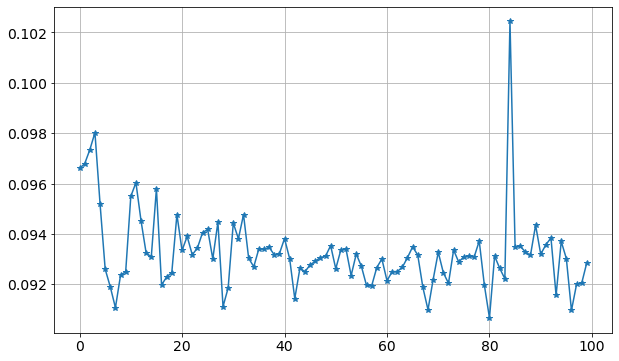

In [60]:
import time
start_time = time.time()

nx=2048
nseed = 500
Spec_ex = Spec2[2,:]

kx_resample = np.linspace(-k_vec.max(),k_vec.max(),nx)
kx_0_is_origin = np.fft.ifftshift(kx_resample)
dkx =  kx_0_is_origin[1]-kx_0_is_origin[0]
print('time for linspace : ',time.time()-start_time)
time0 = time.time()
phases = np.zeros((nx,nseed))
for i in range(nseed):
    rng = np.random.default_rng(i)
    phases[:,i]=rng.uniform(low=0.0, high=1.0, size=(nx))
print('time for phases : ',time.time()-time0)

time0 = time.time()
lS=100
times = np.zeros(lS)
MRV = np.zeros(lS)
SRV = np.zeros(lS)
RMV = np.zeros(lS)
for ik in range(lS):
    time1=time.time()
    MRV0, SRV0, RMV0 = function_ratio_per_spec(Spec2[ik,:],k_vec,phases,kx_resample)
    MRV[ik]=MRV0
    SRV[ik]=SRV0
    RMV[ik]=RMV0
    times[ik] = time.time()-time1
print('time for ',lS,'spectra :',time.time()-time0)
plt.plot(times,'*-')

In [80]:
Spec2.shape
# 36*32
# 221.184.000
print(str(8*nx*nseed*27*100))

22118400000


time for linspace :  0.001352548599243164
time for phases :  0.03271651268005371
100
0.047236230373382565


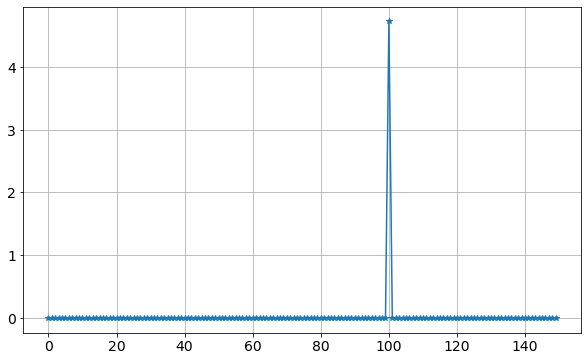

In [65]:
import time
start_time = time.time()

nx=2048
nseed = 500
Spec_ex = Spec2[2,:]

kx_resample = np.linspace(-k_vec.max(),k_vec.max(),nx)
kx_0_is_origin = np.fft.ifftshift(kx_resample)
dkx =  kx_0_is_origin[1]-kx_0_is_origin[0]
print('time for linspace : ',time.time()-start_time)
time0 = time.time()
phases = np.zeros((nx,nseed))
for i in range(nseed):
    rng = np.random.default_rng(i)
    phases[:,i]=rng.uniform(low=0.0, high=1.0, size=(nx))
print('time for phases : ',time.time()-time0)

lTr=150
times = np.zeros(lTr)
kls=100
for lS in range(kls,kls+1):
    print(lS)
    time0 = time.time()
    MRV0 = np.zeros(lS)
    SRV0 = np.zeros(lS)
    RMV0 = np.zeros(lS)
    MRV0, SRV0, RMV0 = function_ratio_per_specv2(Spec2[:lS,:],k_vec,phases,kx_resample)
    times[lS] = time.time()-time0
# for ik in range(lS):
#     time1=time.time()
#     MRV0, SRV0, RMV0 = function_ratio_per_spec(Spec2[ik,:],k_vec,phases,kx_resample)
#     MRV[ik]=MRV0
#     SRV[ik]=SRV0
#     RMV[ik]=RMV0
#     times[ik] = time.time()-time1
# print('time for ',lS,'spectra :',time.time()-time0)
plt.plot(times,'*-')
print(times[kls]/kls)

In [44]:
print(times[100]/100)

0.09655242919921875


In [17]:
0.05*np.size(Spec2,0)/3600

59.45041666666667

In [64]:
funcspecinterp = spi.interp1d(k_vec,Spec2[1:20,:],bounds_error=False,fill_value=0)

In [65]:
A= funcspecinterp(kx_resample)

In [71]:
print(A.shape) # nspec, nx
nspec = np.size(A,0)
nx = 2048
nseed = 500
phases2D = np.broadcast_to(phases,(nspec,nx,nseed))
newspec = np.moveaxis(np.broadcast_to(A,(nseed,nspec,nx)),0,-1)
print(phases2D.shape)
print(newspec.shape)

(19, 2048)
(19, 2048, 500)
(19, 2048, 500)


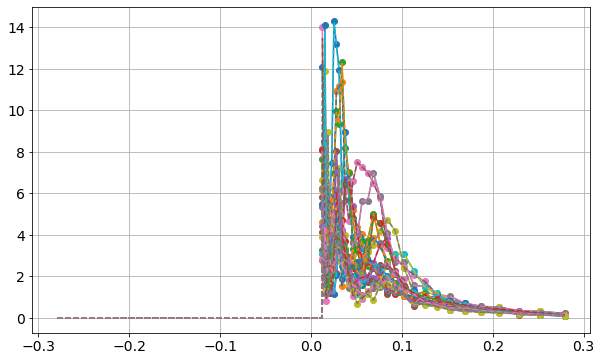

In [69]:
plt.plot(k_vec,Spec2[1:20,:].T,'o-');
plt.plot(kx_resample,A.T,'--');